# Athabasca Glacier Albedo Analysis

## Introduction and Methodology

This analysis compares MODIS satellite-derived albedo measurements with ground-truth automatic weather station (AWS) observations for glacier surface albedo validation. The study employs multiple MODIS products and temporal aggregation approaches to assess the accuracy and reliability of satellite-based albedo retrievals.

### Study Objectives

1. **Evaluate MODIS albedo products** against high-quality ground measurements
2. **Compare different MODIS methods** (MCD43A3 BRDF, MOD09GA surface reflectance, MOD10A1 snow product)
3. **Assess Terra/Aqua data fusion** effectiveness for improved temporal coverage
4. **Analyze temporal patterns** across multiple timescales (daily, weekly, 16-day, monthly)
5. **Identify optimal approaches** for glacier albedo monitoring

### Data Processing Methodology

- **Terra/Aqua Fusion**: Combined Terra and Aqua observations using mean values when both satellites provide data, or single observations when only one is available
- **Temporal Aggregation**: Analysis at multiple scales from daily observations to monthly composites
- **Quality Control**: Systematic outlier detection and statistical validation
- **Spatial Analysis**: Pixel-level comparisons and geographic context evaluation

The following sections present comprehensive statistical comparisons, temporal pattern analysis, and method performance evaluation across different aggregation periods.

## Core & Spatial Library Imports

#### Import and load libraries

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path

# Optional spatial libraries
try:
    import geopandas as gpd
    import contextily as ctx
    from shapely.geometry import Point
    import rasterio
    from rasterio.plot import show as rio_show
    from rasterio.warp import transform_bounds
    SPATIAL_LIBS = True
    print("Spatial libraries available")
except ImportError:
    SPATIAL_LIBS = False
    print("Warning: Spatial libraries not available. Install geopandas and contextily for spatial analysis.")

Spatial libraries available



#### Glacier Data Catalog and Loader Functions

In [2]:
# Terra/Aqua Data Fusion Function
def merge_terra_aqua(df):
    """Merge Terra and Aqua observations by averaging when both available, or using single observation."""
    df = df.copy()
    df['method'] = df['method'].str.upper()
    
    albedo_col = 'albedo' if 'albedo' in df.columns else 'albedo_value'
    product_pairs = {'MOD09GA': 'MYD09GA', 'MOD10A1': 'MYD10A1'}
    combined_rows = []
    
    # Process Terra/Aqua pairs
    for terra, aqua in product_pairs.items():
        terra_df = df[df['method'] == terra].copy()
        aqua_df = df[df['method'] == aqua].copy()
        
        if len(terra_df) == 0 and len(aqua_df) == 0:
            continue
        
        # Special case: Terra-only data (no Aqua counterpart)
        if len(terra_df) > 0 and len(aqua_df) == 0:
            terra_df['source'] = 'terra_only'
            combined_rows.append(terra_df)
            continue
        
        # Special case: Aqua-only data (no Terra counterpart)
        if len(aqua_df) > 0 and len(terra_df) == 0:
            aqua_df['source'] = 'aqua_only'
            aqua_df['method'] = terra  # Rename to Terra for consistency
            combined_rows.append(aqua_df)
            continue
            
        # Normal case: merge Terra and Aqua data
        merged = pd.merge(terra_df, aqua_df, on=['date', 'pixel_id'], suffixes=('_terra', '_aqua'), how='outer')
        
        # Combine albedo values (mean of both or single available)
        terra_albedo, aqua_albedo = f'{albedo_col}_terra', f'{albedo_col}_aqua'
        merged[albedo_col] = merged[[terra_albedo, aqua_albedo]].mean(axis=1)
        merged['method'] = terra  # Use Terra name for combined
        merged['source'] = np.where(
            merged[terra_albedo].notna() & merged[aqua_albedo].notna(), 'combined',
            np.where(merged[terra_albedo].notna(), 'terra_only', 'aqua_only')
        )
        
        # Preserve spatial coordinates
        merged['latitude'] = merged['latitude_terra'].combine_first(merged['latitude_aqua'])
        merged['longitude'] = merged['longitude_terra'].combine_first(merged['longitude_aqua'])
        
        # Preserve additional important columns (using terra first, then aqua as fallback)
        additional_cols = ['glacier_fraction', 'solar_zenith', 'ndsi', 'elevation', 'slope', 'aspect', 'qa_mode']
        for col in additional_cols:
            terra_col = f'{col}_terra'
            aqua_col = f'{col}_aqua'
            if terra_col in merged.columns or aqua_col in merged.columns:
                if terra_col in merged.columns and aqua_col in merged.columns:
                    # For numerical columns, take mean; for categorical, prefer terra
                    if col in ['glacier_fraction', 'elevation', 'slope', 'aspect']:
                        merged[col] = merged[[terra_col, aqua_col]].mean(axis=1)
                    elif col == 'solar_zenith':
                        # For solar zenith, prefer valid values over -999
                        terra_valid = (merged[terra_col] != -999) & merged[terra_col].notna()
                        aqua_valid = (merged[aqua_col] != -999) & merged[aqua_col].notna()
                        
                        merged[col] = merged[terra_col].copy()
                        merged.loc[~terra_valid & aqua_valid, col] = merged.loc[~terra_valid & aqua_valid, aqua_col]
                        merged.loc[~terra_valid & ~aqua_valid, col] = -999
                    else:
                        # For categorical columns like qa_mode, prefer terra
                        merged[col] = merged[terra_col].combine_first(merged[aqua_col])
                elif terra_col in merged.columns:
                    merged[col] = merged[terra_col]
                elif aqua_col in merged.columns:
                    merged[col] = merged[aqua_col]
        
        # Keep essential columns plus preserved additional columns
        base_cols = ['date', 'pixel_id', 'method', albedo_col, 'latitude', 'longitude', 'source']
        preserved_cols = [col for col in additional_cols if col in merged.columns]
        keep_cols = base_cols + preserved_cols
        
        result = merged[keep_cols]
        combined_rows.append(result)
    
    # Keep non-paired methods unchanged (like MCD43A3)
    other_methods = df[~df['method'].isin(list(product_pairs.keys()) + list(product_pairs.values()))]
    
    final_result = pd.concat(combined_rows + [other_methods], ignore_index=True) if combined_rows else other_methods
    return final_result

#### Export Directory Setup

In [3]:
# Create exports directory for organized output
GLACIER = "athabasca"  # Define glacier name for this analysis
EXPORT_DIR = Path("exports")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

def out(filename: str) -> str:
    """Return a glacier-prefixed path inside exports/ directory"""
    return str(EXPORT_DIR / f"{GLACIER}_{filename}")

print(f"📁 All plots and reports will be saved to: {EXPORT_DIR.resolve()}")

📁 All plots and reports will be saved to: D:\Documents\Projects\athabasca_analysis\exports


#### Glacier Selection and Data Loading

In [4]:
# Load and prepare data for analysis
print(f"🏔️  Loading data for: {GLACIER}")

# Load the new reorganized MODIS data with AWS albedo included
try:
    modis = pd.read_csv(f'data/csv/Athabasca_MultiProduct_with_AWS.csv')
    print(f"✓ MODIS + AWS data: {len(modis)} rows, shape: {modis.shape}")
    print(f"✓ Columns available: {list(modis.columns)}")
    
    # Check AWS data availability
    aws_available = modis['albedo_AWS'].notna().sum()
    print(f"✓ AWS albedo observations: {aws_available} records")
    
except FileNotFoundError:
    print(f"❌ Reorganized MODIS file not found - trying original format...")
    try:
        modis = pd.read_csv(f'data/csv/{GLACIER.lower()}_Terra_Aqua_MultiProduct_2014-01-01_to_2021-01-01.csv')
        print(f"✓ Original MODIS data: {len(modis)} rows, shape: {modis.shape}")
    except FileNotFoundError:
        print(f"❌ MODIS file not found for {GLACIER}")
        modis = pd.DataFrame()

# Load AWS data (keeping this for backward compatibility or separate analysis)
try:
    aws = pd.read_csv(f'data/csv/iceAWS_Atha_albedo_daily_20152020_filled_clean.csv', 
                      parse_dates=['Time'])
    print(f"✓ Separate AWS data: {len(aws)} rows, shape: {aws.shape}")
except FileNotFoundError:
    print(f"❌ AWS file not found for {GLACIER}")
    aws = pd.DataFrame()

🏔️  Loading data for: athabasca
✓ MODIS data: 1430 rows, shape: (1430, 24)
✓ AWS data: 2199 rows, shape: (2199, 2)
✓ Glacier mask: 1 features
✓ AWS points: 1 features

📊 MODIS columns: ['pixel_id', 'date', 'qa_mode', 'method', 'albedo', 'glacier_fraction', 'ndsi', 'solar_zenith', 'elevation', 'slope', 'aspect', 'longitude', 'latitude', 'tile_h', 'tile_v', 'pixel_row', 'pixel_col', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07']
📊 AWS columns: ['Time', 'Albedo']

📁 All outputs will be saved to: exports/athabasca_*
🎯 Ready to analyze athabasca glacier data!


In [ ]:
# Process the reorganized data format
print("🔄 Processing reorganized data format...")

if not modis.empty and 'albedo_MOD09GA' in modis.columns:
    print("✓ Using new reorganized format with methods as columns")
    
    # Convert the wide format back to long format for compatibility with existing analysis
    # This maintains compatibility with the rest of the notebook
    
    # Create a list to store converted records
    long_format_rows = []
    
    # Method mapping from new format to expected format
    method_mapping = {
        'MOD09GA': 'MOD09GA',
        'MYD09GA': 'MYD09GA', 
        'mcd43a3': 'MCD43A3',  # Normalize case
        'mod10a1': 'MOD10A1',  # Normalize case
        'myd10a1': 'MYD10A1'   # Normalize case
    }
    
    # Convert date to datetime
    modis['date'] = pd.to_datetime(modis['date'])
    
    # For each method, create rows in long format
    for orig_method, standard_method in method_mapping.items():
        albedo_col = f'albedo_{orig_method}'
        
        if albedo_col in modis.columns:
            # Get rows where this method has data
            method_data = modis[modis[albedo_col].notna()].copy()
            
            if len(method_data) > 0:
                # Create long format records
                method_rows = method_data[['pixel_id', 'date', 'qa_mode', albedo_col]].copy()
                method_rows['method'] = standard_method
                method_rows['albedo'] = method_rows[albedo_col]
                method_rows = method_rows.drop(columns=[albedo_col])
                
                # Add additional columns if available
                additional_cols = ['glacier_fraction', 'solar_zenith', 'ndsi', 'elevation', 
                                 'slope', 'aspect', 'longitude', 'latitude']
                
                for col in additional_cols:
                    method_col = f'{col}_{orig_method}'
                    if method_col in modis.columns:
                        method_rows[col] = method_data[method_col]
                    elif col in modis.columns:  # Fallback to general column
                        method_rows[col] = method_data[col]
                
                long_format_rows.append(method_rows)
    
    # Combine all method data
    if long_format_rows:
        modis_long = pd.concat(long_format_rows, ignore_index=True)
        print(f"✓ Converted to long format: {len(modis_long)} records")
        print(f"✓ Available methods: {sorted(modis_long['method'].unique())}")
        
        # Replace the original modis dataframe
        modis = modis_long
        
        # Also update AWS data processing to work with the new format
        if 'albedo_AWS' in pd.read_csv('data/csv/Athabasca_MultiProduct_with_AWS.csv').columns:
            print("✓ AWS data is already integrated in the main dataset")
    
    else:
        print("❌ No valid method data found in reorganized format")

print(f"✓ Data processing complete - MODIS shape: {modis.shape}")
if not modis.empty:
    print(f"✓ Methods available: {sorted(modis['method'].unique()) if 'method' in modis.columns else 'No method column'}")
    print(f"✓ Date range: {modis['date'].min()} to {modis['date'].max()}")

### Terra/Aqua Data Fusion



In [5]:
# Apply Terra/Aqua Merge and Data Standardization
print("🔄 Applying Terra/Aqua merge...")
modis = merge_terra_aqua(modis)

# Standardize column names and date formats
if 'albedo_value' not in modis.columns and 'albedo' in modis.columns:
    # Keep the original column name as 'albedo'
    pass
modis['method'] = modis['method'].str.upper()
modis['date'] = pd.to_datetime(modis['date'])
aws['date'] = pd.to_datetime(aws['Time'])

# Display merge results
print(f"✓ Terra/Aqua merge complete - Final MODIS rows: {len(modis)}")
if 'source' in modis.columns:
    print("📊 Source breakdown:", dict(modis['source'].value_counts()))

🔄 Applying Terra/Aqua merge...
✓ Terra/Aqua merge complete - Final MODIS rows: 1298
📊 Source breakdown: {'terra_only': np.int64(459), 'aqua_only': np.int64(148), 'combined': np.int64(132)}


In [6]:
# Create pivot table and merge with AWS data
modis_pivot = modis.pivot_table(index='date', columns='method', values='albedo', aggfunc='mean')

# Create additional pivots for the extra columns needed for outlier analysis
additional_columns = ['glacier_fraction', 'solar_zenith', 'ndsi', 'pixel_id']
additional_data = {}

for col in additional_columns:
    if col in modis.columns:
        # For glacier_fraction, solar_zenith, ndsi: take mean
        # For pixel_id: take first (they should be the same for same date)
        if col == 'pixel_id':
            additional_data[col] = modis.pivot_table(index='date', columns='method', values=col, aggfunc='first')
        else:
            additional_data[col] = modis.pivot_table(index='date', columns='method', values=col, aggfunc='mean')
        print(f"✓ Added {col} data to merge")

# Merge with AWS data first
merged = pd.merge(modis_pivot, aws[['date', 'Albedo']], on='date', how='inner')
merged.rename(columns={'Albedo': 'AWS'}, inplace=True)
merged.set_index('date', inplace=True)

# Add the additional columns to the merged dataframe
# Since we need these for analysis across all methods, we'll add them as separate columns
for col in additional_columns:
    if col in additional_data:
        # For each method, add the corresponding column data
        for method in modis_pivot.columns:
            if method in additional_data[col].columns:
                merged[f'{col}_{method}'] = additional_data[col][method]
        
        # Create general column that prioritizes valid data over -999 values
        available_cols = [f'{col}_{method}' for method in modis_pivot.columns 
                         if f'{col}_{method}' in merged.columns]
        if available_cols:
            # Replace -999 with NaN to treat as missing data
            temp_cols = merged[available_cols].copy()
            temp_cols = temp_cols.replace(-999, np.nan)
            
            # Use the first available valid value (not -999) across methods
            merged[col] = temp_cols.bfill(axis=1).iloc[:, 0]
            
            # For solar_zenith specifically, ensure we're getting valid values
            if col == 'solar_zenith':
                # Additional check: if all methods have -999, keep as NaN
                all_missing = merged[available_cols].eq(-999).all(axis=1)
                merged.loc[all_missing, col] = np.nan

# Display final results
print(f"Final analysis results:")
print(f"MODIS processed: {modis.shape}")
print(f"AWS data: {aws.shape}")
print(f"Merged dataset: {merged.shape}")
print(f"Available methods: {list(modis_pivot.columns)}")
print(f"Date range: {merged.index.min()} to {merged.index.max()}")
print(f"Total overlapping observations: {len(merged)}")

# Show which additional columns were successfully added
added_cols = [col for col in additional_columns if col in merged.columns]
print(f"✓ Additional columns added for outlier analysis: {added_cols}")

# Show sample of merged data
print(f"\nSample of merged data:")
preview_cols = list(modis_pivot.columns) + ['AWS'] + added_cols[:2]  # Show first 2 additional cols
print(merged[preview_cols].head())

# Debug: Check solar zenith values specifically
if 'solar_zenith' in merged.columns:
    solar_stats = merged['solar_zenith'].describe()
    valid_solar = (merged['solar_zenith'] > 0) & (merged['solar_zenith'] < 90)
    print(f"\nSolar zenith angle statistics:")
    print(f"Valid values (0-90°): {valid_solar.sum()}")
    print(f"Missing (-999 or NaN): {(merged['solar_zenith'].isna() | (merged['solar_zenith'] == -999)).sum()}")
    print(f"Range of valid values: {solar_stats['min']:.1f}° to {solar_stats['max']:.1f}°")

✓ Added glacier_fraction data to merge
✓ Added solar_zenith data to merge
✓ Added ndsi data to merge
✓ Added pixel_id data to merge
Final analysis results:
MODIS processed: (1298, 25)
AWS data: (2199, 3)
Merged dataset: (515, 20)
Available methods: ['MCD43A3', 'MOD09GA', 'MOD10A1']
Date range: 2014-09-12 00:00:00 to 2020-09-18 00:00:00
Total overlapping observations: 515
✓ Additional columns added for outlier analysis: ['glacier_fraction', 'solar_zenith', 'ndsi', 'pixel_id']

Sample of merged data:
            MCD43A3   MOD09GA  MOD10A1       AWS  glacier_fraction  \
date                                                                 
2014-09-12    0.203       NaN      NaN       NaN            0.9692   
2014-09-13    0.204  0.591241     0.46  0.753022            0.9692   
2014-09-14    0.209  0.404449     0.35  0.604580            0.9692   
2014-09-15      NaN  0.246590     0.30  0.477196            0.9692   
2014-09-16      NaN  0.251019      NaN  0.368135            0.9692   

     

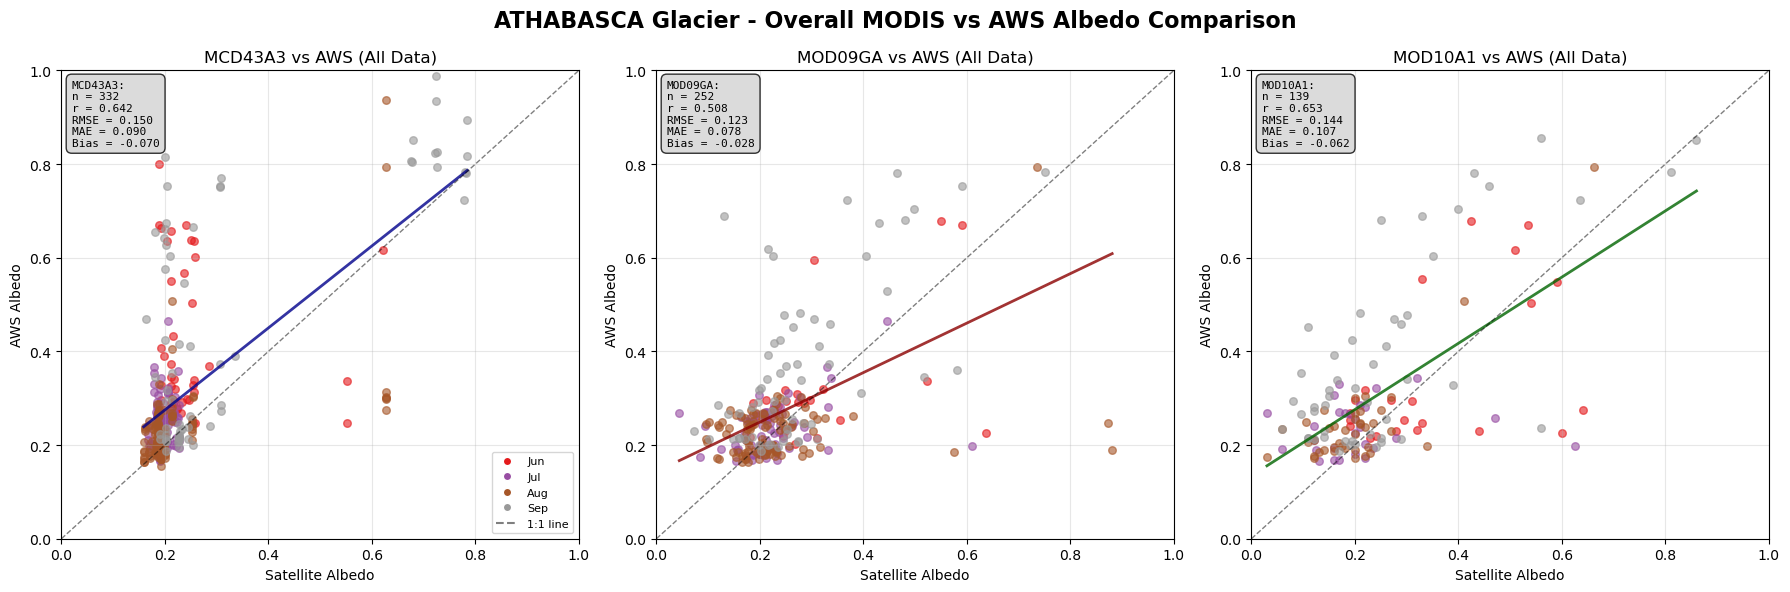

In [7]:
# ========== COMPREHENSIVE SCATTER PLOT ANALYSIS ==========
from scipy import stats as scipy_stats

# ========== PLOT CONFIGURATION ==========
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'{GLACIER.upper()} Glacier - Overall MODIS vs AWS Albedo Comparison', fontsize=16, fontweight='bold')

# Extract month data for seasonal coloring
months = merged.index.month
unique_months = sorted(months.unique())
month_names = {6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct'}
colors = plt.cm.Set1(np.linspace(0, 1, len(unique_months)))

# Method colors to match cell 26 design
methods = ['MCD43A3', 'MOD09GA', 'MOD10A1']
method_colors = {'MCD43A3': 'darkblue', 'MOD09GA': 'darkred', 'MOD10A1': 'darkgreen'}

# ========== MAIN SCATTER PLOTS (MCD43A3 & MOD09GA) ==========
for i, method in enumerate(['MCD43A3', 'MOD09GA']):
    if method in merged.columns:
        ax = axes[i]
        
        # Calculate overall statistics for this method
        overall_valid = merged[[method, 'AWS']].dropna()
        if len(overall_valid) > 1:
            r, p = scipy_stats.pearsonr(overall_valid[method], overall_valid['AWS'])
            rmse = np.sqrt(np.mean((overall_valid[method] - overall_valid['AWS'])**2))
            mae = np.mean(np.abs(overall_valid[method] - overall_valid['AWS']))
            bias = np.mean(overall_valid[method] - overall_valid['AWS'])
            n_total = len(overall_valid)
            
            # Calculate regression line
            slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(overall_valid[method], overall_valid['AWS'])
        else:
            r, p, rmse, mae, bias, n_total = 0, 1, 0, 0, 0, 0
            slope, intercept = 0, 0
        
        # Plot all data points colored by season
        for month, color in zip(unique_months, colors):
            month_mask = months == month
            month_data = merged[month_mask]
            
            if len(month_data) > 0:
                valid_data = month_data[[method, 'AWS']].dropna()
                if len(valid_data) > 0:
                    month_label = month_names.get(month, f'Month {month}')
                    ax.scatter(valid_data[method], valid_data['AWS'], 
                             c=[color], alpha=0.6, s=30, 
                             label=month_label if i == 0 else "")
        
        # Add regression line
        if len(overall_valid) > 1:
            x_min, x_max = overall_valid[method].min(), overall_valid[method].max()
            x_range = np.linspace(x_min, x_max, 50)
            y_pred = slope * x_range + intercept
            ax.plot(x_range, y_pred, color=method_colors[method], 
                   linewidth=2, alpha=0.8, 
                   label=f'Regression (y={slope:.3f}x+{intercept:.3f})')
        
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1, label='1:1 line')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xlabel('Satellite Albedo')
        ax.set_ylabel('AWS Albedo')
        ax.set_title(f'{method} vs AWS (All Data)')
        ax.grid(True, alpha=0.3)
        
        # Add statistics text box in cell 26 style
        stats_text = f"{method}:\nn = {n_total}\nr = {r:.3f}\nRMSE = {rmse:.3f}\nMAE = {mae:.3f}\nBias = {bias:.3f}"
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
                verticalalignment='top', horizontalalignment='left',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8),
                fontsize=8, family='monospace')
        
        # Add legend only for the first plot (top-left)
        if i == 0:
            # Create seasonal legend
            seasonal_legend = [plt.Line2D([0], [0], marker='o', color='w', 
                                        markerfacecolor=color, markersize=6, label=month_names.get(month, f'M{month}'))
                            for month, color in zip(unique_months, colors)]
            seasonal_legend.append(plt.Line2D([0], [0], color='k', linestyle='--', alpha=0.5, label='1:1 line'))
            ax.legend(handles=seasonal_legend, loc='lower right', fontsize=8)

# ========== MOD10A1 ANALYSIS ==========
# MOD10A1 in third position
if 'MOD10A1' in merged.columns:
    ax = axes[2]
    
    # Calculate overall statistics for MOD10A1
    overall_valid = merged[['MOD10A1', 'AWS']].dropna()
    if len(overall_valid) > 1:
        r, p = scipy_stats.pearsonr(overall_valid['MOD10A1'], overall_valid['AWS'])
        rmse = np.sqrt(np.mean((overall_valid['MOD10A1'] - overall_valid['AWS'])**2))
        mae = np.mean(np.abs(overall_valid['MOD10A1'] - overall_valid['AWS']))
        bias = np.mean(overall_valid['MOD10A1'] - overall_valid['AWS'])
        n_total = len(overall_valid)
        
        # Calculate regression line
        slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(overall_valid['MOD10A1'], overall_valid['AWS'])
    else:
        r, p, rmse, mae, bias, n_total = 0, 1, 0, 0, 0, 0
        slope, intercept = 0, 0
    
    # Plot all data points colored by season
    for month, color in zip(unique_months, colors):
        month_mask = months == month
        month_data = merged[month_mask]
        
        if len(month_data) > 0:
            valid_data = month_data[['MOD10A1', 'AWS']].dropna()
            if len(valid_data) > 0:
                month_label = month_names.get(month, f'Month {month}')
                ax.scatter(valid_data['MOD10A1'], valid_data['AWS'], 
                         c=[color], alpha=0.6, s=30, 
                         label=month_label)
    
    # Add regression line
    if len(overall_valid) > 1:
        x_min, x_max = overall_valid['MOD10A1'].min(), overall_valid['MOD10A1'].max()
        x_range = np.linspace(x_min, x_max, 50)
        y_pred = slope * x_range + intercept
        ax.plot(x_range, y_pred, color=method_colors['MOD10A1'], 
               linewidth=2, alpha=0.8, 
               label=f'Regression (y={slope:.3f}x+{intercept:.3f})')
    
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1, label='1:1 line')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Satellite Albedo')
    ax.set_ylabel('AWS Albedo')
    ax.set_title('MOD10A1 vs AWS (All Data)')
    ax.grid(True, alpha=0.3)
    
    # Add statistics text box in cell 26 style
    stats_text = f"MOD10A1:\nn = {n_total}\nr = {r:.3f}\nRMSE = {rmse:.3f}\nMAE = {mae:.3f}\nBias = {bias:.3f}"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8),
            fontsize=8, family='monospace')

# ========== FINALIZE AND EXPORT ==========
plt.tight_layout()
plt.savefig(out('comprehensive_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

## 16-Day Composite Analysis

This section performs a 16-day composite analysis similar to Ren et al. (2023). MODIS data is commonly processed in 16-day composites to reduce cloud contamination and provide more stable albedo estimates. This analysis:

- Groups data into 16-day periods starting from day 1 of each year
- Calculates mean albedo values for each 16-day period
- Compares temporal patterns between MODIS methods and AWS
- Analyzes seasonal dynamics at the 16-day scale


### 1. Calculate Statistics


In [8]:
# 16-Day Composite Analysis (Target months: Jun-Sep) - CALCULATE STATISTICS
import scipy.stats as scipy_stats

# Debug: Check merged structure and add temporal columns if needed
print("Available columns in merged:", merged.columns.tolist())
print("Merged shape:", merged.shape)

# Always create a working copy with all temporal columns
merged_copy = merged.reset_index()

# Add all necessary temporal columns
merged_copy['year'] = merged_copy['date'].dt.year
merged_copy['month'] = merged_copy['date'].dt.month  
merged_copy['doy'] = merged_copy['date'].dt.dayofyear
print("✓ Added temporal columns: year, month, doy")

# Create 16-day composites similar to MODIS standard compositing
def make_16day_composite(data, method_names):
    """Create 16-day composites from daily data"""
    # Create 16-day periods (standard MODIS compositing)
    # Each year has roughly 23 16-day periods (23 * 16 = 368 days)
    data = data.copy()
    data['period_16day'] = ((data['doy'] - 1) // 16) + 1
    
    # Group by year and 16-day period, calculate means
    composite_data = data.groupby(['year', 'period_16day']).agg({
        **{f'{m}': 'mean' for m in method_names}, 
        'AWS': 'mean'
    }).reset_index()
    
    # Add mean column names for clarity
    for method in method_names:
        composite_data[f'{method}_mean'] = composite_data[method]
    composite_data['AWS_mean'] = composite_data['AWS']
    
    return composite_data

# Create 16-day composites (focus on ablation season: Jun-Sep)
target_months = [6, 7, 8, 9]
ablation_data = merged_copy[merged_copy['month'].isin(target_months)]
composite_16day = make_16day_composite(ablation_data, ['MCD43A3', 'MOD09GA', 'MOD10A1'])

print(f"16-day composite periods: {len(composite_16day)}")

# Calculate enhanced statistics for 16-day composites  
composite_stats = {}
for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    aws_col = 'AWS_mean'
    method_col = f'{method}_mean'
    valid_data = composite_16day[[method_col, aws_col]].dropna()
    
    if len(valid_data) > 0:
        x, y = valid_data[method_col], valid_data[aws_col]
        r, p = scipy_stats.pearsonr(x, y)
        
        # Basic statistics
        diff = x - y
        abs_diff = np.abs(diff)
        rel_diff = diff / y * 100  # Relative difference in %
        
        # Regression analysis
        slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(x, y)
        
        # Outlier detection (values > 2 standard deviations)
        z_scores = np.abs(scipy_stats.zscore(diff))
        outliers = z_scores > 2
        n_outliers = np.sum(outliers)
        
        # Store comprehensive statistics
        composite_stats[method] = {
            # Sample size
            'n_periods': len(valid_data),
            'n_outliers': n_outliers,
            'outlier_pct': (n_outliers / len(valid_data)) * 100,
            
            # Correlation metrics
            'r': r, 'p': p, 'r_squared': r**2,
            
            # Error metrics
            'rmse': np.sqrt(np.mean(diff**2)),
            'mae': np.mean(abs_diff),
            'bias': np.mean(diff),
            'med_abs_error': np.median(abs_diff),
            'std_error': np.std(diff),
            
            # Relative metrics
            'mean_rel_bias': np.mean(rel_diff),
            'mean_abs_rel_error': np.mean(np.abs(rel_diff)),
            
            # Regression metrics
            'slope': slope,
            'intercept': intercept,
            'slope_stderr': std_err,
            
            # Range and distribution
            'sat_mean': np.mean(x), 'sat_std': np.std(x),
            'aws_mean': np.mean(y), 'aws_std': np.std(y),
            'sat_range': np.ptp(x), 'aws_range': np.ptp(y),
            
            # Agreement metrics
            'within_5pct': np.sum(np.abs(rel_diff) <= 5) / len(valid_data) * 100,
            'within_10pct': np.sum(np.abs(rel_diff) <= 10) / len(valid_data) * 100,
            'within_15pct': np.sum(np.abs(rel_diff) <= 15) / len(valid_data) * 100,
            
            'data': valid_data
        }

print(f"✓ Calculated enhanced statistics for {len(composite_stats)} methods")

Available columns in merged: ['MCD43A3', 'MOD09GA', 'MOD10A1', 'AWS', 'glacier_fraction_MCD43A3', 'glacier_fraction_MOD09GA', 'glacier_fraction_MOD10A1', 'glacier_fraction', 'solar_zenith_MCD43A3', 'solar_zenith_MOD09GA', 'solar_zenith_MOD10A1', 'solar_zenith', 'ndsi_MCD43A3', 'ndsi_MOD09GA', 'ndsi_MOD10A1', 'ndsi', 'pixel_id_MCD43A3', 'pixel_id_MOD09GA', 'pixel_id_MOD10A1', 'pixel_id']
Merged shape: (515, 20)
✓ Added temporal columns: year, month, doy
16-day composite periods: 53
✓ Calculated enhanced statistics for 3 methods


### 2. Validation Results

In [9]:
# 16-DAY COMPOSITE ANALYSIS - DISPLAY RESULTS
print("="*50)
print("Output 1: 16-DAY COMPOSITE ANALYSIS")
print("="*50)
print(f"Total 16-day periods analyzed: {len(composite_16day)}")

# Get basic info about the dataset
if len(composite_16day) > 0:
    years = composite_16day['year'].unique()
    periods = composite_16day['period_16day'].unique()
    
    print(f"Year range: {years.min()} - {years.max()}")
    print(f"Period range: {periods.min()} - {periods.max()}")
    
    # Handle date range more carefully - check if index contains actual dates
    if hasattr(composite_16day.index, 'strftime'):
        # Index contains datetime objects
        print(f"Date range: {composite_16day.index.min().strftime('%Y-%m-%d')} to {composite_16day.index.max().strftime('%Y-%m-%d')}")
    elif 'date' in composite_16day.columns:
        # Use date column if available
        date_col = composite_16day['date']
        if hasattr(date_col.iloc[0], 'strftime'):
            print(f"Date range: {date_col.min().strftime('%Y-%m-%d')} to {date_col.max().strftime('%Y-%m-%d')}")
        else:
            print(f"Date range: {date_col.min()} to {date_col.max()}")
    else:
        print("Date range: Index-based (no datetime information available)")

print("="*50)

# Display sample data
print("\nSample 16-day composites:")
preview_cols = ['year', 'period_16day', 'MCD43A3_mean', 'MOD09GA_mean', 'MOD10A1_mean', 'AWS_mean']
cols_show = [col for col in preview_cols if col in composite_16day.columns]
print(composite_16day[cols_show].head(10).to_string(index=True))

# Create comprehensive results display
print("\n=== 16-DAY COMPOSITE VALIDATION SUMMARY ===\n")

# Create detailed statistics table
stats_table = []
for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    if method in composite_stats:
        s_stat = composite_stats[method]
        stats_table.append([
            method,
            s_stat['n_periods'],
            f"{s_stat['r']:.3f}",
            f"{s_stat['r_squared']:.3f}",
            f"{s_stat['p']:.2e}" if s_stat['p'] < 0.001 else f"{s_stat['p']:.3f}",
            f"{s_stat['rmse']:.3f}",
            f"{s_stat['mae']:.3f}",
            f"{s_stat['bias']:.3f}",
            f"{s_stat['mean_abs_rel_error']:.1f}%",
            f"{s_stat['within_10pct']:.1f}%"
        ])

# Print formatted table
headers = ['Method', 'N', 'R', 'R²', 'p-value', 'RMSE', 'MAE', 'Bias', 'MARE%', 'Within±10%']
col_widths = [8, 4, 6, 6, 8, 6, 6, 7, 7, 10]

print(" ".join(h.ljust(w) for h, w in zip(headers, col_widths)))
print("-" * sum(col_widths) + "-" * (len(col_widths) - 1))
for row in stats_table:
    print(" ".join(str(val).ljust(w) for val, w in zip(row, col_widths)))

print("\n=== DETAILED STATISTICS BY METHOD ===")
for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    if method in composite_stats:
        s_stat = composite_stats[method]
        print(f"\n{method}:")
        print(f"  Sample size: {s_stat['n_periods']} 16-day periods")
        print(f"  Correlation: r={s_stat['r']:.3f}, R²={s_stat['r_squared']:.3f}, p={s_stat['p']:.3e}")
        print(f"  Error metrics: RMSE={s_stat['rmse']:.3f}, MAE={s_stat['mae']:.3f}, Bias={s_stat['bias']:.3f}")
        print(f"  Relative error: {s_stat['mean_abs_rel_error']:.1f}% (MARE), {s_stat['mean_rel_bias']:.1f}% (bias)")
        print(f"  Regression: slope={s_stat['slope']:.3f}±{s_stat['slope_stderr']:.3f}, intercept={s_stat['intercept']:.3f}")
        print(f"  Agreement: {s_stat['within_5pct']:.1f}% within ±5%, {s_stat['within_10pct']:.1f}% within ±10%, {s_stat['within_15pct']:.1f}% within ±15%")
        print(f"  Data ranges: Satellite [{s_stat['sat_mean']:.3f}±{s_stat['sat_std']:.3f}], AWS [{s_stat['aws_mean']:.3f}±{s_stat['aws_std']:.3f}]")
        print(f"  Outliers: {s_stat['n_outliers']}/{s_stat['n_periods']} ({s_stat['outlier_pct']:.1f}%) beyond 2σ")

# Print key insights
if composite_stats:
    print("\n=== KEY INSIGHTS ===")
    best_r = max(composite_stats.keys(), key=lambda k: composite_stats[k]['r'])
    best_rmse = min(composite_stats.keys(), key=lambda k: composite_stats[k]['rmse'])
    best_agreement = max(composite_stats.keys(), key=lambda k: composite_stats[k]['within_10pct'])

    print(f"• Best correlation: {best_r} (r={composite_stats[best_r]['r']:.3f})")
    print(f"• Lowest RMSE: {best_rmse} ({composite_stats[best_rmse]['rmse']:.3f})")
    print(f"• Best agreement: {best_agreement} ({composite_stats[best_agreement]['within_10pct']:.1f}% within ±10%)")

    # Performance ranking
    print(f"\n• Performance ranking (by R²): ", end="")
    ranked_methods = sorted(composite_stats.keys(), key=lambda k: composite_stats[k]['r_squared'], reverse=True)
    print(" > ".join([f"{m} ({composite_stats[m]['r_squared']:.3f})" for m in ranked_methods]))

Output 1: 16-DAY COMPOSITE ANALYSIS
Total 16-day periods analyzed: 53
Year range: 2014 - 2020
Period range: 10 - 18
Date range: Index-based (no datetime information available)

Sample 16-day composites:
   year  period_16day  MCD43A3_mean  MOD09GA_mean  MOD10A1_mean  AWS_mean
0  2014            16      0.203500      0.591241      0.460000  0.753022
1  2014            17      0.235750      0.288644      0.254375  0.404572
2  2015            10      0.290625      0.232188      0.312500       NaN
3  2015            11      0.248375      0.287493      0.316667       NaN
4  2015            12      0.204687      0.210697      0.151250       NaN
5  2015            13      0.198000      0.268973      0.146667  0.325992
6  2015            14      0.187462      0.224864      0.226667  0.280643
7  2015            15      0.436538      0.285339      0.353125  0.378121
8  2015            16      0.251400      0.214825      0.254500  0.378152
9  2015            17      0.323083      0.493195      0.

### 3. Plots Visualization

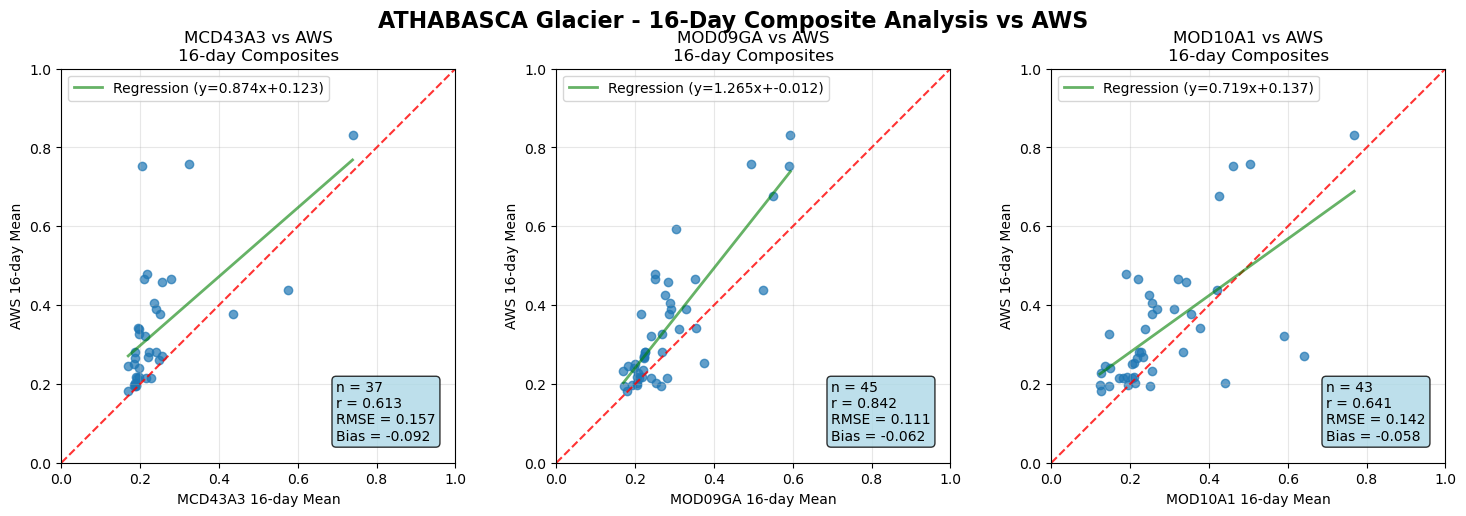


16-day composite analysis results for ATHABASCA:

MCD43A3:
  Valid 16-day periods: 37
  Correlation: 0.613
  RMSE: 0.157
  MAE: 0.104
  Bias: -0.092

MOD09GA:
  Valid 16-day periods: 45
  Correlation: 0.842
  RMSE: 0.111
  MAE: 0.082
  Bias: -0.062

MOD10A1:
  Valid 16-day periods: 43
  Correlation: 0.641
  RMSE: 0.142
  MAE: 0.107
  Bias: -0.058


In [10]:
# Create comprehensive 16-day analysis visualization
fig, axes = plt.subplots(1, len(composite_stats), figsize=(5*len(composite_stats), 5))
if len(composite_stats) == 1:
    axes = [axes]

fig.suptitle(f'{GLACIER.upper()} Glacier - 16-Day Composite Analysis vs AWS', fontsize=16, fontweight='bold')

for i, (method, stats_dict) in enumerate(composite_stats.items()):
    if stats_dict['n_periods'] > 0:
        data = stats_dict['data']
        method_col = f'{method}_mean'
        aws_col = 'AWS_mean'
        
        # Scatter plot
        ax = axes[i]
        ax.scatter(data[method_col], data[aws_col], alpha=0.7)
        ax.plot([0, 1], [0, 1], 'r--', alpha=0.8)
        
        # Add regression line
        x = data[method_col]
        y = data[aws_col]
        slope = stats_dict['slope']
        intercept = stats_dict['intercept']
        x_range = np.linspace(x.min(), x.max(), 100)
        y_pred = slope * x_range + intercept
        ax.plot(x_range, y_pred, 'g-', linewidth=2, alpha=0.6, label=f'Regression (y={slope:.3f}x+{intercept:.3f})')
        
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xlabel(f'{method} 16-day Mean')
        ax.set_ylabel('AWS 16-day Mean')
        ax.set_title(f'{method} vs AWS\n16-day Composites')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper left')
        ax.set_aspect('equal')  # Keep scatter plots square
        
        # Statistics text
        stats_text = (f"n = {stats_dict['n_periods']}\n"
                     f"r = {stats_dict['r']:.3f}\n"
                     f"RMSE = {stats_dict['rmse']:.3f}\n"
                     f"Bias = {stats_dict['bias']:.3f}")
        ax.text(0.95, 0.05, stats_text, transform=ax.transAxes,
                verticalalignment='bottom', horizontalalignment='right', 
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
                multialignment='left')
    else:
        axes[i].text(0.5, 0.5, f'No valid data\nfor {method}', 
                    ha='center', va='center', transform=axes[i].transAxes)

plt.tight_layout()
plt.savefig(out('16day_composite_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n16-day composite analysis results for {GLACIER.upper()}:")
for method, stats_dict in composite_stats.items():
    if stats_dict['n_periods'] > 0:
        print(f"\n{method}:")
        print(f"  Valid 16-day periods: {stats_dict['n_periods']}")
        print(f"  Correlation: {stats_dict['r']:.3f}")
        print(f"  RMSE: {stats_dict['rmse']:.3f}")
        print(f"  MAE: {stats_dict['mae']:.3f}")
        print(f"  Bias: {stats_dict['bias']:.3f}")
    else:
        print(f"\n{method}: No valid data for 16-day composite analysis")

## Weekly Composite Analysis

This section performs a weekly (7-day) composite analysis to compare with the 16-day approach.


In [11]:
# Weekly Composite Analysis (Target months: Jun-Sep) - CALCULATE STATISTICS
import scipy.stats as scipy_stats

# Debug: Check merged structure and add temporal columns if needed
print("Available columns in merged:", merged.columns.tolist())
print("Merged shape:", merged.shape)

# Add temporal columns if they don't exist
if 'month' not in merged.columns:
    merged = merged.reset_index()
    merged['year'] = merged['date'].dt.year
    merged['month'] = merged['date'].dt.month  
    merged['week'] = merged['date'].dt.isocalendar().year.astype(str) + '-W' + merged['date'].dt.isocalendar().week.astype(str).str.zfill(2)
    merged['doy'] = merged['date'].dt.dayofyear
    print("✓ Added temporal columns")

# Set target months for ablation season (Jun-Sep: 6-9)
target_months = [6, 7, 8, 9]

# Create weekly composites with helper function
def make_weekly_composite(method_names):
    weekly_data = merged[merged['month'].isin(target_months)].groupby('week').agg({
        **{f'{m}': 'mean' for m in method_names}, 'AWS': 'mean'
    }).reset_index()
    # Create year column for easier datetime conversion
    weekly_data['year'] = weekly_data['week'].str[:4].astype(int)
    weekly_data['week_num'] = weekly_data['week'].str[6:].astype(int)
    return weekly_data

composite_weekly = make_weekly_composite(['MCD43A3', 'MOD09GA', 'MOD10A1'])
print(f"Weekly composite periods: {len(composite_weekly)}")

# Calculate enhanced statistics for weekly composites
weekly_stats = {}
for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    aws_col = 'AWS'
    valid_data = composite_weekly[[method, aws_col]].dropna()
    
    if len(valid_data) > 0:
        x, y = valid_data[method], valid_data[aws_col]
        r, p = scipy_stats.pearsonr(x, y)
        
        # Basic statistics
        diff = x - y
        abs_diff = np.abs(diff)
        rel_diff = diff / y * 100  # Relative difference in %
        
        # Regression analysis
        slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(x, y)
        
        # Outlier detection (values > 2 standard deviations)
        z_scores = np.abs(scipy_stats.zscore(diff))
        outliers = z_scores > 2
        n_outliers = np.sum(outliers)
        
        # Additional metrics
        weekly_stats[method] = {
            # Sample size
            'n_periods': len(valid_data),
            'n_outliers': n_outliers,
            'outlier_pct': (n_outliers / len(valid_data)) * 100,
            
            # Correlation metrics
            'r': r, 'p': p, 'r_squared': r**2,
            
            # Error metrics
            'rmse': np.sqrt(np.mean(diff**2)),
            'mae': np.mean(abs_diff),
            'bias': np.mean(diff),
            'med_abs_error': np.median(abs_diff),
            'std_error': np.std(diff),
            
            # Relative metrics
            'mean_rel_bias': np.mean(rel_diff),
            'mean_abs_rel_error': np.mean(np.abs(rel_diff)),
            
            # Regression metrics
            'slope': slope,
            'intercept': intercept,
            'slope_stderr': std_err,
            
            # Range and distribution
            'sat_mean': np.mean(x), 'sat_std': np.std(x),
            'aws_mean': np.mean(y), 'aws_std': np.std(y),
            'sat_range': np.ptp(x), 'aws_range': np.ptp(y),
            
            # Agreement metrics
            'within_5pct': np.sum(np.abs(rel_diff) <= 5) / len(valid_data) * 100,
            'within_10pct': np.sum(np.abs(rel_diff) <= 10) / len(valid_data) * 100,
            'within_15pct': np.sum(np.abs(rel_diff) <= 15) / len(valid_data) * 100,
            
            'data': valid_data
        }

# Add quarterly breakdown calculation
weekly_months = []
for _, row in composite_weekly.iterrows():
    week_num = row['week_num']
    year = row['year']
    # Approximate month from week number (rough estimate)
    if week_num <= 13:
        month = 'Q1'
    elif week_num <= 26:
        month = 'Q2' 
    elif week_num <= 39:
        month = 'Q3'
    else:
        month = 'Q4'
    weekly_months.append(month)

composite_weekly['quarter'] = weekly_months
quarterly_counts = composite_weekly['quarter'].value_counts()

print(f"✓ Calculated enhanced statistics for {len(weekly_stats)} methods")

Available columns in merged: ['MCD43A3', 'MOD09GA', 'MOD10A1', 'AWS', 'glacier_fraction_MCD43A3', 'glacier_fraction_MOD09GA', 'glacier_fraction_MOD10A1', 'glacier_fraction', 'solar_zenith_MCD43A3', 'solar_zenith_MOD09GA', 'solar_zenith_MOD10A1', 'solar_zenith', 'ndsi_MCD43A3', 'ndsi_MOD09GA', 'ndsi_MOD10A1', 'ndsi', 'pixel_id_MCD43A3', 'pixel_id_MOD09GA', 'pixel_id_MOD10A1', 'pixel_id']
Merged shape: (515, 20)
✓ Added temporal columns
Weekly composite periods: 106
✓ Calculated enhanced statistics for 3 methods


In [12]:
# Weekly Composite Analysis - DISPLAY RESULTS
print("\n=== WEEKLY COMPOSITE VALIDATION SUMMARY ===\n")

# Create detailed statistics table
stats_table = []
for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    if method in weekly_stats:
        s = weekly_stats[method]
        stats_table.append([
            method,
            s['n_periods'],
            f"{s['r']:.3f}",
            f"{s['r_squared']:.3f}",
            f"{s['p']:.2e}" if s['p'] < 0.001 else f"{s['p']:.3f}",
            f"{s['rmse']:.3f}",
            f"{s['mae']:.3f}",
            f"{s['bias']:.3f}",
            f"{s['mean_abs_rel_error']:.1f}%",
            f"{s['within_10pct']:.1f}%"
        ])

# Print formatted table
headers = ['Method', 'N', 'R', 'R²', 'p-value', 'RMSE', 'MAE', 'Bias', 'MARE%', 'Within±10%']
col_widths = [8, 4, 6, 6, 8, 6, 6, 7, 7, 10]

print(" ".join(h.ljust(w) for h, w in zip(headers, col_widths)))
print("-" * sum(col_widths) + "-" * (len(col_widths) - 1))
for row in stats_table:
    print(" ".join(str(val).ljust(w) for val, w in zip(row, col_widths)))

print("\n=== DETAILED STATISTICS BY METHOD ===")
for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    if method in weekly_stats:
        s = weekly_stats[method]
        print(f"\n{method}:")
        print(f"  Sample size: {s['n_periods']} weekly periods")
        print(f"  Correlation: r={s['r']:.3f}, R²={s['r_squared']:.3f}, p={s['p']:.3e}")
        print(f"  Error metrics: RMSE={s['rmse']:.3f}, MAE={s['mae']:.3f}, Bias={s['bias']:.3f}")
        print(f"  Relative error: {s['mean_abs_rel_error']:.1f}% (MARE), {s['mean_rel_bias']:.1f}% (bias)")
        print(f"  Regression: slope={s['slope']:.3f}±{s['slope_stderr']:.3f}, intercept={s['intercept']:.3f}")
        print(f"  Agreement: {s['within_5pct']:.1f}% within ±5%, {s['within_10pct']:.1f}% within ±10%, {s['within_15pct']:.1f}% within ±15%")
        print(f"  Data ranges: Satellite [{s['sat_mean']:.3f}±{s['sat_std']:.3f}], AWS [{s['aws_mean']:.3f}±{s['aws_std']:.3f}]")
        print(f"  Outliers: {s['n_outliers']}/{s['n_periods']} ({s['outlier_pct']:.1f}%) beyond 2σ")

print(f"\nQuarterly breakdown: {', '.join([f'{q}: {count}' for q, count in quarterly_counts.items()])}")

# Print key insights
if weekly_stats:
    print("\n=== KEY INSIGHTS ===")
    best_r = max(weekly_stats.keys(), key=lambda k: weekly_stats[k]['r'])
    best_rmse = min(weekly_stats.keys(), key=lambda k: weekly_stats[k]['rmse'])
    best_agreement = max(weekly_stats.keys(), key=lambda k: weekly_stats[k]['within_10pct'])

    print(f"• Best correlation: {best_r} (r={weekly_stats[best_r]['r']:.3f})")
    print(f"• Lowest RMSE: {best_rmse} ({weekly_stats[best_rmse]['rmse']:.3f})")
    print(f"• Best agreement: {best_agreement} ({weekly_stats[best_agreement]['within_10pct']:.1f}% within ±10%)")

    # Performance ranking
    print(f"\n• Performance ranking (by R²): ", end="")
    ranked_methods = sorted(weekly_stats.keys(), key=lambda k: weekly_stats[k]['r_squared'], reverse=True)
    print(" > ".join([f"{m} ({weekly_stats[m]['r_squared']:.3f})" for m in ranked_methods]))


=== WEEKLY COMPOSITE VALIDATION SUMMARY ===

Method   N    R      R²     p-value  RMSE   MAE    Bias    MARE%   Within±10%
-----------------------------------------------------------------------------
MCD43A3  69   0.574  0.329  2.52e-07 0.161  0.109  -0.088  27.3%   30.4%     
MOD09GA  85   0.624  0.390  1.71e-10 0.126  0.087  -0.048  25.2%   22.4%     
MOD10A1  70   0.723  0.522  1.64e-12 0.134  0.103  -0.060  31.2%   12.9%     

=== DETAILED STATISTICS BY METHOD ===

MCD43A3:
  Sample size: 69 weekly periods
  Correlation: r=0.574, R²=0.329, p=2.519e-07
  Error metrics: RMSE=0.161, MAE=0.109, Bias=-0.088
  Relative error: 27.3% (MARE), -20.2% (bias)
  Regression: slope=0.763±0.133, intercept=0.146
  Agreement: 10.1% within ±5%, 30.4% within ±10%, 34.8% within ±15%
  Data ranges: Satellite [0.246±0.120], AWS [0.334±0.160]
  Outliers: 5/69 (7.2%) beyond 2σ

MOD09GA:
  Sample size: 85 weekly periods
  Correlation: r=0.624, R²=0.390, p=1.712e-10
  Error metrics: RMSE=0.126, MAE=0.087, 

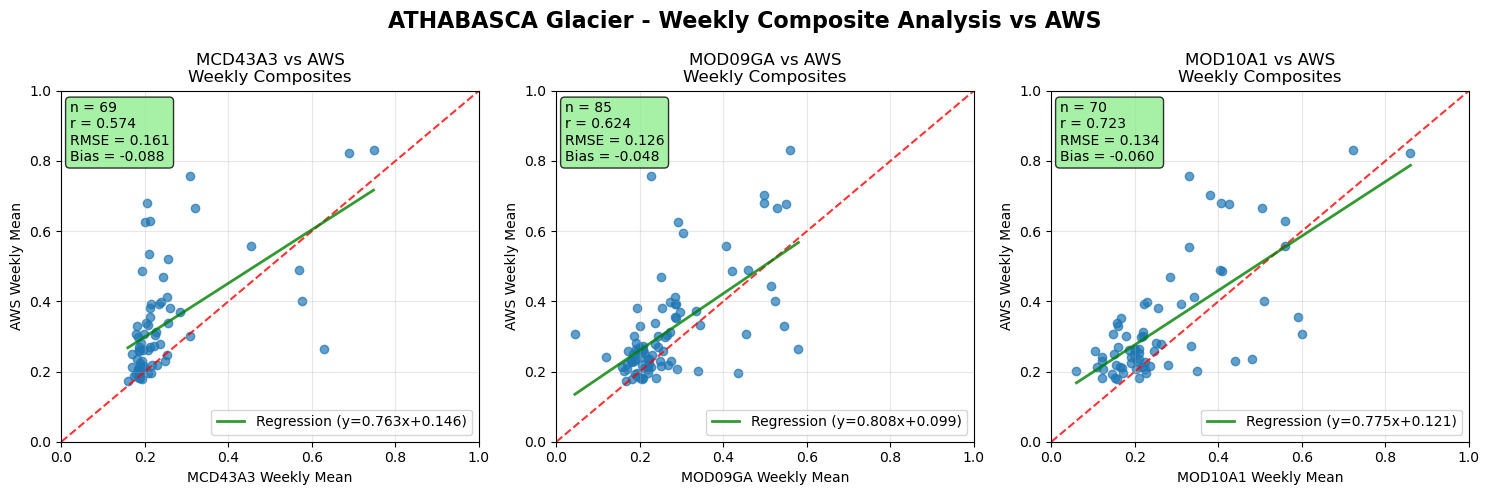

In [13]:
# Create comprehensive weekly analysis visualization
fig, axes = plt.subplots(1, len(weekly_stats), figsize=(5*len(weekly_stats), 5))
if len(weekly_stats) == 1:
    axes = [axes]

fig.suptitle(f'{GLACIER.upper()} Glacier - Weekly Composite Analysis vs AWS', fontsize=16, fontweight='bold')

for i, (method, stats_dict) in enumerate(weekly_stats.items()):
    if stats_dict['n_periods'] > 0 and 'data' in stats_dict and stats_dict['data'] is not None:
        data = stats_dict['data']
        # Use the actual column names from the data
        method_col = method  # Just the method name, not with '_mean'
        aws_col = 'AWS'     # Just 'AWS', not 'AWS_mean'
        
        # Scatter plot
        ax1 = axes[i]
        ax1.scatter(data[method_col], data[aws_col], alpha=0.7)
        ax1.plot([0, 1], [0, 1], 'r--', alpha=0.8)
        
        # Add regression line
        x = data[method_col]
        y = data[aws_col]
        slope = stats_dict['slope']
        intercept = stats_dict['intercept']
        x_range = np.linspace(x.min(), x.max(), 100)
        y_pred = slope * x_range + intercept
        ax1.plot(x_range, y_pred, 'g-', linewidth=2, alpha=0.8, label=f'Regression (y={slope:.3f}x+{intercept:.3f})')
        
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.set_xlabel(f'{method} Weekly Mean')
        ax1.set_ylabel('AWS Weekly Mean')
        ax1.set_title(f'{method} vs AWS\nWeekly Composites')
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc='lower right')
        
        # Statistics text
        stats_text = (f"n = {stats_dict['n_periods']}\n"
                     f"r = {stats_dict['r']:.3f}\n"
                     f"RMSE = {stats_dict['rmse']:.3f}\n"
                     f"Bias = {stats_dict['bias']:.3f}")
        ax1.text(0.02, 0.97, stats_text, transform=ax1.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    else:
        axes[i].text(0.5, 0.5, f'No valid data\nfor {method}', 
                       ha='center', va='center', transform=axes[i].transAxes)

plt.tight_layout()
plt.savefig(f'exports/{GLACIER}_weekly_composite_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


## Monthly Analysis by Method

This section analyzes albedo patterns by month to understand seasonal variations and how different MODIS methods perform across different times of the year. 

### 1. Calculate statistics

In [14]:
# ==============================================================================
# MONTHLY STATISTICS BY METHOD - CALCULATE STATISTICS
# ==============================================================================

from scipy import stats as scipy_stats  # Rename to avoid conflict

# First, let's check if merged has a date column and set it as index if needed
if 'date' in merged.columns and not isinstance(merged.index, pd.DatetimeIndex):
    merged = merged.set_index('date')

# Extract month from index (now it should be a DatetimeIndex)
merged['month'] = merged.index.month
target_months = [6, 7, 8, 9]  # June, July, August, September
months = merged['month']

print("MONTHLY STATISTICS BY METHOD")
print("="*50)

monthly_stats = {}
for month in target_months:
    month_mask = months == month
    month_data = merged[month_mask]
    
    for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
        if method in merged.columns:
            valid_data = month_data[[method, 'AWS']].dropna()
            
            if len(valid_data) >= 5:  # Minimum 5 observations
                x = valid_data[method]
                y = valid_data['AWS']
                
                # Basic correlation
                r, p = scipy_stats.pearsonr(x, y)
                
                # Basic statistics
                diff = x - y
                abs_diff = np.abs(diff)
                rel_diff = diff / y * 100  # Relative difference in %
                
                # Regression analysis
                slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(x, y)
                
                # Outlier detection (values > 2 standard deviations)
                z_scores = np.abs(scipy_stats.zscore(diff))
                outliers = z_scores > 2
                n_outliers = np.sum(outliers)
                
                # Store comprehensive statistics
                monthly_stats[f"{month}_{method}"] = {
                    # Sample size and outliers
                    'month': month,
                    'method': method,
                    'n': len(valid_data),
                    'n_outliers': n_outliers,
                    'outlier_pct': (n_outliers / len(valid_data)) * 100,
                    
                    # Correlation metrics
                    'r': r, 'p': p, 'r_squared': r**2,
                    
                    # Error metrics
                    'rmse': np.sqrt(np.mean(diff**2)),
                    'mae': np.mean(abs_diff),
                    'bias': np.mean(diff),
                    'med_abs_error': np.median(abs_diff),
                    'std_error': np.std(diff),
                    
                    # Relative metrics
                    'mean_rel_bias': np.mean(rel_diff),
                    'mean_abs_rel_error': np.mean(np.abs(rel_diff)),
                    
                    # Regression metrics
                    'slope': slope,
                    'intercept': intercept,
                    'slope_stderr': std_err,
                    
                    # Range and distribution
                    'sat_mean': np.mean(x), 'sat_std': np.std(x),
                    'aws_mean': np.mean(y), 'aws_std': np.std(y),
                    'sat_range': np.ptp(x), 'aws_range': np.ptp(y),
                    
                    # Agreement metrics
                    'within_5pct': np.sum(np.abs(rel_diff) <= 5) / len(valid_data) * 100,
                    'within_10pct': np.sum(np.abs(rel_diff) <= 10) / len(valid_data) * 100,
                    'within_15pct': np.sum(np.abs(rel_diff) <= 15) / len(valid_data) * 100,
                    
                    'data': valid_data
                }

print(f"✓ Calculated monthly statistics for {len(monthly_stats)} method-month combinations")

MONTHLY STATISTICS BY METHOD
✓ Calculated monthly statistics for 12 method-month combinations


### 2. Display Statistics

In [15]:
# ==============================================================================
# MONTHLY STATISTICS BY METHOD - DISPLAY RESULTS
# ==============================================================================

# Create comprehensive monthly statistics table
print("\n=== MONTHLY VALIDATION SUMMARY ===\n")

# Create detailed statistics table by month
month_names = {6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep'}

# Print headers
headers = ['Month', 'Method', 'N', 'R', 'R²', 'p-value', 'RMSE', 'MAE', 'Bias', 'MARE%', 'Within±10%']
col_widths = [6, 8, 4, 6, 6, 8, 6, 6, 7, 7, 10]

print(" ".join(h.ljust(w) for h, w in zip(headers, col_widths)))
print("-" * sum(col_widths) + "-" * (len(col_widths) - 1))

# Print statistics for each month and method
for month in target_months:
    for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
        key = f"{month}_{method}"
        if key in monthly_stats:
            s = monthly_stats[key]
            row = [
                month_names[month],
                method,
                s['n'],
                f"{s['r']:.3f}",
                f"{s['r_squared']:.3f}",
                f"{s['p']:.2e}" if s['p'] < 0.001 else f"{s['p']:.3f}",
                f"{s['rmse']:.3f}",
                f"{s['mae']:.3f}",
                f"{s['bias']:.3f}",
                f"{s['mean_abs_rel_error']:.1f}%",
                f"{s['within_10pct']:.1f}%"
            ]
            print(" ".join(str(val).ljust(w) for val, w in zip(row, col_widths)))

print(f"\n=== DETAILED STATISTICS BY MONTH ===")

# Summary by month
for month in target_months:
    month_name = month_names[month]
    print(f"\n{month_name.upper()} ({month}):")
    print("-" * 30)
    
    month_methods = {k: v for k, v in monthly_stats.items() if v['month'] == month}
    
    if month_methods:
        # Find best performing method for this month
        best_r = max(month_methods.values(), key=lambda x: x['r'])
        best_rmse = min(month_methods.values(), key=lambda x: x['rmse'])
        best_agreement = max(month_methods.values(), key=lambda x: x['within_10pct'])
        
        print(f"• Best correlation: {best_r['method']} (r={best_r['r']:.3f})")
        print(f"• Lowest RMSE: {best_rmse['method']} ({best_rmse['rmse']:.3f})")
        print(f"• Best agreement: {best_agreement['method']} ({best_agreement['within_10pct']:.1f}% within ±10%)")
        
        # Performance ranking for this month
        ranked_methods = sorted(month_methods.values(), key=lambda x: x['r_squared'], reverse=True)
        print(f"• Performance ranking (by R²): ", end="")
        print(" > ".join([f"{m['method']} ({m['r_squared']:.3f})" for m in ranked_methods]))

print(f"\nAnalyzed months: June-September")
print(f"Total observations across all methods and months: {len(merged[merged['month'].isin(target_months)])}")
print(f"Statistics computed with minimum 5 observations per method per month")


=== MONTHLY VALIDATION SUMMARY ===

Month  Method   N    R      R²     p-value  RMSE   MAE    Bias    MARE%   Within±10%
------------------------------------------------------------------------------------
Jun    MCD43A3  54   0.089  0.008  0.521    0.217  0.153  -0.133  34.2%   14.8%     
Jun    MOD09GA  27   0.552  0.304  0.003    0.119  0.080  -0.011  27.0%   18.5%     
Jun    MOD10A1  22   0.494  0.244  0.019    0.153  0.112  0.010   36.3%   27.3%     
Jul    MCD43A3  100  0.151  0.023  0.133    0.070  0.052  -0.047  19.1%   32.0%     
Jul    MOD09GA  69   0.363  0.132  0.002    0.075  0.048  -0.012  21.3%   31.9%     
Jul    MOD10A1  28   0.074  0.005  0.708    0.124  0.088  -0.029  37.3%   14.3%     
Aug    MCD43A3  115  0.596  0.355  2.07e-12 0.095  0.057  -0.022  20.5%   34.8%     
Aug    MOD09GA  95   0.363  0.132  3.01e-04 0.121  0.068  -0.000  30.4%   27.4%     
Aug    MOD10A1  39   0.829  0.686  7.47e-11 0.076  0.063  -0.046  26.8%   12.8%     
Sep    MCD43A3  63   0.704  

### 3. Plots Visualization

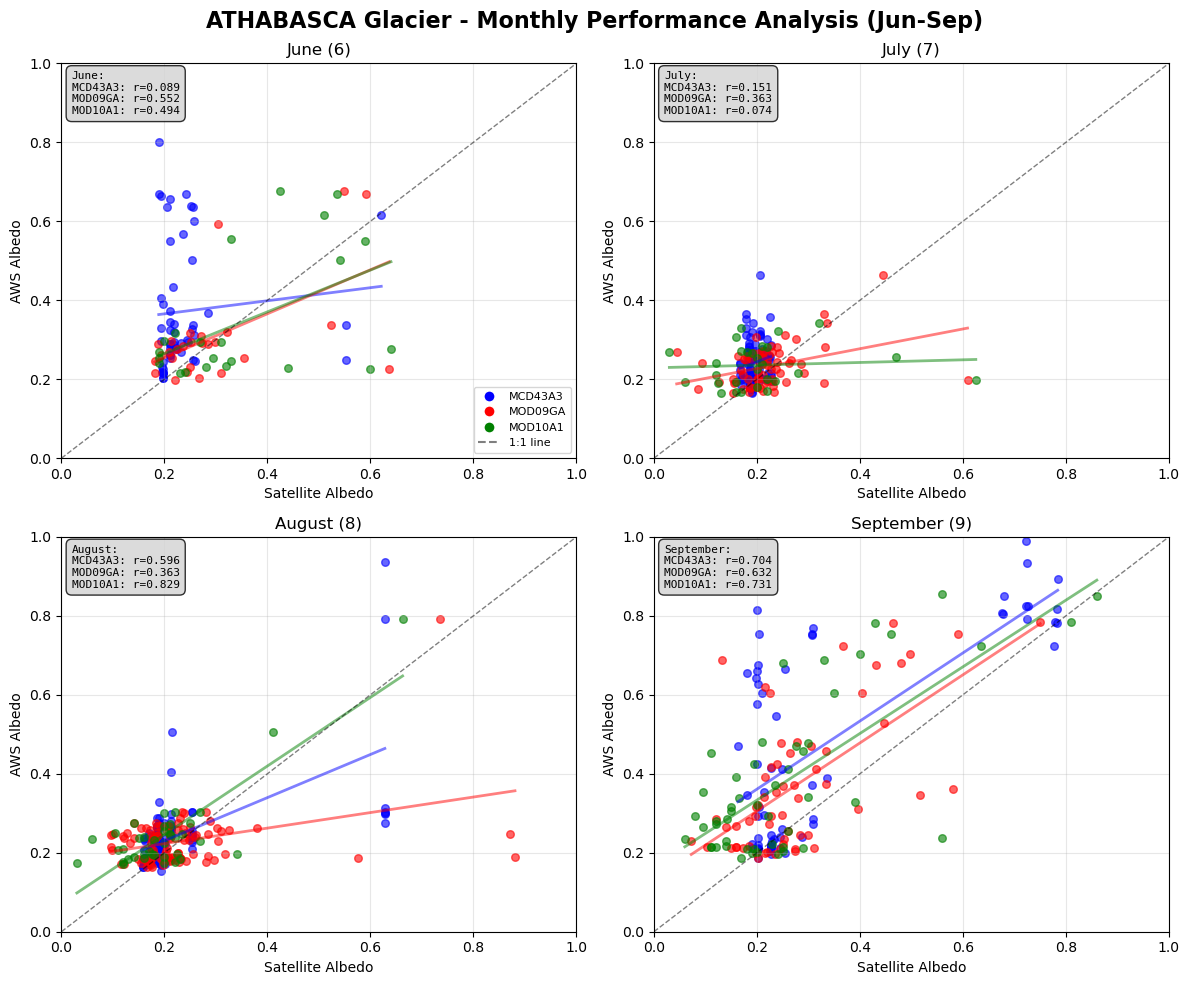

✓ Monthly scatter plots with embedded statistics saved to exports directory
  - athabasca_monthly_scatter_with_stats.png


In [16]:
# ==============================================================================
# MONTHLY VISUALIZATION PLOTS
# ==============================================================================

# Create monthly scatter plots with embedded statistics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle(f'{GLACIER.upper()} Glacier - Monthly Performance Analysis (Jun-Sep)', fontsize=16, fontweight='bold')

month_names = {6: 'June', 7: 'July', 8: 'August', 9: 'September'}
methods = ['MCD43A3', 'MOD09GA', 'MOD10A1']
method_colors = {'MCD43A3': 'blue', 'MOD09GA': 'red', 'MOD10A1': 'green'}

# Scatter plots for each month with embedded statistics
for i, month in enumerate(target_months):
    row, col = i // 2, i % 2
    ax = axes[row, col]
    month_name = month_names[month]
    
    # Get data for this month
    month_mask = merged['month'] == month
    month_data = merged[month_mask]
    
    # Plot data for each method
    legend_elements = []
    stats_text = f"{month_name}:\n"
    
    for j, method in enumerate(methods):
        if method in merged.columns:
            valid_data = month_data[[method, 'AWS']].dropna()
            if len(valid_data) > 0:
                # Plot scatter points
                ax.scatter(valid_data[method], valid_data['AWS'], 
                          alpha=0.6, label=method, color=method_colors[method], s=30)
                
                # Get statistics for this method and month
                key = f"{month}_{method}"
                if key in monthly_stats:
                    stats = monthly_stats[key]
                    
                    # Plot regression line only over the data range
                    x_min, x_max = valid_data[method].min(), valid_data[method].max()
                    x_range = np.linspace(x_min, x_max, 50)
                    y_pred = stats['slope'] * x_range + stats['intercept']
                    ax.plot(x_range, y_pred, color=method_colors[method], 
                           linestyle='-', linewidth=2, alpha=0.5)
                    
                    # Add only correlation coefficient
                    stats_line = f"{method}: r={stats['r']:.3f}"
                    stats_text += f"{stats_line}\n"
    
    # Add 1:1 line
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1, label='1:1 line')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Satellite Albedo')
    ax.set_ylabel('AWS Albedo')
    ax.set_title(f'{month_name} ({month})')
    ax.grid(True, alpha=0.3)
    
    # Add statistics text box
    ax.text(0.02, 0.98, stats_text.strip(), transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8),
            fontsize=8, family='monospace')
    
    # Add method legend only for the first plot (top-left)
    if i == 0:
        # Create legend with just method colors
        method_legend = [plt.Line2D([0], [0], marker='o', color='w', 
                                   markerfacecolor=method_colors[method], markersize=8, label=method)
                        for method in methods]
        method_legend.append(plt.Line2D([0], [0], color='k', linestyle='--', alpha=0.5, label='1:1 line'))
        ax.legend(handles=method_legend, loc='lower right', fontsize=8)

plt.tight_layout()
plt.savefig(EXPORT_DIR / f'{GLACIER}_monthly_scatter_with_stats.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Monthly scatter plots with embedded statistics saved to exports directory")
print(f"  - {GLACIER}_monthly_scatter_with_stats.png")

## Spatial Analysis: Pixel-Level Comparisons and Map


### Part 1: Multi-Method Pixel Matching

This analysis identifies pixels where multiple MODIS methods (MCD43A3, MOD09GA, MOD10A1) have simultaneous observations, enabling direct method-to-method comparisons at identical spatial and temporal coordinates.

In [17]:
# ===============================================================================
# PIXEL-LEVEL COMPARISON (MOD09GA vs MOD10A1 vs MCD43A3)
# ===============================================================================

# Filter for MOD09GA, MOD10A1, and MCD43A3 only
mod_data = modis[modis['method'].isin(['MOD09GA', 'MOD10A1', 'MCD43A3'])].copy()

# Find matching observations (same date and pixel_id)
mod09_data = mod_data[mod_data['method'] == 'MOD09GA'][['date', 'pixel_id', 'albedo']]
mod10_data = mod_data[mod_data['method'] == 'MOD10A1'][['date', 'pixel_id', 'albedo']]
mcd43a3_data = mod_data[mod_data['method'] == 'MCD43A3'][['date', 'pixel_id', 'albedo']]

# Merge MOD09GA and MOD10A1 on exact date and pixel_id matches
pixel_matched_09_10 = pd.merge(mod09_data, mod10_data, on=['date', 'pixel_id'], suffixes=('_MOD09GA', '_MOD10A1'))

# Merge all three (inner join: only dates/pixels present in all three)
pixel_matched_all = pd.merge(pixel_matched_09_10, mcd43a3_data, on=['date', 'pixel_id'])
pixel_matched_all = pixel_matched_all.rename(columns={'albedo': 'albedo_MCD43A3'})

print(f"Found {len(pixel_matched_09_10)} matching observations between MOD09GA and MOD10A1")
if len(pixel_matched_09_10) > 0:
    print(f"Date range: {pixel_matched_09_10['date'].min()} to {pixel_matched_09_10['date'].max()}")
    print(f"Unique pixels: {pixel_matched_09_10['pixel_id'].nunique()}")
    print(f"Pixel IDs: {sorted(pixel_matched_09_10['pixel_id'].unique())}")
else:
    print("No matching observations found for same date and pixel_id (MOD09GA vs MOD10A1)")

print(f"\nFound {len(pixel_matched_all)} matching observations between MOD09GA, MOD10A1, and MCD43A3")
if len(pixel_matched_all) > 0:
    print(f"Date range: {pixel_matched_all['date'].min()} to {pixel_matched_all['date'].max()}")
    print(f"Unique pixels: {pixel_matched_all['pixel_id'].nunique()}")
    print(f"Pixel IDs: {sorted(pixel_matched_all['pixel_id'].unique())}")
else:
    print("No matching observations found for same date and pixel_id (all three products)")

Found 160 matching observations between MOD09GA and MOD10A1
Date range: 2014-06-01 00:00:00 to 2020-09-30 00:00:00
Unique pixels: 2
Pixel IDs: [np.int64(9073025950), np.int64(9075025945)]

Found 64 matching observations between MOD09GA, MOD10A1, and MCD43A3
Date range: 2014-06-01 00:00:00 to 2020-09-27 00:00:00
Unique pixels: 2
Pixel IDs: [np.int64(9073025950), np.int64(9075025945)]


### Part 2: AWS Station Integration

This section processes the AWS (Automatic Weather Station) ground truth data, extracts station coordinates, and attempts to link AWS measurements with MODIS satellite observations at the same geographic location.

In [18]:
# Process pixel AWS data to match the MODIS data structure
from scipy import stats as scipy_stats  # Rename to avoid conflict

# Get AWS coordinates from the spatial points (from shapefile)
if len(aws_points) > 0:
    aws_lat = aws_points.iloc[0]['latitude']
    aws_lon = aws_points.iloc[0]['longitude']
    
    # Create AWS pixel data structure
    pixel_aws = pd.DataFrame({
        'lat': [aws_lat],
        'lon': [aws_lon],
        'AWS': [aws['Albedo'].mean()]  # Use mean albedo as representative value
    })
    
    print(f"AWS station coordinates: lat={aws_lat:.6f}, lon={aws_lon:.6f}")
    print(f"AWS mean albedo: {aws['Albedo'].mean():.3f}")

    # If pixel_id for AWS is known, compare all three products at that pixel
    if 'pixel_id' in aws and 'date' in aws:
        # Find all MODIS products at AWS pixel and dates
        aws_pixel_id = aws['pixel_id'].iloc[0] if 'pixel_id' in aws.columns else None
        if aws_pixel_id is not None:
            aws_dates = aws['date'].unique() if 'date' in aws.columns else []
            for date in aws_dates:
                row = {'date': date}
                for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
                    val = modis[(modis['pixel_id'] == aws_pixel_id) & (modis['date'] == date) & (modis['method'] == method)]['albedo_value']
                    row[method] = val.iloc[0] if not val.empty else None
                row['AWS'] = aws[aws['date'] == date]['Albedo'].iloc[0] if not aws[aws['date'] == date].empty else None
                print(row)
else:
    print("No AWS points found.")

AWS station coordinates: lat=52.191833, lon=-117.251639
AWS mean albedo: 0.610


### Part 3: Spatial Visualization and Geographic Context

This comprehensive map integrates results from Parts 1 and 2, showing the spatial distribution of MODIS pixels (colored by method availability), AWS station location, and glacier mask boundary. This visualization reveals the geographic context that explains why certain method comparisons perform better or worse.

(<Figure size 1400x1000 with 1 Axes>,
 <Axes: title={'center': 'ATHABASCA Glacier - Scientific Pixel Map\nMODIS Pixels, AWS Station, and Sentinel-2 Basemap'}, xlabel='Longitude (°E)', ylabel='Latitude (°N)'>)

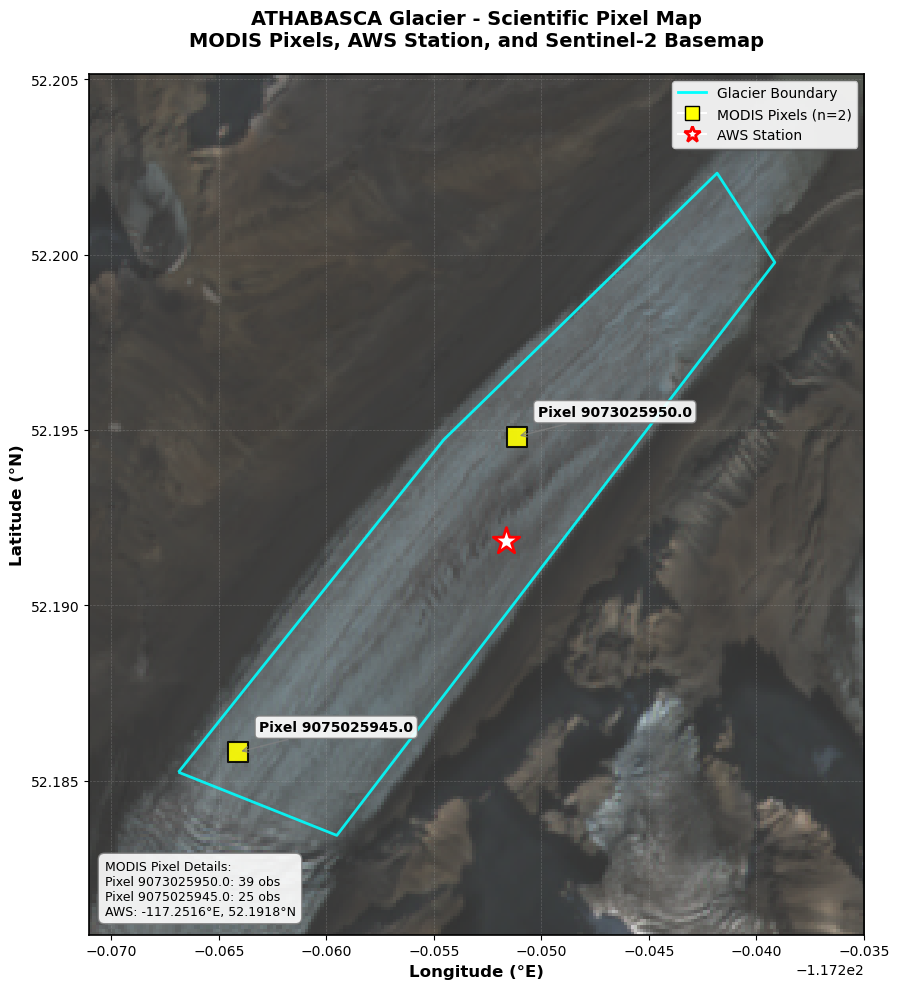

In [19]:
def create_scientific_pixel_map():
    """Create a scientific pixel map with Sentinel-2 basemap, MODIS pixels, and AWS station."""
    
    # GeoTIFF path
    GEOTIFF = Path("data/geotiff/athabasca_glacier_larger_s2_aug2024.tif")
    
    # Create the figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    # 1) Sentinel-2 basemap ------------------------------------------------------
    if GEOTIFF.exists():
        try:
            # Read and display the GeoTIFF basemap
            with rasterio.open(GEOTIFF) as src:
                # Convert raster bounds from UTM to WGS84 (lon/lat)
                lon_min_img, lat_min_img, lon_max_img, lat_max_img = transform_bounds(
                    src.crs, "EPSG:4326", *src.bounds, densify_pts=21
                )
                
                # Read RGB bands and prepare for display
                img = src.read([1, 2, 3])  # RGB bands
                rgb = np.moveaxis(img, 0, -1)  # Move color axis to match imshow: (rows, cols, bands)
                rgb = rgb / np.clip(rgb.max(), 1, None)  # Normalize for display
                
                # Display the basemap using imshow with correct extent
                ax.imshow(
                    rgb,
                    extent=[lon_min_img, lon_max_img, lat_min_img, lat_max_img],
                    origin="upper",
                    zorder=0,
                    alpha=0.8
                )
                
                # Store bounds for map extent
                t_bounds = (lon_min_img, lat_min_img, lon_max_img, lat_max_img)
                
        except Exception as e:
            t_bounds = None
    else:
        t_bounds = None
    
    # 2) Plot glacier boundary ---------------------------------------------------
    if glacier_mask is not None and not glacier_mask.empty:
        glacier_mask.boundary.plot(ax=ax, color='cyan', linewidth=2, alpha=0.9, zorder=2)
    
    # 3) Plot MODIS pixels -------------------------------------------------------
    # Get unique pixel locations from modis dataframe
    if 'modis' in globals() and not modis.empty and 'longitude' in modis.columns and 'latitude' in modis.columns:
        unique_pixels = modis[['pixel_id', 'longitude', 'latitude']].drop_duplicates()
        
        # Plot pixels
        ax.scatter(
            unique_pixels['longitude'], unique_pixels['latitude'],
            c='yellow', s=200, marker='s', alpha=0.9,
            edgecolors='black', linewidths=1.5, zorder=4
        )
        
        # Add pixel ID labels with connecting lines
        for _, pixel in unique_pixels.iterrows():
            pixel_id = pixel['pixel_id']
            lon = pixel['longitude']
            lat = pixel['latitude']
            
            # Add annotation with pixel ID
            ax.annotate(
                f'Pixel {pixel_id}', 
                (lon, lat),
                xytext=(15, 15), 
                textcoords='offset points',
                fontsize=10, 
                fontweight='bold', 
                color='black',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, edgecolor='gray'),
                arrowprops=dict(arrowstyle='->', color='gray', lw=1, alpha=0.8),
                zorder=5
            )
        
        # Create pixel observation counts from pixel_matched_all
        pixel_info = []
        if 'pixel_matched_all' in globals():
            for _, pixel in unique_pixels.iterrows():
                pixel_id = pixel['pixel_id']
                # Count observations for this pixel
                pixel_obs = pixel_matched_all[pixel_matched_all['pixel_id'] == pixel_id]
                obs_count = len(pixel_obs) if not pixel_obs.empty else 0
                pixel_info.append(f"Pixel {pixel_id}: {obs_count} obs")
    else:
        pixel_info = []
    
    # 4) Plot AWS station --------------------------------------------------------
    if 'aws_points' in globals() and aws_points is not None and not aws_points.empty:
        ax.scatter(
            aws_points.geometry.x, aws_points.geometry.y,
            c='white', s=400, marker='*', alpha=1.0,
            edgecolors='red', linewidths=2, zorder=5
        )
        
        # Get AWS coordinates for info box
        aws_lon = aws_points.geometry.x.iloc[0]
        aws_lat = aws_points.geometry.y.iloc[0]
        aws_info = f"AWS: {aws_lon:.4f}°E, {aws_lat:.4f}°N"
    else:
        aws_info = "AWS: No coordinates available"
    
    # 5) Map styling and extent --------------------------------------------------
    # Use glacier mask bounds for map extent (prioritized)
    if glacier_mask is not None and not glacier_mask.empty:
        bounds = glacier_mask.bounds
        lon_min = bounds.minx.min()
        lon_max = bounds.maxx.max()  
        lat_min = bounds.miny.min()
        lat_max = bounds.maxy.max()
        
        # Add buffer around glacier mask
        lon_buffer = (lon_max - lon_min) * 0.15
        lat_buffer = (lat_max - lat_min) * 0.15
        ax.set_xlim(lon_min - lon_buffer, lon_max + lon_buffer)
        ax.set_ylim(lat_min - lat_buffer, lat_max + lat_buffer)
    elif t_bounds:
        # Fallback to GeoTIFF bounds if glacier mask not available
        lon_min, lat_min, lon_max, lat_max = t_bounds
        lon_buffer = (lon_max - lon_min) * 0.05
        lat_buffer = (lat_max - lat_min) * 0.05
        ax.set_xlim(lon_min - lon_buffer, lon_max + lon_buffer)
        ax.set_ylim(lat_min - lat_buffer, lat_max + lat_buffer)
    
    # Scientific styling
    ax.set_xlabel('Longitude (°E)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Latitude (°N)', fontsize=12, fontweight='bold')
    ax.set_title(
        'ATHABASCA Glacier - Scientific Pixel Map\n'
        'MODIS Pixels, AWS Station, and Sentinel-2 Basemap',
        fontsize=14, fontweight='bold', pad=20
    )
    
    # Create legend elements
    legend_elements = [
        plt.Line2D([0], [0], color='cyan', linewidth=2, label='Glacier Boundary'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='yellow', 
                  markersize=10, markeredgecolor='black', label=f'MODIS Pixels (n={len(unique_pixels) if "unique_pixels" in locals() else 0})'),
        plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='white', 
                  markersize=12, markeredgecolor='red', markeredgewidth=2, label='AWS Station')
    ]
    
    # Add legend
    legend = ax.legend(handles=legend_elements, loc='upper right', frameon=True, 
                      fancybox=True, shadow=True, fontsize=10)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    
    # Add information box
    info_text = "MODIS Pixel Details:\n" + "\n".join(pixel_info) + f"\n{aws_info}"
    ax.text(0.02, 0.02, info_text, transform=ax.transAxes, fontsize=9,
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='gray'),
            verticalalignment='bottom', horizontalalignment='left', zorder=6)
    
    # Grid and spines
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.2)
    
    # Final touches
    plt.tight_layout()
    
    # Save the plot
    if 'EXPORT_DIR' in globals():
        output_path = EXPORT_DIR / 'athabasca_scientific_pixel_map_with_basemap.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    
    return fig, ax

# Execute the function
create_scientific_pixel_map()

## Outlier Detection and Analysis

This section identifies and analyzes outliers in the albedo data using Z-score analysis (threshold > 2.5) and compares statistics with and without outliers.

### Outliers detections

In [20]:
# ==============================================================================
# OUTLIER DETECTION
# ==============================================================================
# Import scipy stats to avoid naming conflicts
from scipy import stats as scipy_stats

# Detect Z-score outliers (|z| > 2.5)
outliers = {}
outlier_counts = {}
outlier_values = {}
for col in ['MCD43A3', 'MOD09GA', 'MOD10A1', 'AWS']:
    if col in merged.columns:
        clean_data = merged[col].dropna()
        if len(clean_data) > 0:
            z = np.abs(scipy_stats.zscore(clean_data))
            outlier_mask = z > 3
            outliers[col] = pd.Series(outlier_mask, index=clean_data.index)
            outlier_counts[col] = outlier_mask.sum()
            # Store actual outlier values
            outlier_values[col] = clean_data[outlier_mask].sort_values()
        else:
            outliers[col] = pd.Series([], dtype=bool)
            outlier_counts[col] = 0
            outlier_values[col] = pd.Series([])

print("OUTLIER DETECTION RESULTS")
print("=" * 40)
for method, count in outlier_counts.items():
    total = merged[method].notna().sum() if method in merged.columns else 0
    pct = (count/total*100) if total > 0 else 0
    print(f"{method}: {count} outliers ({pct:.1f}% of {total} observations)")
print("=" * 40)

OUTLIER DETECTION RESULTS
MCD43A3: 22 outliers (5.6% of 391 observations)
MOD09GA: 8 outliers (2.7% of 294 observations)
MOD10A1: 3 outliers (1.8% of 167 observations)
AWS: 11 outliers (2.5% of 432 observations)


### Outliers statistic

In [21]:
# Calculate statistics with and without outliers (using residual-based outlier detection)
stats_with_outliers = {}
stats_without_outliers = {}

for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    if method in merged.columns:
        mask = merged[[method, 'AWS']].notna().all(axis=1)
        if mask.sum() > 0:
            x_all = merged.loc[mask, 'AWS']
            y_all = merged.loc[mask, method]
            
            # Stats with outliers
            r_all, _ = scipy_stats.pearsonr(x_all, y_all)
            rmse_all = np.sqrt(np.mean((y_all - x_all)**2))
            mae_all = np.mean(np.abs(y_all - x_all))
            bias_all = np.mean(y_all - x_all)
            stats_with_outliers[method] = {'n': len(x_all), 'r': r_all, 'rmse': rmse_all, 'mae': mae_all, 'bias': bias_all}
            
            # Remove residual outliers (better approach for correlation analysis)
            slope, intercept = np.polyfit(x_all, y_all, 1)
            predicted = slope * x_all + intercept
            residuals = y_all - predicted
            residual_threshold = 2.5 * residuals.std()
            residual_outliers = np.abs(residuals) > residual_threshold
            # Fix pandas warning by using proper boolean indexing
            outlier_series = pd.Series(residual_outliers, index=mask[mask].index).reindex(merged.index, fill_value=False)
            clean_mask = mask & ~outlier_series
            
            if clean_mask.sum() > 0:
                x_clean = merged.loc[clean_mask, 'AWS']
                y_clean = merged.loc[clean_mask, method]
                
                # Stats without outliers
                r_clean, _ = scipy_stats.pearsonr(x_clean, y_clean)
                rmse_clean = np.sqrt(np.mean((y_clean - x_clean)**2))
                mae_clean = np.mean(np.abs(y_clean - x_clean))
                bias_clean = np.mean(y_clean - x_clean)
                stats_without_outliers[method] = {'n': len(x_clean), 'r': r_clean, 'rmse': rmse_clean, 'mae': mae_clean, 'bias': bias_clean}

print("\nSTATISTICS COMPARISON (WITH vs WITHOUT OUTLIERS)")
print("=" * 55)
print(f"{'Method':<10} {'Condition':<12} {'n':<4} {'r':<6} {'RMSE':<6} {'MAE':<6} {'Bias':<6}")
print("-" * 55)

for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    if method in stats_with_outliers:
        # With outliers
        s_with = stats_with_outliers[method]
        print(f"{method:<10} {'With':<12} {s_with['n']:<4} {s_with['r']:<6.3f} {s_with['rmse']:<6.3f} {s_with['mae']:<6.3f} {s_with['bias']:<6.3f}")
        
        # Without outliers
        if method in stats_without_outliers:
            s_without = stats_without_outliers[method]
            print(f"{method:<10} {'Without':<12} {s_without['n']:<4} {s_without['r']:<6.3f} {s_without['rmse']:<6.3f} {s_without['mae']:<6.3f} {s_without['bias']:<6.3f}")
            
            # Improvement metrics
            r_improvement = ((s_without['r'] - s_with['r']) / abs(s_with['r'])) * 100 if s_with['r'] != 0 else 0
            rmse_improvement = ((s_with['rmse'] - s_without['rmse']) / s_with['rmse']) * 100 if s_with['rmse'] != 0 else 0
            print(f"{method:<10} {'Improvement':<12} {'':<4} {r_improvement:<6.1f}% {rmse_improvement:<6.1f}% {'':<6} {'':<6}")
        print()
print("=" * 55)


STATISTICS COMPARISON (WITH vs WITHOUT OUTLIERS)
Method     Condition    n    r      RMSE   MAE    Bias  
-------------------------------------------------------
MCD43A3    With         332  0.642  0.150  0.090  -0.070
MCD43A3    Without      314  0.675  0.135  0.081  -0.075
MCD43A3    Improvement       5.1   % 10.2  %              

MOD09GA    With         252  0.508  0.123  0.078  -0.028
MOD09GA    Without      245  0.717  0.093  0.067  -0.037
MOD09GA    Improvement       41.3  % 24.5  %              

MOD10A1    With         139  0.653  0.144  0.107  -0.062
MOD10A1    Without      134  0.731  0.132  0.100  -0.075
MOD10A1    Improvement       11.9  % 8.5   %              



### Outliers plotting

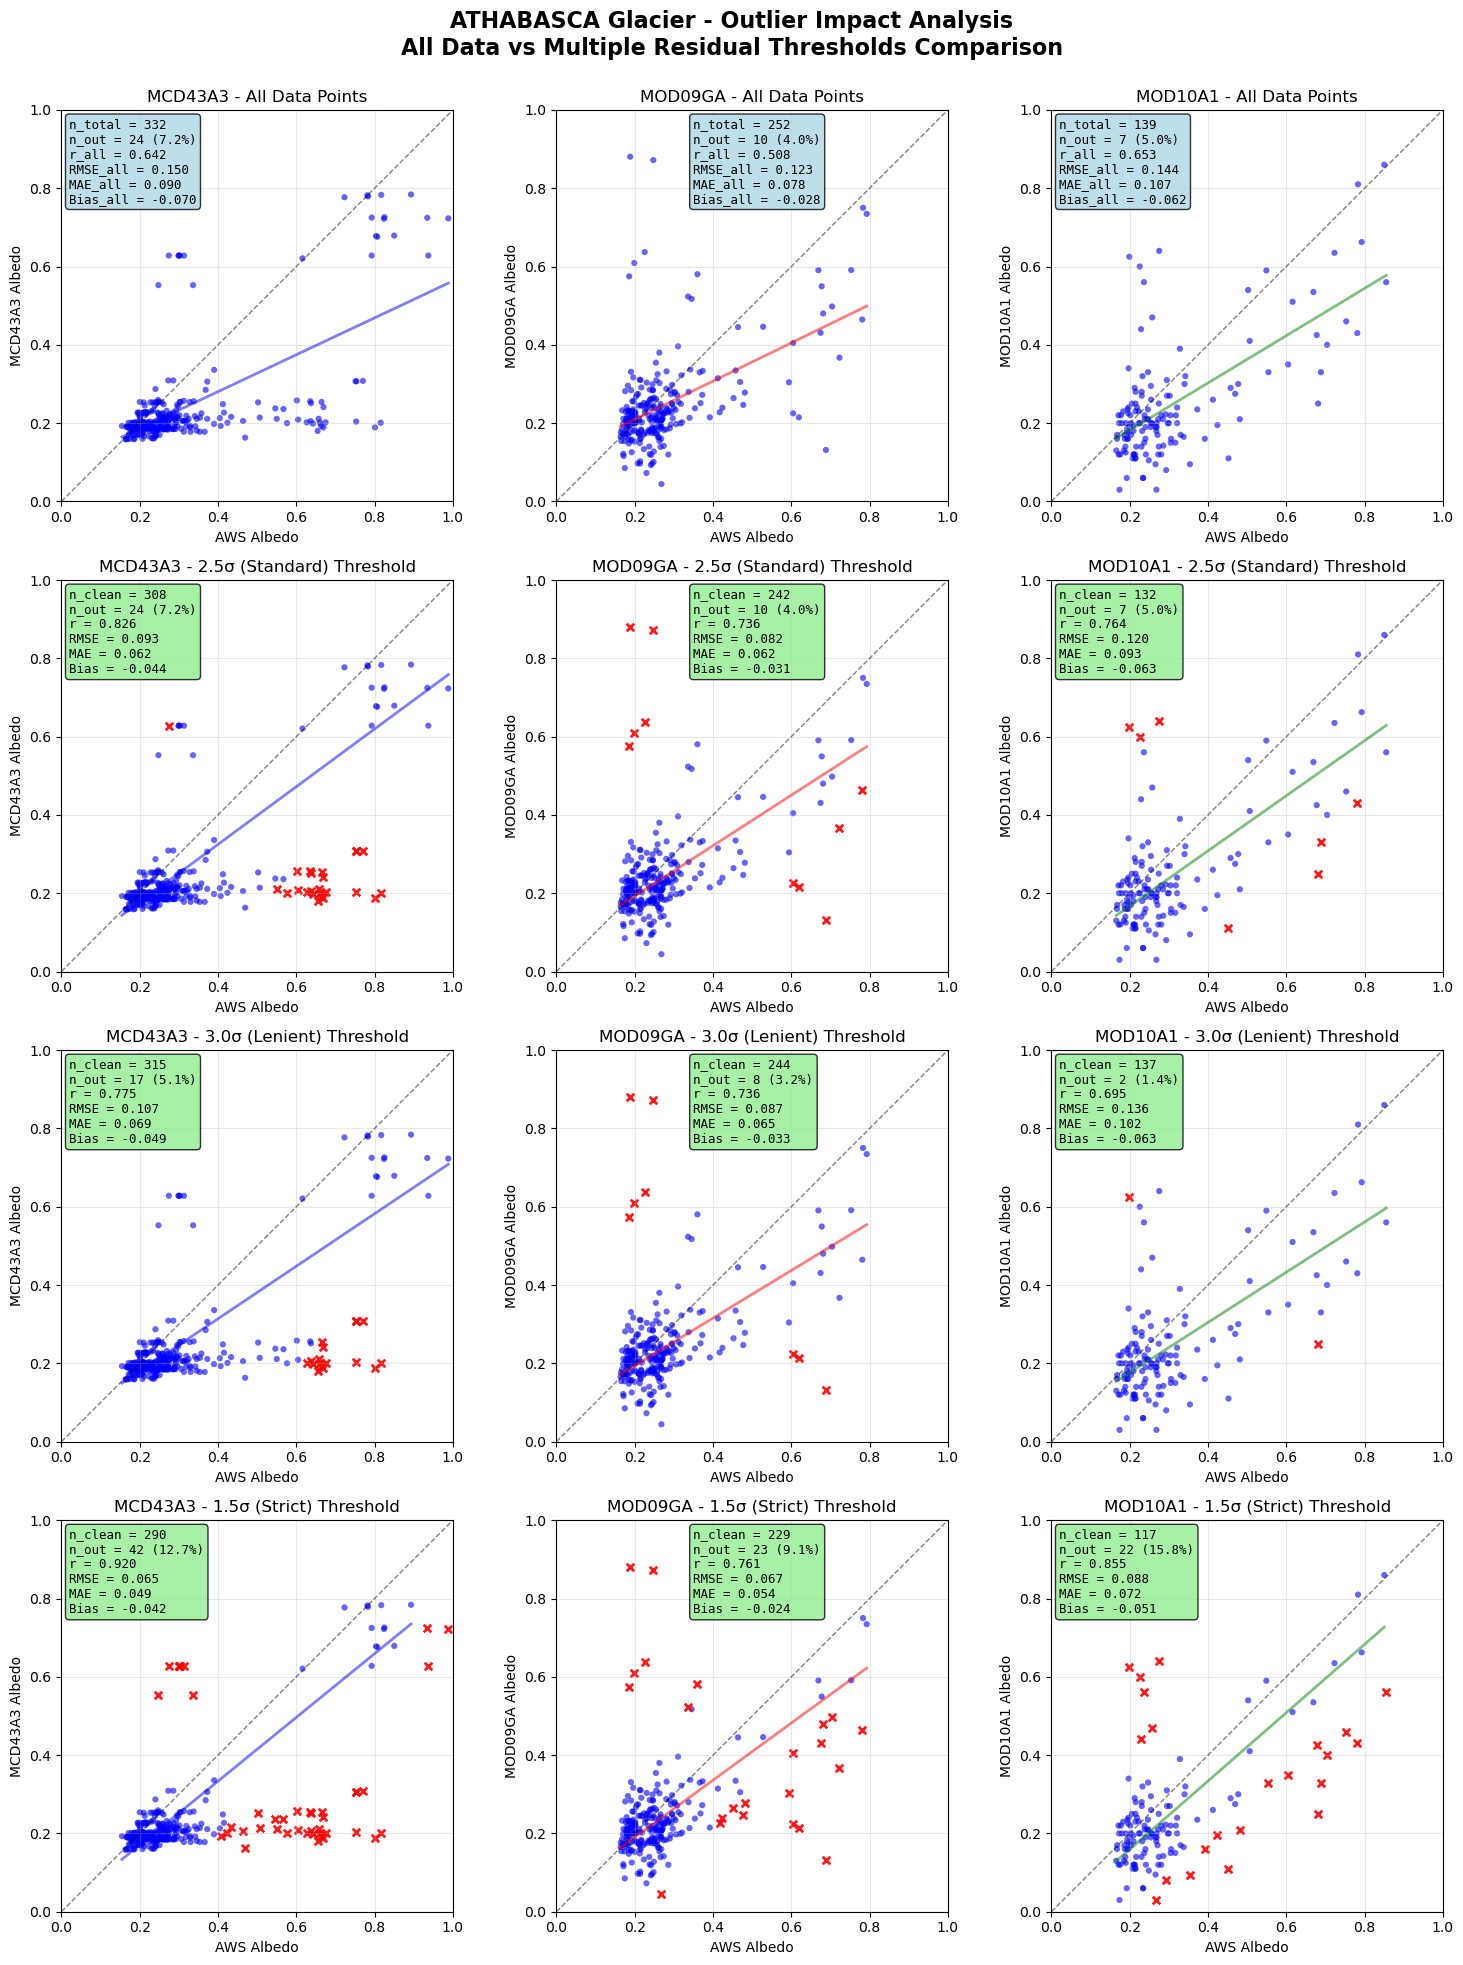

In [22]:
def create_outlier_comparison_plots():
    """Create comprehensive comparison plots showing data with different residual thresholds and outliers highlighted"""
    # Available methods for comparison
    methods = ['MCD43A3', 'MOD09GA', 'MOD10A1']
    available_methods = [m for m in methods if m in merged.columns]
    
    if not available_methods:
        return
    
    n_methods = len(available_methods)
    
    # Different residual thresholds to compare
    thresholds = [2.5, 3.0, 1.5]  # Standard deviations
    threshold_names = ['2.5σ (Standard)', '3.0σ (Lenient)', '1.5σ (Strict)']
    
    # Store results for each threshold
    threshold_results = {}
    
    # Individual legend box configuration for each plot (row, method)
    # Format: legend_config[method][row_index] where row_index: 0=with_outliers, 1=2.5σ, 2=3.0σ, 3=1.5σ
    legend_config = {
        'MCD43A3': {
            0: {'pos': (0.02, 0.98), 'ha': 'left', 'va': 'top', 'box': dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.8)},    # Row 0: With outliers
            1: {'pos': (0.02, 0.98), 'ha': 'left', 'va': 'top', 'box': dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8)},  # Row 1: 2.5σ threshold
            2: {'pos': (0.02, 0.98), 'ha': 'left', 'va': 'top', 'box': dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8)},  # Row 2: 3.0σ threshold
            3: {'pos': (0.02, 0.98), 'ha': 'left', 'va': 'top', 'box': dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8)}   # Row 3: 1.5σ threshold
        },
        'MOD09GA': {
            0: {'pos': (0.35, 0.98), 'ha': 'left', 'va': 'top', 'box': dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.8)},    # Row 0: With outliers
            1: {'pos': (0.35, 0.98), 'ha': 'left', 'va': 'top', 'box': dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8)},  # Row 1: 2.5σ threshold
            2: {'pos': (0.35, 0.98), 'ha': 'left', 'va': 'top', 'box': dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8)},  # Row 2: 3.0σ threshold
            3: {'pos': (0.35, 0.98), 'ha': 'left', 'va': 'top', 'box': dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8)}   # Row 3: 1.5σ threshold
        },
        'MOD10A1': {
            0: {'pos': (0.02, 0.98), 'ha': 'left', 'va': 'top', 'box': dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.8)},    # Row 0: With outliers
            1: {'pos': (0.02, 0.98), 'ha': 'left', 'va': 'top', 'box': dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8)},  # Row 1: 2.5σ threshold
            2: {'pos': (0.02, 0.98), 'ha': 'left', 'va': 'top', 'box': dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8)},  # Row 2: 3.0σ threshold
            3: {'pos': (0.02, 0.98), 'ha': 'left', 'va': 'top', 'box': dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8)}   # Row 3: 1.5σ threshold
        }
    }
    
    method_colors = {'MCD43A3': 'blue', 'MOD09GA': 'red', 'MOD10A1': 'green'}
    
    # Create figure with streamlined layout: 1 row with all data + 3 threshold comparison rows
    fig, axes = plt.subplots(4, n_methods, figsize=(5*n_methods, 20))
    fig.suptitle(f'{GLACIER.upper()} Glacier - Outlier Impact Analysis\n'
                f'All Data vs Multiple Residual Thresholds Comparison', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Ensure axes is 2D array even for single method
    if n_methods == 1:
        axes = axes.reshape(4, 1)
    
    for i, method in enumerate(available_methods):
        # Get valid data for this method
        mask = merged[[method, 'AWS']].notna().all(axis=1)
        if mask.sum() < 5:
            for row in range(4):
                axes[row, i].text(0.5, 0.5, f'Insufficient data\nfor {method}', 
                                ha='center', va='center', transform=axes[row, i].transAxes, fontsize=12)
            continue
        
        x_all = merged.loc[mask, 'AWS']
        y_all = merged.loc[mask, method]
        
        # Calculate statistics with outliers (original data)
        r_all, p_all = scipy_stats.pearsonr(x_all, y_all)
        rmse_all = np.sqrt(np.mean((y_all - x_all)**2))
        mae_all = np.mean(np.abs(y_all - x_all))
        bias_all = np.mean(y_all - x_all)
        
        # Residual-based outlier detection (2.5σ threshold - original)
        residuals = y_all - x_all
        residual_threshold = 2.5 * residuals.std()
        outlier_mask = np.abs(residuals) > residual_threshold
        n_outliers = outlier_mask.sum()
        n_total = len(x_all)
        pct_outliers = 100 * n_outliers / n_total if n_total > 0 else 0
        
        # ============= ORIGINAL PLOT (ROW 0) =============
        
        # Plot 1: All data (top row) - showing ALL data points uniformly
        ax1 = axes[0, i]
        
        # Plot all data points uniformly
        ax1.scatter(x_all, y_all, alpha=0.6, s=20, color='blue', edgecolors='none', label='All data')
        
        # Add 1:1 line
        ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1)
        
        # Add regression line
        if len(x_all) > 1:
            slope, intercept, _, _, _ = scipy_stats.linregress(x_all, y_all)
            x_range = np.linspace(x_all.min(), x_all.max(), 100)
            y_pred = slope * x_range + intercept
            ax1.plot(x_range, y_pred, color=method_colors.get(method, 'black'), linestyle='-', linewidth=2, alpha=0.5)
        
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.set_xlabel('AWS Albedo')
        ax1.set_ylabel(f'{method} Albedo')
        ax1.set_title(f'{method} - All Data Points')
        ax1.grid(True, alpha=0.3)
        ax1.set_aspect('equal')
        
        # Statistics box for with outliers
        conf = legend_config[method][0]  # Row 0: with outliers
        stats_text = (f"n_total = {n_total}\nn_out = {n_outliers} ({pct_outliers:.1f}%)\n"
                     f"r_all = {r_all:.3f}\n"
                     f"RMSE_all = {rmse_all:.3f}\n"
                     f"MAE_all = {mae_all:.3f}\n"
                     f"Bias_all = {bias_all:.3f}")
        ax1.text(conf['pos'][0], conf['pos'][1], stats_text, transform=ax1.transAxes,
                 verticalalignment=conf['va'], horizontalalignment=conf['ha'],
                 bbox=conf['box'], fontsize=9, family='monospace')
        
        # ============= THRESHOLD COMPARISON PLOTS (ROWS 1-3) =============
        
        # Store results for summary
        threshold_results[method] = {}
        
        for thresh_idx, (threshold, thresh_name) in enumerate(zip(thresholds, threshold_names)):
            row = thresh_idx + 1  # Start from row 1
            ax = axes[row, i]
            
            # Calculate outliers for this threshold
            thresh_residual_threshold = threshold * residuals.std()
            thresh_outlier_mask = np.abs(residuals) > thresh_residual_threshold
            thresh_n_outliers = thresh_outlier_mask.sum()
            thresh_pct_outliers = 100 * thresh_n_outliers / n_total if n_total > 0 else 0
            
            # Clean data for this threshold
            thresh_clean_mask = ~thresh_outlier_mask
            thresh_x_clean = x_all[thresh_clean_mask]
            thresh_y_clean = y_all[thresh_clean_mask]
            
            # Calculate statistics without outliers for this threshold
            if len(thresh_x_clean) > 5:
                thresh_r_clean, _ = scipy_stats.pearsonr(thresh_x_clean, thresh_y_clean)
                thresh_rmse_clean = np.sqrt(np.mean((thresh_y_clean - thresh_x_clean)**2))
                thresh_mae_clean = np.mean(np.abs(thresh_y_clean - thresh_x_clean))
                thresh_bias_clean = np.mean(thresh_y_clean - thresh_x_clean)
            else:
                thresh_r_clean = thresh_rmse_clean = thresh_mae_clean = thresh_bias_clean = np.nan
            
            # Store results
            threshold_results[method][threshold] = {
                'n_total': n_total,
                'n_outliers': thresh_n_outliers,
                'pct_outliers': thresh_pct_outliers,
                'n_clean': len(thresh_x_clean),
                'r_clean': thresh_r_clean,
                'rmse_clean': thresh_rmse_clean,
                'mae_clean': thresh_mae_clean,
                'bias_clean': thresh_bias_clean
            }
            
            # Plot normal data points (not outliers for this threshold)
            if len(thresh_x_clean) > 0:
                ax.scatter(thresh_x_clean, thresh_y_clean, alpha=0.6, s=20, color='blue', 
                          edgecolors='none', label='Normal data')
            
            # Highlight outliers for this threshold
            if thresh_outlier_mask.sum() > 0:
                ax.scatter(x_all[thresh_outlier_mask], y_all[thresh_outlier_mask], 
                          alpha=0.9, s=30, color='red', marker='x', linewidths=2, 
                          label=f'Outliers ({threshold}σ)')
            
            # Add 1:1 line
            ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1)
            
            # Add regression line for clean data
            if len(thresh_x_clean) > 1:
                slope, intercept, _, _, _ = scipy_stats.linregress(thresh_x_clean, thresh_y_clean)
                x_range = np.linspace(thresh_x_clean.min(), thresh_x_clean.max(), 100)
                y_pred = slope * x_range + intercept
                ax.plot(x_range, y_pred, color=method_colors.get(method, 'black'), 
                       linestyle='-', linewidth=2, alpha=0.5)
            
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_xlabel('AWS Albedo')
            ax.set_ylabel(f'{method} Albedo')
            ax.set_title(f'{method} - {thresh_name} Threshold')
            ax.grid(True, alpha=0.3)
            ax.set_aspect('equal')
            
            # Statistics box for this threshold
            if len(thresh_x_clean) > 5:
                stats_text_thresh = (f"n_clean = {len(thresh_x_clean)}\n"
                                   f"n_out = {thresh_n_outliers} ({thresh_pct_outliers:.1f}%)\n"
                                   f"r = {thresh_r_clean:.3f}\n"
                                   f"RMSE = {thresh_rmse_clean:.3f}\n"
                                   f"MAE = {thresh_mae_clean:.3f}\n"
                                   f"Bias = {thresh_bias_clean:.3f}")
            else:
                stats_text_thresh = f"n_clean < 5\nn_out = {thresh_n_outliers} ({thresh_pct_outliers:.1f}%)\nInsufficient data"
            
            # Use individual legend config for this row
            conf_thresh = legend_config[method][row]  # Use row index for individual positioning
            ax.text(conf_thresh['pos'][0], conf_thresh['pos'][1], stats_text_thresh, transform=ax.transAxes,
                   verticalalignment=conf_thresh['va'], horizontalalignment=conf_thresh['ha'],
                   bbox=conf_thresh['box'], fontsize=9, family='monospace')
    
    # Adjust layout with space for the extended main title
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    
    # Save plot
    plt.savefig(out('outliers_scatter_by_method_streamlined.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    return threshold_results

# Execute the function and store results
threshold_results = create_outlier_comparison_plots()

## Outlier Analysis vs Solar Zenith Angle

This section analyzes the relationship between outliers (data points with high disagreement between satellite and AWS measurements) and solar zenith angle to understand if illumination conditions affect measurement accuracy.

## MOD09GA Residuals vs Solar Zenith Angle

This section creates a focused analysis of MOD09GA residuals (MODIS - AWS) plotted against solar zenith angle, with outliers clearly highlighted.

MOD09GA Solar Zenith Analysis:
  Valid solar zenith observations: 252
  Solar zenith range: 28.8° to 57.7°
  Mean solar zenith: 39.9° ± 7.5°

Solar zenith analysis plot exported to: exports\athabasca_mod09ga_residuals_vs_sza_with_outliers.png


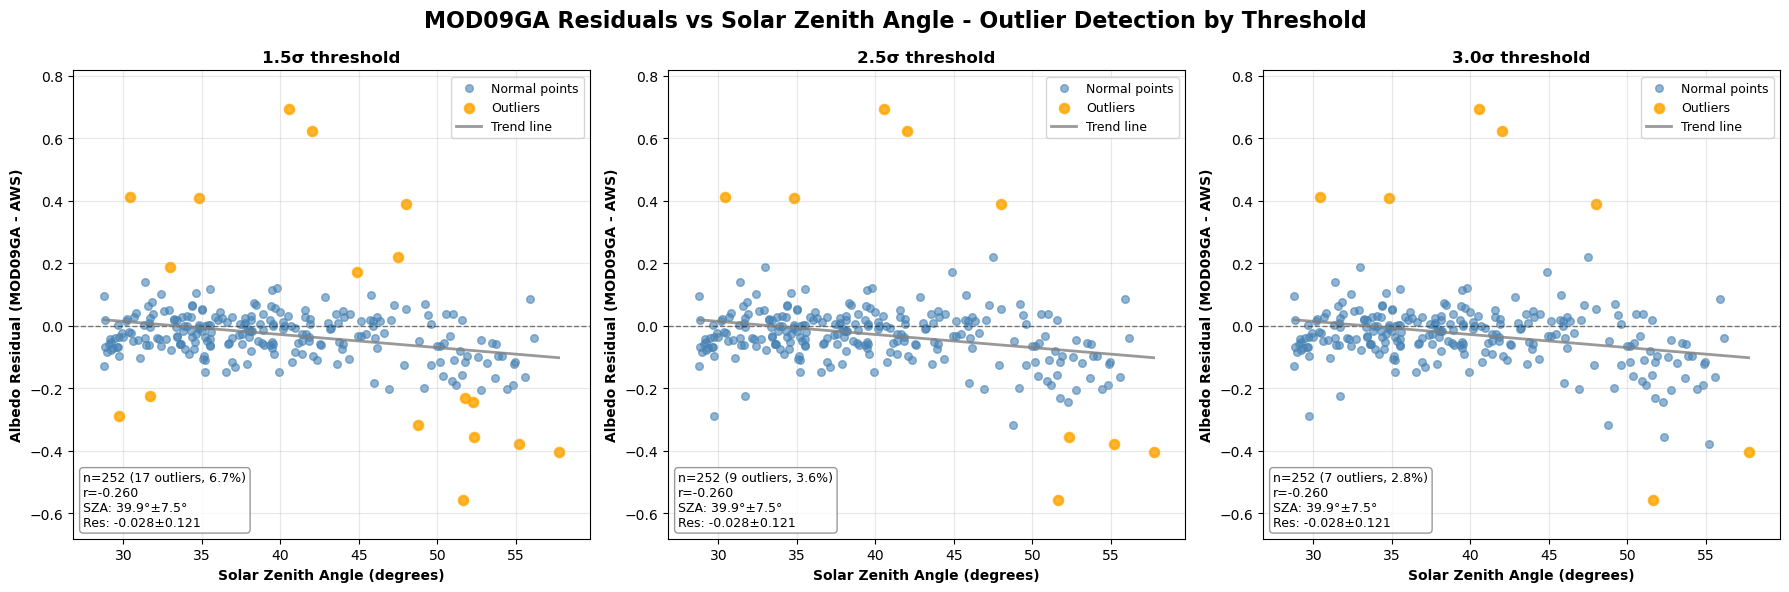


Solar Zenith Outlier Analysis Summary:
Threshold    Outliers   Rate (%)   Correlation 
--------------------------------------------------
1.5          17         6.7        -0.260      
2.5          9          3.6        -0.260      
3.0          7          2.8        -0.260      


In [23]:
# ==============================================================================
# SECTION: MOD09GA Residuals vs Solar Zenith Analysis with Outlier Detection
# ==============================================================================

# Check if MOD09GA data is available
if 'MOD09GA' in merged.columns and 'solar_zenith' in merged.columns:
    # Filter for MOD09GA data with valid AWS and solar zenith values
    mod09ga_sza_valid = (
        merged['MOD09GA'].notna() & 
        merged['AWS'].notna() & 
        merged['solar_zenith'].notna() & 
        (merged['solar_zenith'] != -999) &
        (merged['solar_zenith'] > 0) & 
        (merged['solar_zenith'] < 90)  # Valid solar zenith range
    )
    
    if mod09ga_sza_valid.sum() > 0:
        # Calculate residuals
        residuals = merged.loc[mod09ga_sza_valid, 'MOD09GA'] - merged.loc[mod09ga_sza_valid, 'AWS']
        sza_values = merged.loc[mod09ga_sza_valid, 'solar_zenith']
        
        print(f"MOD09GA Solar Zenith Analysis:")
        print(f"  Valid solar zenith observations: {len(sza_values)}")
        print(f"  Solar zenith range: {sza_values.min():.1f}° to {sza_values.max():.1f}°")
        print(f"  Mean solar zenith: {sza_values.mean():.1f}° ± {sza_values.std():.1f}°")
        
        # Define outlier detection thresholds (Z-score based)
        thresholds_analysis = [1.5, 2.5, 3.0]
        threshold_colors = ['lightgreen', 'lightcoral', 'lightskyblue']
        threshold_labels = ['1.5σ threshold', '2.5σ threshold', '3.0σ threshold']
        
        # Create three-panel figure
        fig_sza, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig_sza.suptitle('MOD09GA Residuals vs Solar Zenith Angle - Outlier Detection by Threshold', 
                        fontsize=16, fontweight='bold')
        
        all_outlier_data = []
        
        for i, (threshold, color, label) in enumerate(zip(thresholds_analysis, threshold_colors, threshold_labels)):
            ax = axes[i]
            
            # Detect outliers using Z-score manually (same as NDSI analysis)
            residual_std = residuals.std()
            residual_mean = residuals.mean()
            z_scores = np.abs((residuals - residual_mean) / residual_std)
            outliers = z_scores > threshold
            
            # Separate normal and outlier points
            normal_mask = ~outliers
            normal_points = pd.DataFrame({
                'sza': sza_values[normal_mask],
                'residuals': residuals[normal_mask]
            })
            outlier_points = pd.DataFrame({
                'sza': sza_values[outliers],
                'residuals': residuals[outliers]
            })
            
            # Plot normal points (different color from NDSI - using steelblue)
            ax.scatter(normal_points['sza'], normal_points['residuals'], 
                      alpha=0.6, s=30, color='steelblue', label='Normal points')
            
            # Plot outlier points (different marker from NDSI - using circles instead of X)
            if len(outlier_points) > 0:
                ax.scatter(outlier_points['sza'], outlier_points['residuals'], 
                          alpha=0.8, s=40, color='orange', marker='o', linewidth=2, label='Outliers')
            
            # Add zero line
            ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
            
            # Add regression line (kept from original design)
            slope, intercept = np.polyfit(sza_values, residuals, 1)
            line_x = np.linspace(sza_values.min(), sza_values.max(), 100)
            line_y = slope * line_x + intercept
            ax.plot(line_x, line_y, color='gray', linestyle='-', alpha=0.8, linewidth=2, label='Trend line')
            
            # Calculate correlation
            correlation_sza = np.corrcoef(sza_values, residuals)[0, 1]
            
            # Statistics for legend box (same format as NDSI)
            n_total = len(residuals)
            n_outliers = outliers.sum()
            n_normal = n_total - n_outliers
            outlier_rate = (n_outliers / n_total) * 100
            mean_sza = sza_values.mean()
            std_sza = sza_values.std()
            mean_residual = residuals.mean()
            std_residual = residuals.std()
            
            # Create concise stats text (same format as NDSI)
            stats_text = f'n={n_total} ({n_outliers} outliers, {outlier_rate:.1f}%)\nr={correlation_sza:.3f}\nSZA: {mean_sza:.1f}°±{std_sza:.1f}°\nRes: {mean_residual:.3f}±{std_residual:.3f}'
            
            # Add stats box in bottom-left (same position as NDSI)
            ax.text(0.02, 0.02, stats_text, transform=ax.transAxes, 
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray'),
                   fontsize=9, verticalalignment='bottom', horizontalalignment='left')
            
            # Formatting (same as NDSI)
            ax.set_xlabel('Solar Zenith Angle (degrees)', fontweight='bold')
            ax.set_ylabel('Albedo Residual (MOD09GA - AWS)', fontweight='bold')
            ax.set_title(f'{label}', fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.legend(loc='upper right', fontsize=9)
            
            # Set consistent axis limits
            ax.set_xlim(sza_values.min() - 2, sza_values.max() + 2)
            residual_range = residuals.max() - residuals.min()
            ax.set_ylim(residuals.min() - 0.1*residual_range, residuals.max() + 0.1*residual_range)
            
            # Store outlier data for summary
            all_outlier_data.append({
                'threshold': threshold,
                'n_outliers': n_outliers,
                'outlier_rate': outlier_rate,
                'correlation': correlation_sza
            })
        
        plt.tight_layout()
        
        # Export the figure
        export_path = EXPORT_DIR / f"athabasca_mod09ga_residuals_vs_sza_with_outliers.png"
        fig_sza.savefig(export_path, dpi=300, bbox_inches='tight')
        print(f"\nSolar zenith analysis plot exported to: {export_path}")
        
        plt.show()
        
        # Summary statistics (same format as NDSI)
        print(f"\nSolar Zenith Outlier Analysis Summary:")
        print(f"{'Threshold':<12} {'Outliers':<10} {'Rate (%)':<10} {'Correlation':<12}")
        print("-" * 50)
        for data in all_outlier_data:
            print(f"{data['threshold']:<12} {data['n_outliers']:<10} {data['outlier_rate']:<10.1f} {data['correlation']:<12.3f}")
        
    else:
        print("No valid MOD09GA-solar zenith data pairs found for analysis")
else:
    print("MOD09GA or solar zenith data not available in merged dataset")

## MOD09GA Residuals vs NDSI Analysis

Analysis of MOD09GA albedo residuals as a function of NDSI (Normalized Difference Snow Index) values, examining outlier patterns across different statistical thresholds. NDSI is a key indicator of snow/ice surface conditions that may influence albedo measurement accuracy.

MOD09GA NDSI Analysis:
  Valid NDSI observations: 252
  NDSI range: -0.121 to 0.927
  Mean NDSI: 0.552 ± 0.217

NDSI analysis plot exported to: exports\athabasca_mod09ga_residuals_vs_ndsi_outliers.png


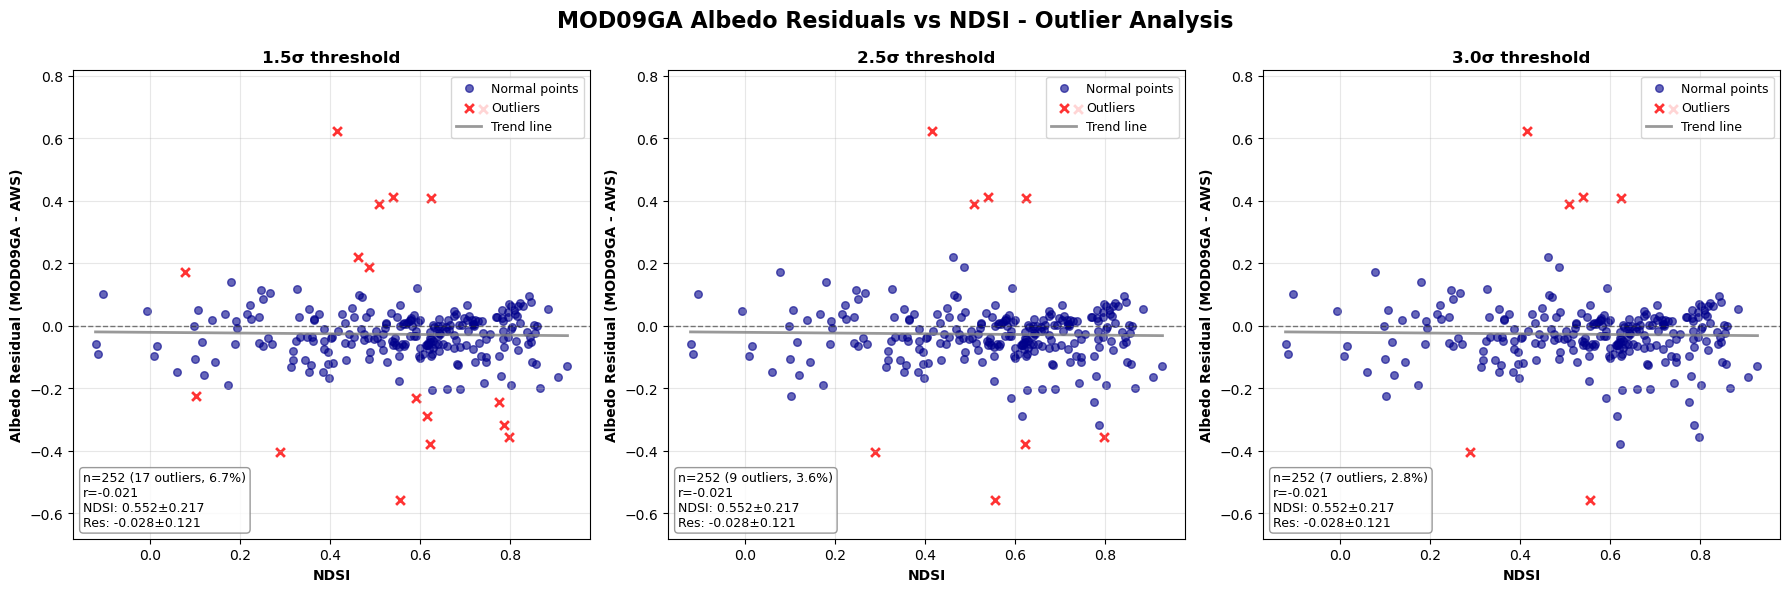


NDSI Outlier Analysis Summary:
Threshold    Outliers   Rate (%)   Correlation 
--------------------------------------------------
1.5          17         6.7        -0.021      
2.5          9          3.6        -0.021      
3.0          7          2.8        -0.021      


In [24]:
# ==============================================================================
# SECTION: MOD09GA Residuals vs NDSI Analysis with Outlier Detection
# ==============================================================================

# Check if MOD09GA data is available
if 'MOD09GA' in merged.columns and 'ndsi' in merged.columns:
    # Filter for MOD09GA data with valid AWS and NDSI values
    mod09ga_ndsi_valid = (
        merged['MOD09GA'].notna() & 
        merged['AWS'].notna() & 
        merged['ndsi'].notna() & 
        (merged['ndsi'] != -999) &
        (merged['ndsi'] >= -1) & 
        (merged['ndsi'] <= 1)  # Valid NDSI range
    )
    
    if mod09ga_ndsi_valid.sum() > 0:
        # Calculate residuals
        residuals = merged.loc[mod09ga_ndsi_valid, 'MOD09GA'] - merged.loc[mod09ga_ndsi_valid, 'AWS']
        ndsi_values = merged.loc[mod09ga_ndsi_valid, 'ndsi']
        
        print(f"MOD09GA NDSI Analysis:")
        print(f"  Valid NDSI observations: {len(ndsi_values)}")
        print(f"  NDSI range: {ndsi_values.min():.3f} to {ndsi_values.max():.3f}")
        print(f"  Mean NDSI: {ndsi_values.mean():.3f} ± {ndsi_values.std():.3f}")
        
        # Define outlier detection thresholds (Z-score based)
        thresholds_analysis = [1.5, 2.5, 3.0]
        threshold_colors = ['lightcoral', 'orange', 'lightblue']
        threshold_labels = ['1.5σ threshold', '2.5σ threshold', '3.0σ threshold']
        
        # Create three-panel figure
        fig_ndsi, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig_ndsi.suptitle('MOD09GA Albedo Residuals vs NDSI - Outlier Analysis', fontsize=16, fontweight='bold')
        
        all_outlier_data = []
        
        for i, (threshold, color, label) in enumerate(zip(thresholds_analysis, threshold_colors, threshold_labels)):
            ax = axes[i]
            
            # Detect outliers using Z-score manually (simpler approach)
            residual_std = residuals.std()
            residual_mean = residuals.mean()
            z_scores = np.abs((residuals - residual_mean) / residual_std)
            outliers = z_scores > threshold
            
            # Separate normal and outlier points
            normal_mask = ~outliers
            normal_points = pd.DataFrame({
                'ndsi': ndsi_values[normal_mask],
                'residuals': residuals[normal_mask]
            })
            outlier_points = pd.DataFrame({
                'ndsi': ndsi_values[outliers],
                'residuals': residuals[outliers]
            })
            
            # Plot normal points
            ax.scatter(normal_points['ndsi'], normal_points['residuals'], 
                      alpha=0.6, s=30, color='darkblue', label='Normal points')
            
            # Plot outlier points
            if len(outlier_points) > 0:
                ax.scatter(outlier_points['ndsi'], outlier_points['residuals'], 
                          alpha=0.8, s=40, color='red', marker='x', linewidth=2, label='Outliers')
            
            # Add zero line
            ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
            
            # Add regression line (same as solar zenith analysis)
            slope, intercept = np.polyfit(ndsi_values, residuals, 1)
            line_x = np.linspace(ndsi_values.min(), ndsi_values.max(), 100)
            line_y = slope * line_x + intercept
            ax.plot(line_x, line_y, color='gray', linestyle='-', alpha=0.8, linewidth=2, label='Trend line')
            
            # Calculate correlation
            correlation_ndsi = np.corrcoef(ndsi_values, residuals)[0, 1]
            
            # Statistics for legend box
            n_total = len(residuals)
            n_outliers = outliers.sum()
            n_normal = n_total - n_outliers
            outlier_rate = (n_outliers / n_total) * 100
            mean_ndsi = ndsi_values.mean()
            std_ndsi = ndsi_values.std()
            mean_residual = residuals.mean()
            std_residual = residuals.std()
            
            # Create concise stats text
            stats_text = f'n={n_total} ({n_outliers} outliers, {outlier_rate:.1f}%)\nr={correlation_ndsi:.3f}\nNDSI: {mean_ndsi:.3f}±{std_ndsi:.3f}\nRes: {mean_residual:.3f}±{std_residual:.3f}'
            
            # Add stats box in bottom-left
            ax.text(0.02, 0.02, stats_text, transform=ax.transAxes, 
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray'),
                   fontsize=9, verticalalignment='bottom', horizontalalignment='left')
            
            # Formatting
            ax.set_xlabel('NDSI', fontweight='bold')
            ax.set_ylabel('Albedo Residual (MOD09GA - AWS)', fontweight='bold')
            ax.set_title(f'{label}', fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.legend(loc='upper right', fontsize=9)
            
            # Set consistent axis limits
            ax.set_xlim(ndsi_values.min() - 0.05, ndsi_values.max() + 0.05)
            residual_range = residuals.max() - residuals.min()
            ax.set_ylim(residuals.min() - 0.1*residual_range, residuals.max() + 0.1*residual_range)
            
            # Store outlier data for summary
            all_outlier_data.append({
                'threshold': threshold,
                'n_outliers': n_outliers,
                'outlier_rate': outlier_rate,
                'correlation': correlation_ndsi
            })
        
        plt.tight_layout()
        
        # Export the figure
        export_path = EXPORT_DIR / f"athabasca_mod09ga_residuals_vs_ndsi_outliers.png"
        fig_ndsi.savefig(export_path, dpi=300, bbox_inches='tight')
        print(f"\nNDSI analysis plot exported to: {export_path}")
        
        plt.show()
        
        # Summary statistics
        print(f"\nNDSI Outlier Analysis Summary:")
        print(f"{'Threshold':<12} {'Outliers':<10} {'Rate (%)':<10} {'Correlation':<12}")
        print("-" * 50)
        for data in all_outlier_data:
            print(f"{data['threshold']:<12} {data['n_outliers']:<10} {data['outlier_rate']:<10.1f} {data['correlation']:<12.3f}")
        
    else:
        print("No valid MOD09GA-NDSI data pairs found for analysis")
else:
    print("MOD09GA or NDSI data not available in merged dataset")

## Export All Statistics to Text File

This final section exports a comprehensive summary of all analysis results to a text file for easy sharing and reporting.

## MOD09GA Statistical Metrics Histograms

Comprehensive histogram analysis of MOD09GA performance metrics including bias, RMSE, MAE, and correlation coefficients.

Valid paired observations: 252
=== MOD09GA COMPREHENSIVE STATISTICAL ANALYSIS ===
Sample Size: 252 paired observations

Bias Metrics:
  Mean Bias: -0.027672
  Median Bias: -0.030410
  Bias Std Dev: 0.120350

Error Metrics:
  RMSE: 0.123490
  MAE: 0.077983
  Mean Relative Error: -4.42%

Correlation Metrics:
  Pearson r: 0.507819
  R-squared: 0.257880
  Explained Variance: 25.79%

Error Distribution:
   5th percentile error: 0.003569
  10th percentile error: 0.008162
  25th percentile error: 0.025041
  50th percentile error: 0.051724
  75th percentile error: 0.096217
  90th percentile error: 0.165884
  95th percentile error: 0.226967

Statistical Tests:
  Bias t-test (H0: bias=0): t=-3.6428, p=0.000328
  Normality test (Shapiro): W=0.8234, p=0.000000
  Bias is significant at α=0.05


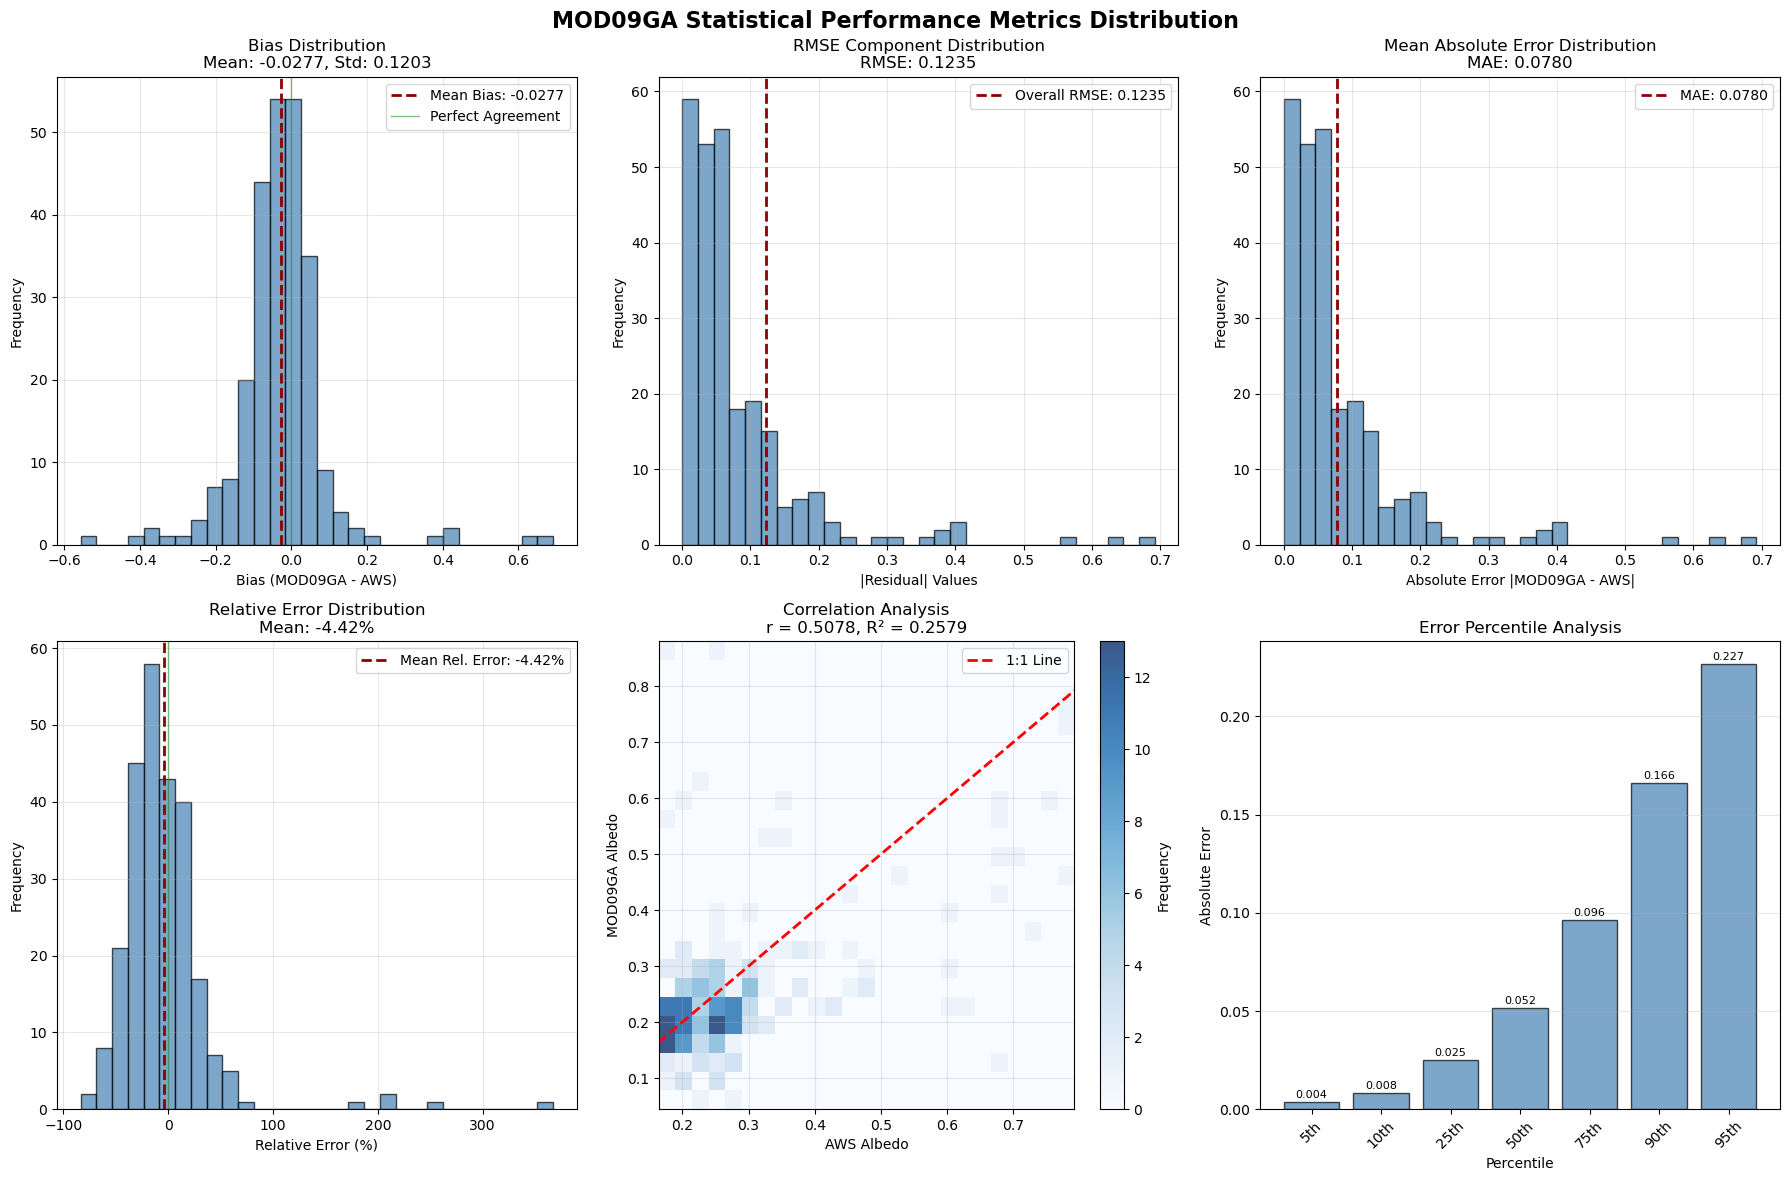


Histogram analysis saved to: exports\athabasca_mod09ga_comprehensive_histogram_analysis.png


In [37]:
# MOD09GA Statistical Metrics Histograms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Extract MOD09GA data for analysis from merged DataFrame
mod09_valid = merged[['MOD09GA', 'AWS']].dropna()
mod09ga_values = mod09_valid['MOD09GA']
aws_values = mod09_valid['AWS']

print(f"Valid paired observations: {len(mod09_valid):,}")

# Calculate comprehensive statistics
residuals = mod09ga_values - aws_values
abs_residuals = np.abs(residuals)
rel_residuals = residuals / aws_values * 100

# Statistical metrics
bias = np.mean(residuals)
rmse = np.sqrt(np.mean(residuals**2))
mae = np.mean(abs_residuals)
r_corr = np.corrcoef(mod09ga_values, aws_values)[0,1]
r2 = r_corr**2

# Create comprehensive histogram figure
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('MOD09GA Statistical Performance Metrics Distribution', fontsize=16, fontweight='bold')

# Color scheme
hist_color = 'steelblue'
kde_color = 'darkred'
alpha = 0.7

# 1. Bias Distribution (Residuals)
ax1 = axes[0, 0]
n, bins, patches = ax1.hist(residuals, bins=30, alpha=alpha, color=hist_color, edgecolor='black')
ax1.axvline(bias, color=kde_color, linestyle='--', linewidth=2, label=f'Mean Bias: {bias:.4f}')
ax1.axvline(0, color='green', linestyle='-', linewidth=1, alpha=0.5, label='Perfect Agreement')
ax1.set_xlabel('Bias (MOD09GA - AWS)')
ax1.set_ylabel('Frequency')
ax1.set_title(f'Bias Distribution\nMean: {bias:.4f}, Std: {np.std(residuals):.4f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. RMSE Components (showing residual magnitude)
ax2 = axes[0, 1]
rmse_values = np.sqrt(residuals**2)  # Individual RMSE contributions
n, bins, patches = ax2.hist(rmse_values, bins=30, alpha=alpha, color=hist_color, edgecolor='black')
ax2.axvline(rmse, color=kde_color, linestyle='--', linewidth=2, label=f'Overall RMSE: {rmse:.4f}')
ax2.set_xlabel('|Residual| Values')
ax2.set_ylabel('Frequency')
ax2.set_title(f'RMSE Component Distribution\nRMSE: {rmse:.4f}')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. MAE Distribution (Absolute Errors)
ax3 = axes[0, 2]
n, bins, patches = ax3.hist(abs_residuals, bins=30, alpha=alpha, color=hist_color, edgecolor='black')
ax3.axvline(mae, color=kde_color, linestyle='--', linewidth=2, label=f'MAE: {mae:.4f}')
ax3.set_xlabel('Absolute Error |MOD09GA - AWS|')
ax3.set_ylabel('Frequency')
ax3.set_title(f'Mean Absolute Error Distribution\nMAE: {mae:.4f}')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Relative Error Distribution (%)
ax4 = axes[1, 0]
rel_residuals_clean = rel_residuals[np.isfinite(rel_residuals)]
n, bins, patches = ax4.hist(rel_residuals_clean, bins=30, alpha=alpha, color=hist_color, edgecolor='black')
mean_rel_error = np.mean(rel_residuals_clean)
ax4.axvline(mean_rel_error, color=kde_color, linestyle='--', linewidth=2, 
           label=f'Mean Rel. Error: {mean_rel_error:.2f}%')
ax4.axvline(0, color='green', linestyle='-', linewidth=1, alpha=0.5)
ax4.set_xlabel('Relative Error (%)')
ax4.set_ylabel('Frequency')
ax4.set_title(f'Relative Error Distribution\nMean: {mean_rel_error:.2f}%')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Correlation Analysis (Scatter density)
ax5 = axes[1, 1]
# Create 2D histogram for correlation visualization
h = ax5.hist2d(aws_values, mod09ga_values, bins=25, cmap='Blues', alpha=0.8)
plt.colorbar(h[3], ax=ax5, label='Frequency')

# Add 1:1 line
min_val = min(np.min(aws_values), np.min(mod09ga_values))
max_val = max(np.max(aws_values), np.max(mod09ga_values))
ax5.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='1:1 Line')

ax5.set_xlabel('AWS Albedo')
ax5.set_ylabel('MOD09GA Albedo')
ax5.set_title(f'Correlation Analysis\nr = {r_corr:.4f}, R² = {r2:.4f}')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Performance Percentiles
ax6 = axes[1, 2]
percentiles = [5, 10, 25, 50, 75, 90, 95]
error_percentiles = np.percentile(abs_residuals, percentiles)

bars = ax6.bar(range(len(percentiles)), error_percentiles, alpha=alpha, color=hist_color, edgecolor='black')
ax6.set_xlabel('Percentile')
ax6.set_ylabel('Absolute Error')
ax6.set_title('Error Percentile Analysis')
ax6.set_xticks(range(len(percentiles)))
ax6.set_xticklabels([f'{p}th' for p in percentiles], rotation=45)
ax6.grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, (bar, val) in enumerate(zip(bars, error_percentiles)):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{val:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()

# Print comprehensive statistics
print("=== MOD09GA COMPREHENSIVE STATISTICAL ANALYSIS ===")
print(f"Sample Size: {len(residuals):,} paired observations")
print(f"\nBias Metrics:")
print(f"  Mean Bias: {bias:.6f}")
print(f"  Median Bias: {np.median(residuals):.6f}")
print(f"  Bias Std Dev: {np.std(residuals):.6f}")

print(f"\nError Metrics:")
print(f"  RMSE: {rmse:.6f}")
print(f"  MAE: {mae:.6f}")
print(f"  Mean Relative Error: {mean_rel_error:.2f}%")

print(f"\nCorrelation Metrics:")
print(f"  Pearson r: {r_corr:.6f}")
print(f"  R-squared: {r2:.6f}")
print(f"  Explained Variance: {r2*100:.2f}%")

print(f"\nError Distribution:")
for p, val in zip(percentiles, error_percentiles):
    print(f"  {p:2d}th percentile error: {val:.6f}")

# Statistical significance tests
from scipy.stats import ttest_1samp, shapiro
t_stat, p_val = ttest_1samp(residuals, 0)
shapiro_stat, shapiro_p = shapiro(residuals[:min(5000, len(residuals))])  # Sample for normality test

print(f"\nStatistical Tests:")
print(f"  Bias t-test (H0: bias=0): t={t_stat:.4f}, p={p_val:.6f}")
print(f"  Normality test (Shapiro): W={shapiro_stat:.4f}, p={shapiro_p:.6f}")
print(f"  Bias is {'significant' if p_val < 0.05 else 'not significant'} at α=0.05")

plt.show()

# Save the figure
export_path = EXPORT_DIR / f'{GLACIER}_mod09ga_comprehensive_histogram_analysis.png'
fig.savefig(export_path, dpi=300, bbox_inches='tight')
print(f"\nHistogram analysis saved to: {export_path}")

## MOD10A1 Statistical Metrics Histograms

Comprehensive histogram analysis of MOD10A1 performance metrics including bias, RMSE, MAE, and correlation coefficients.

Valid paired observations: 139
=== MOD10A1 COMPREHENSIVE STATISTICAL ANALYSIS ===
Sample Size: 139 paired observations

Bias Metrics:
  Mean Bias: -0.061704
  Median Bias: -0.056238
  Bias Std Dev: 0.130534

Error Metrics:
  RMSE: 0.144383
  MAE: 0.106958
  Mean Relative Error: -15.13%

Correlation Metrics:
  Pearson r: 0.653358
  R-squared: 0.426876
  Explained Variance: 42.69%

Error Distribution:
   5th percentile error: 0.010186
  10th percentile error: 0.017451
  25th percentile error: 0.035364
  50th percentile error: 0.077377
  75th percentile error: 0.149118
  90th percentile error: 0.253095
  95th percentile error: 0.325554

Statistical Tests:
  Bias t-test (H0: bias=0): t=-5.5530, p=0.000000
  Normality test (Shapiro): W=0.9383, p=0.000008
  Bias is significant at α=0.05


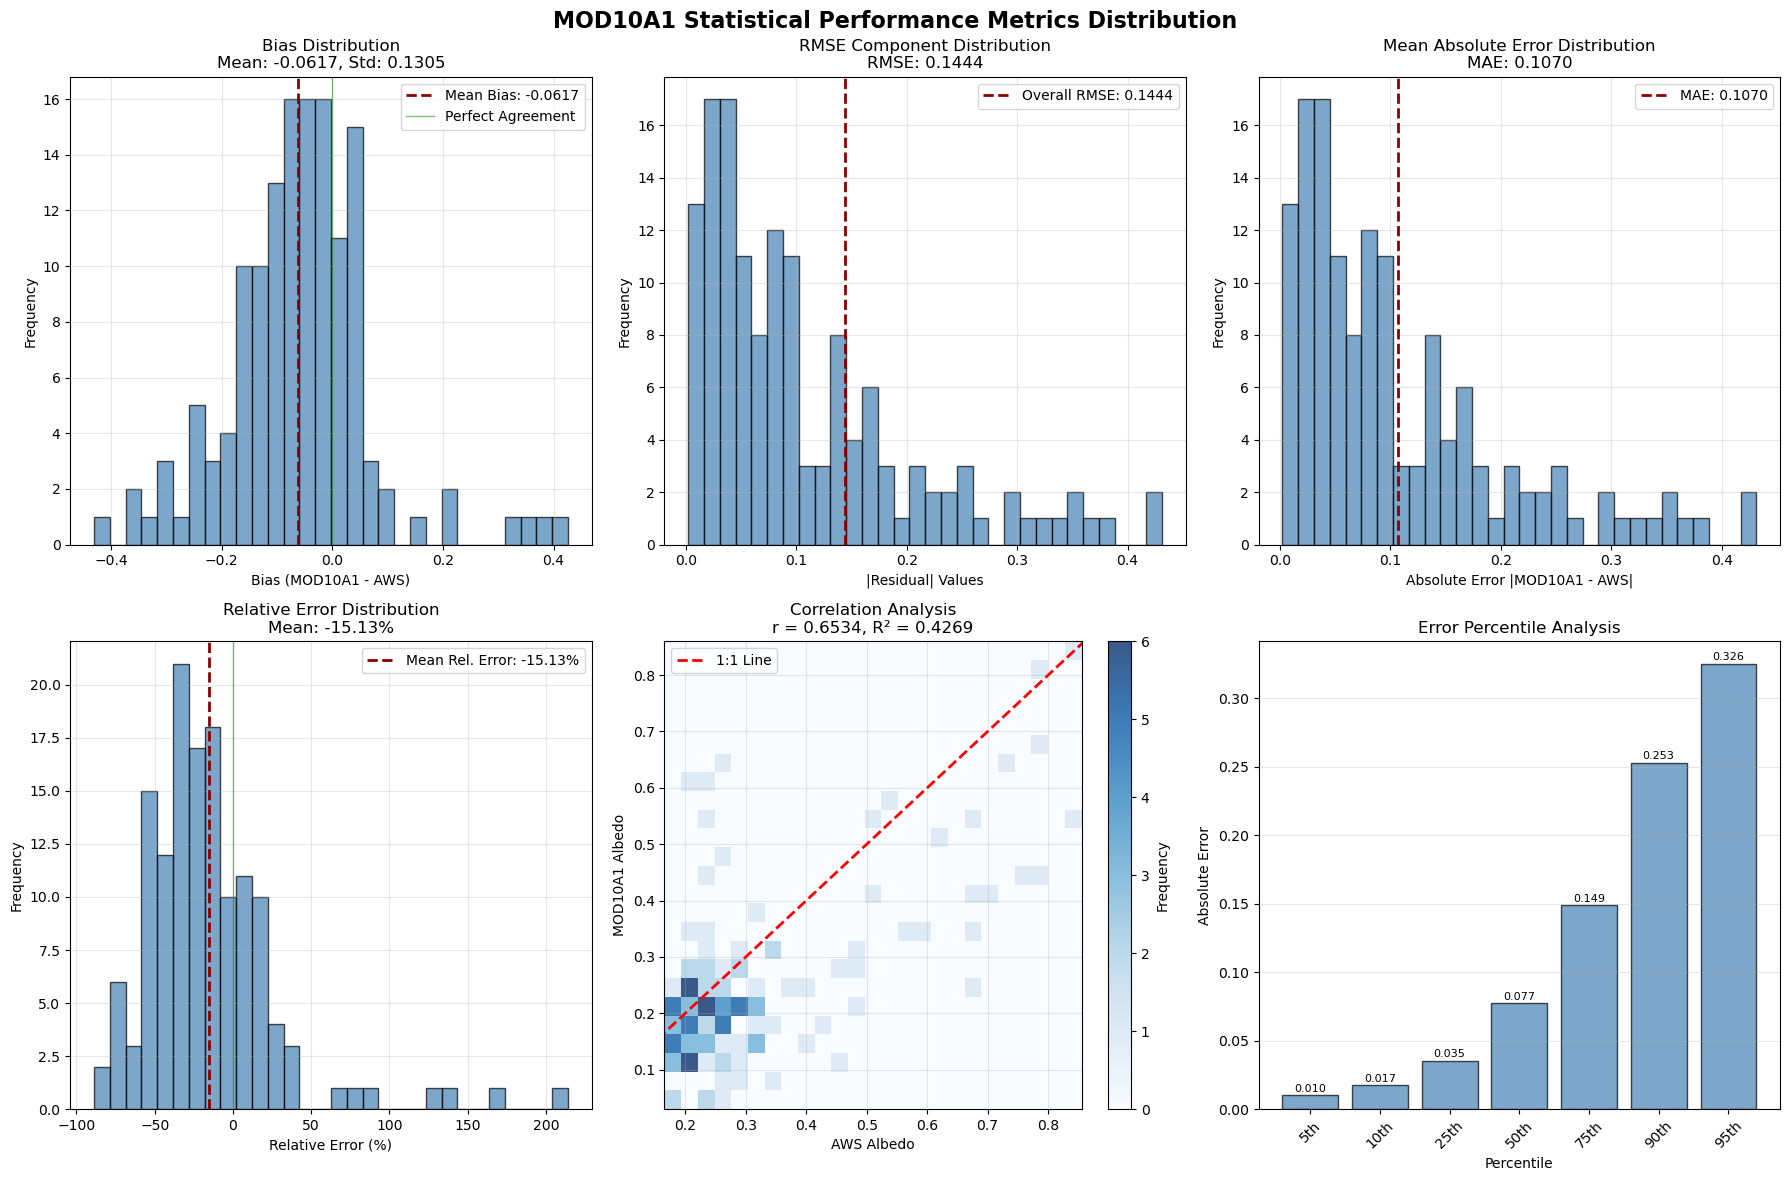


Histogram analysis saved to: exports\athabasca_mod10a1_comprehensive_histogram_analysis.png


In [40]:
# MOD10A1 Statistical Metrics Histograms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Extract MOD10A1 data for analysis from merged DataFrame
mod10_valid = merged[['MOD10A1', 'AWS']].dropna()
mod10a1_values = mod10_valid['MOD10A1']
aws_values_mod10 = mod10_valid['AWS']

print(f"Valid paired observations: {len(mod10_valid):,}")

# Calculate comprehensive statistics
residuals = mod10a1_values - aws_values_mod10
abs_residuals = np.abs(residuals)
rel_residuals = residuals / aws_values_mod10 * 100

# Statistical metrics
bias = np.mean(residuals)
rmse = np.sqrt(np.mean(residuals**2))
mae = np.mean(abs_residuals)
r_corr = np.corrcoef(mod10a1_values, aws_values_mod10)[0,1]
r2 = r_corr**2

# Create comprehensive histogram figure
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('MOD10A1 Statistical Performance Metrics Distribution', fontsize=16, fontweight='bold')

# Color scheme
hist_color = 'steelblue'
kde_color = 'darkred'
alpha = 0.7

# 1. Bias Distribution (Residuals)
ax1 = axes[0, 0]
n, bins, patches = ax1.hist(residuals, bins=30, alpha=alpha, color=hist_color, edgecolor='black')
ax1.axvline(bias, color=kde_color, linestyle='--', linewidth=2, label=f'Mean Bias: {bias:.4f}')
ax1.axvline(0, color='green', linestyle='-', linewidth=1, alpha=0.5, label='Perfect Agreement')
ax1.set_xlabel('Bias (MOD10A1 - AWS)')
ax1.set_ylabel('Frequency')
ax1.set_title(f'Bias Distribution\nMean: {bias:.4f}, Std: {np.std(residuals):.4f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. RMSE Components (showing residual magnitude)
ax2 = axes[0, 1]
rmse_values = np.sqrt(residuals**2)  # Individual RMSE contributions
n, bins, patches = ax2.hist(rmse_values, bins=30, alpha=alpha, color=hist_color, edgecolor='black')
ax2.axvline(rmse, color=kde_color, linestyle='--', linewidth=2, label=f'Overall RMSE: {rmse:.4f}')
ax2.set_xlabel('|Residual| Values')
ax2.set_ylabel('Frequency')
ax2.set_title(f'RMSE Component Distribution\nRMSE: {rmse:.4f}')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. MAE Distribution (Absolute Errors)
ax3 = axes[0, 2]
n, bins, patches = ax3.hist(abs_residuals, bins=30, alpha=alpha, color=hist_color, edgecolor='black')
ax3.axvline(mae, color=kde_color, linestyle='--', linewidth=2, label=f'MAE: {mae:.4f}')
ax3.set_xlabel('Absolute Error |MOD10A1 - AWS|')
ax3.set_ylabel('Frequency')
ax3.set_title(f'Mean Absolute Error Distribution\nMAE: {mae:.4f}')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Relative Error Distribution (%)
ax4 = axes[1, 0]
rel_residuals_clean = rel_residuals[np.isfinite(rel_residuals)]
n, bins, patches = ax4.hist(rel_residuals_clean, bins=30, alpha=alpha, color=hist_color, edgecolor='black')
mean_rel_error = np.mean(rel_residuals_clean)
ax4.axvline(mean_rel_error, color=kde_color, linestyle='--', linewidth=2, 
           label=f'Mean Rel. Error: {mean_rel_error:.2f}%')
ax4.axvline(0, color='green', linestyle='-', linewidth=1, alpha=0.5)
ax4.set_xlabel('Relative Error (%)')
ax4.set_ylabel('Frequency')
ax4.set_title(f'Relative Error Distribution\nMean: {mean_rel_error:.2f}%')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Correlation Analysis (Scatter density)
ax5 = axes[1, 1]
# Create 2D histogram for correlation visualization
h = ax5.hist2d(aws_values_mod10, mod10a1_values, bins=25, cmap='Blues', alpha=0.8)
plt.colorbar(h[3], ax=ax5, label='Frequency')

# Add 1:1 line
min_val = min(np.min(aws_values_mod10), np.min(mod10a1_values))
max_val = max(np.max(aws_values_mod10), np.max(mod10a1_values))
ax5.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='1:1 Line')

ax5.set_xlabel('AWS Albedo')
ax5.set_ylabel('MOD10A1 Albedo')
ax5.set_title(f'Correlation Analysis\nr = {r_corr:.4f}, R² = {r2:.4f}')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Performance Percentiles
ax6 = axes[1, 2]
percentiles = [5, 10, 25, 50, 75, 90, 95]
error_percentiles = np.percentile(abs_residuals, percentiles)

bars = ax6.bar(range(len(percentiles)), error_percentiles, alpha=alpha, color=hist_color, edgecolor='black')
ax6.set_xlabel('Percentile')
ax6.set_ylabel('Absolute Error')
ax6.set_title('Error Percentile Analysis')
ax6.set_xticks(range(len(percentiles)))
ax6.set_xticklabels([f'{p}th' for p in percentiles], rotation=45)
ax6.grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, (bar, val) in enumerate(zip(bars, error_percentiles)):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{val:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()

# Print comprehensive statistics
print("=== MOD10A1 COMPREHENSIVE STATISTICAL ANALYSIS ===")
print(f"Sample Size: {len(residuals):,} paired observations")
print(f"\nBias Metrics:")
print(f"  Mean Bias: {bias:.6f}")
print(f"  Median Bias: {np.median(residuals):.6f}")
print(f"  Bias Std Dev: {np.std(residuals):.6f}")

print(f"\nError Metrics:")
print(f"  RMSE: {rmse:.6f}")
print(f"  MAE: {mae:.6f}")
print(f"  Mean Relative Error: {mean_rel_error:.2f}%")

print(f"\nCorrelation Metrics:")
print(f"  Pearson r: {r_corr:.6f}")
print(f"  R-squared: {r2:.6f}")
print(f"  Explained Variance: {r2*100:.2f}%")

print(f"\nError Distribution:")
for p, val in zip(percentiles, error_percentiles):
    print(f"  {p:2d}th percentile error: {val:.6f}")

# Statistical significance tests
from scipy.stats import ttest_1samp, shapiro
t_stat, p_val = ttest_1samp(residuals, 0)
shapiro_stat, shapiro_p = shapiro(residuals[:min(5000, len(residuals))])  # Sample for normality test

print(f"\nStatistical Tests:")
print(f"  Bias t-test (H0: bias=0): t={t_stat:.4f}, p={p_val:.6f}")
print(f"  Normality test (Shapiro): W={shapiro_stat:.4f}, p={shapiro_p:.6f}")
print(f"  Bias is {'significant' if p_val < 0.05 else 'not significant'} at α=0.05")

plt.show()

# Save the figure
export_path = EXPORT_DIR / f'{GLACIER}_mod10a1_comprehensive_histogram_analysis.png'
fig.savefig(export_path, dpi=300, bbox_inches='tight')
print(f"\nHistogram analysis saved to: {export_path}")

## MCD43A3 Statistical Metrics Histograms

Comprehensive histogram analysis of MCD43A3 performance metrics including bias, RMSE, MAE, and correlation coefficients.

Valid paired observations: 332
=== MCD43A3 COMPREHENSIVE STATISTICAL ANALYSIS ===
Sample Size: 332 paired observations

Bias Metrics:
  Mean Bias: -0.070437
  Median Bias: -0.044400
  Bias Std Dev: 0.132551

Error Metrics:
  RMSE: 0.150104
  MAE: 0.089708
  Mean Relative Error: -16.11%

Correlation Metrics:
  Pearson r: 0.642149
  R-squared: 0.412355
  Explained Variance: 41.24%

Error Distribution:
   5th percentile error: 0.004344
  10th percentile error: 0.006407
  25th percentile error: 0.016974
  50th percentile error: 0.049044
  75th percentile error: 0.088840
  90th percentile error: 0.289888
  95th percentile error: 0.402325

Statistical Tests:
  Bias t-test (H0: bias=0): t=-9.6679, p=0.000000
  Normality test (Shapiro): W=0.7795, p=0.000000
  Bias is significant at α=0.05


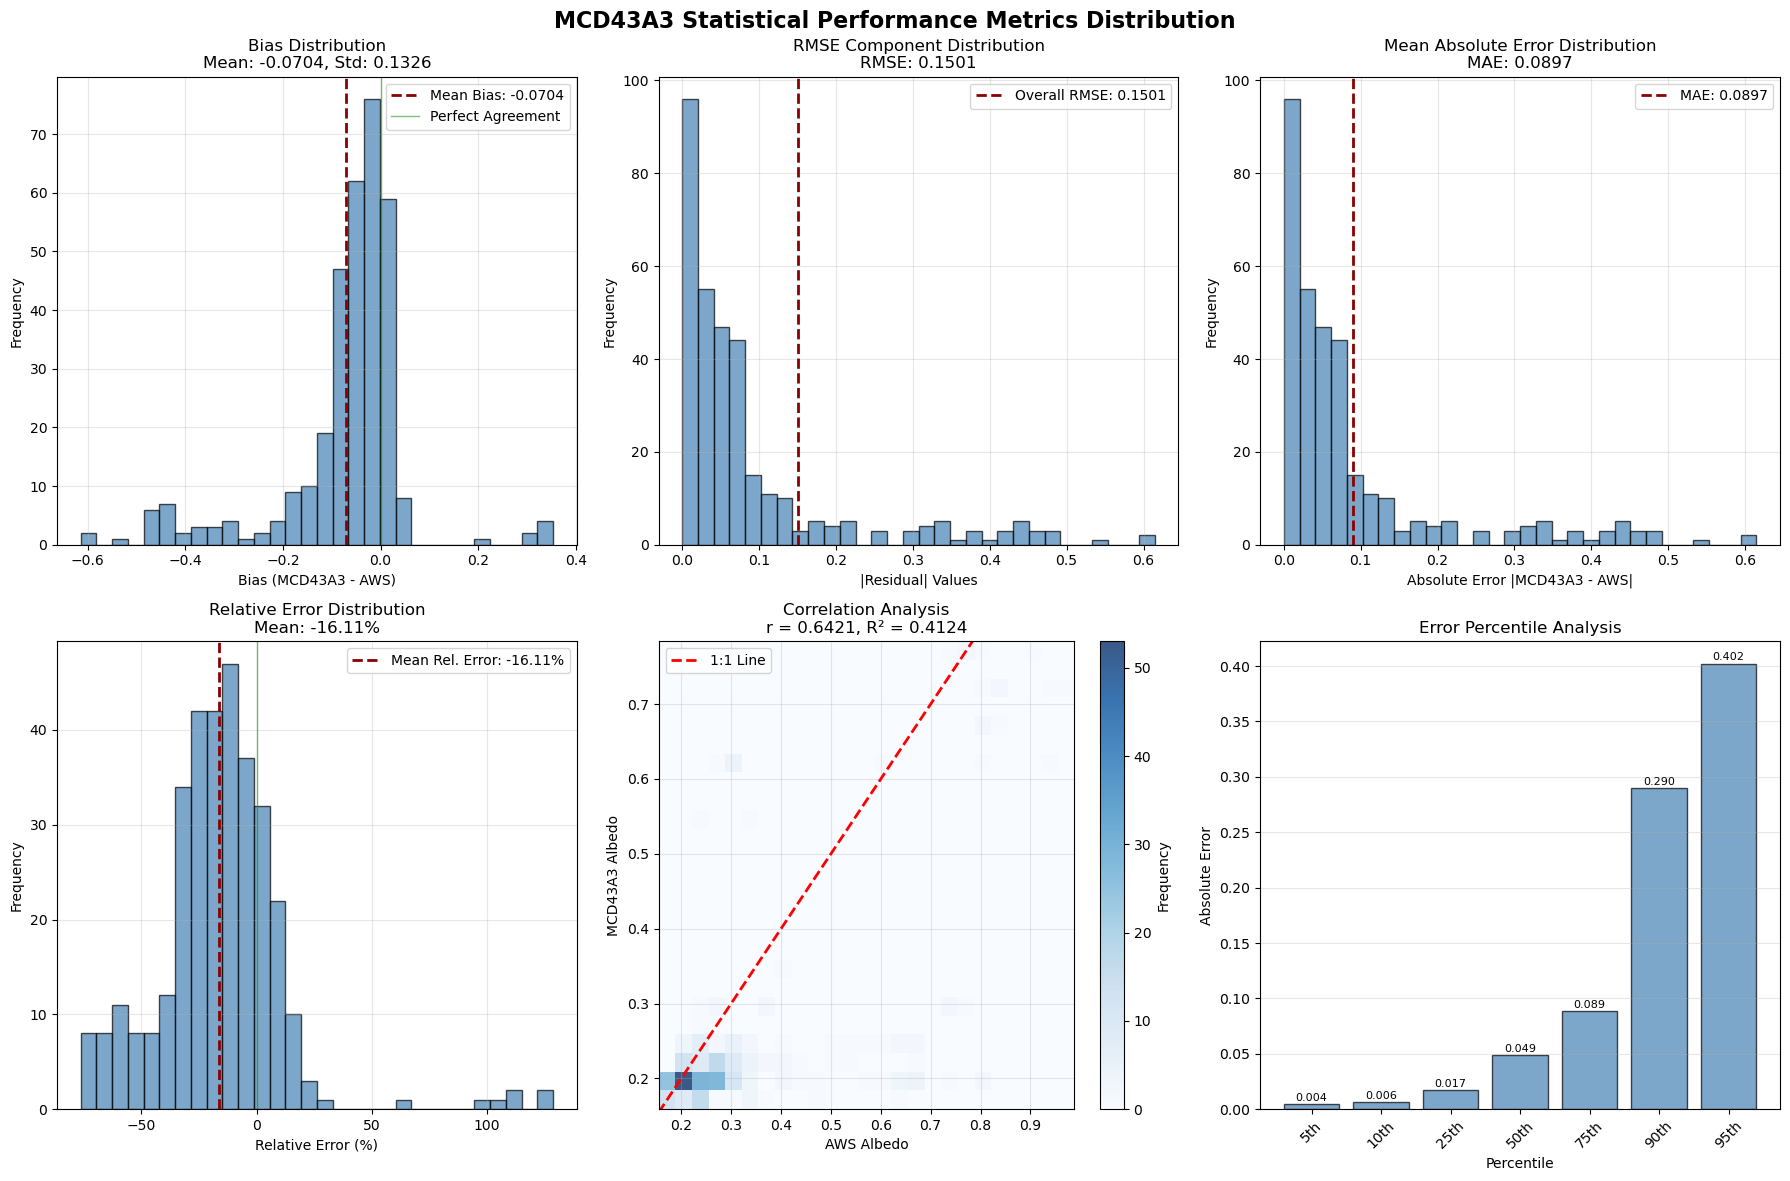


Histogram analysis saved to: exports\athabasca_mcd43a3_comprehensive_histogram_analysis.png


In [43]:
# MCD43A3 Statistical Metrics Histograms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Extract MCD43A3 data for analysis from merged DataFrame
mcd43_valid = merged[['MCD43A3', 'AWS']].dropna()
mcd43a3_values = mcd43_valid['MCD43A3']
aws_values_mcd43 = mcd43_valid['AWS']

print(f"Valid paired observations: {len(mcd43_valid):,}")

# Calculate comprehensive statistics
residuals = mcd43a3_values - aws_values_mcd43
abs_residuals = np.abs(residuals)
rel_residuals = residuals / aws_values_mcd43 * 100

# Statistical metrics
bias = np.mean(residuals)
rmse = np.sqrt(np.mean(residuals**2))
mae = np.mean(abs_residuals)
r_corr = np.corrcoef(mcd43a3_values, aws_values_mcd43)[0,1]
r2 = r_corr**2

# Create comprehensive histogram figure
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('MCD43A3 Statistical Performance Metrics Distribution', fontsize=16, fontweight='bold')

# Color scheme
hist_color = 'steelblue'
kde_color = 'darkred'
alpha = 0.7

# 1. Bias Distribution (Residuals)
ax1 = axes[0, 0]
n, bins, patches = ax1.hist(residuals, bins=30, alpha=alpha, color=hist_color, edgecolor='black')
ax1.axvline(bias, color=kde_color, linestyle='--', linewidth=2, label=f'Mean Bias: {bias:.4f}')
ax1.axvline(0, color='green', linestyle='-', linewidth=1, alpha=0.5, label='Perfect Agreement')
ax1.set_xlabel('Bias (MCD43A3 - AWS)')
ax1.set_ylabel('Frequency')
ax1.set_title(f'Bias Distribution\nMean: {bias:.4f}, Std: {np.std(residuals):.4f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. RMSE Components (showing residual magnitude)
ax2 = axes[0, 1]
rmse_values = np.sqrt(residuals**2)  # Individual RMSE contributions
n, bins, patches = ax2.hist(rmse_values, bins=30, alpha=alpha, color=hist_color, edgecolor='black')
ax2.axvline(rmse, color=kde_color, linestyle='--', linewidth=2, label=f'Overall RMSE: {rmse:.4f}')
ax2.set_xlabel('|Residual| Values')
ax2.set_ylabel('Frequency')
ax2.set_title(f'RMSE Component Distribution\nRMSE: {rmse:.4f}')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. MAE Distribution (Absolute Errors)
ax3 = axes[0, 2]
n, bins, patches = ax3.hist(abs_residuals, bins=30, alpha=alpha, color=hist_color, edgecolor='black')
ax3.axvline(mae, color=kde_color, linestyle='--', linewidth=2, label=f'MAE: {mae:.4f}')
ax3.set_xlabel('Absolute Error |MCD43A3 - AWS|')
ax3.set_ylabel('Frequency')
ax3.set_title(f'Mean Absolute Error Distribution\nMAE: {mae:.4f}')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Relative Error Distribution (%)
ax4 = axes[1, 0]
rel_residuals_clean = rel_residuals[np.isfinite(rel_residuals)]
n, bins, patches = ax4.hist(rel_residuals_clean, bins=30, alpha=alpha, color=hist_color, edgecolor='black')
mean_rel_error = np.mean(rel_residuals_clean)
ax4.axvline(mean_rel_error, color=kde_color, linestyle='--', linewidth=2, 
           label=f'Mean Rel. Error: {mean_rel_error:.2f}%')
ax4.axvline(0, color='green', linestyle='-', linewidth=1, alpha=0.5)
ax4.set_xlabel('Relative Error (%)')
ax4.set_ylabel('Frequency')
ax4.set_title(f'Relative Error Distribution\nMean: {mean_rel_error:.2f}%')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Correlation Analysis (Scatter density)
ax5 = axes[1, 1]
# Create 2D histogram for correlation visualization
h = ax5.hist2d(aws_values_mcd43, mcd43a3_values, bins=25, cmap='Blues', alpha=0.8)
plt.colorbar(h[3], ax=ax5, label='Frequency')

# Add 1:1 line
min_val = min(np.min(aws_values_mcd43), np.min(mcd43a3_values))
max_val = max(np.max(aws_values_mcd43), np.max(mcd43a3_values))
ax5.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='1:1 Line')

ax5.set_xlabel('AWS Albedo')
ax5.set_ylabel('MCD43A3 Albedo')
ax5.set_title(f'Correlation Analysis\nr = {r_corr:.4f}, R² = {r2:.4f}')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Performance Percentiles
ax6 = axes[1, 2]
percentiles = [5, 10, 25, 50, 75, 90, 95]
error_percentiles = np.percentile(abs_residuals, percentiles)

bars = ax6.bar(range(len(percentiles)), error_percentiles, alpha=alpha, color=hist_color, edgecolor='black')
ax6.set_xlabel('Percentile')
ax6.set_ylabel('Absolute Error')
ax6.set_title('Error Percentile Analysis')
ax6.set_xticks(range(len(percentiles)))
ax6.set_xticklabels([f'{p}th' for p in percentiles], rotation=45)
ax6.grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, (bar, val) in enumerate(zip(bars, error_percentiles)):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{val:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()

# Print comprehensive statistics
print("=== MCD43A3 COMPREHENSIVE STATISTICAL ANALYSIS ===")
print(f"Sample Size: {len(residuals):,} paired observations")
print(f"\nBias Metrics:")
print(f"  Mean Bias: {bias:.6f}")
print(f"  Median Bias: {np.median(residuals):.6f}")
print(f"  Bias Std Dev: {np.std(residuals):.6f}")

print(f"\nError Metrics:")
print(f"  RMSE: {rmse:.6f}")
print(f"  MAE: {mae:.6f}")
print(f"  Mean Relative Error: {mean_rel_error:.2f}%")

print(f"\nCorrelation Metrics:")
print(f"  Pearson r: {r_corr:.6f}")
print(f"  R-squared: {r2:.6f}")
print(f"  Explained Variance: {r2*100:.2f}%")

print(f"\nError Distribution:")
for p, val in zip(percentiles, error_percentiles):
    print(f"  {p:2d}th percentile error: {val:.6f}")

# Statistical significance tests
from scipy.stats import ttest_1samp, shapiro
t_stat, p_val = ttest_1samp(residuals, 0)
shapiro_stat, shapiro_p = shapiro(residuals[:min(5000, len(residuals))])  # Sample for normality test

print(f"\nStatistical Tests:")
print(f"  Bias t-test (H0: bias=0): t={t_stat:.4f}, p={p_val:.6f}")
print(f"  Normality test (Shapiro): W={shapiro_stat:.4f}, p={shapiro_p:.6f}")
print(f"  Bias is {'significant' if p_val < 0.05 else 'not significant'} at α=0.05")

plt.show()

# Save the figure
export_path = EXPORT_DIR / f'{GLACIER}_mcd43a3_comprehensive_histogram_analysis.png'
fig.savefig(export_path, dpi=300, bbox_inches='tight')
print(f"\nHistogram analysis saved to: {export_path}")

## Comparative Monthly Absolute Error Distribution

Cross-method comparison of monthly absolute error patterns across all three MODIS products.

=== COMPARATIVE MONTHLY ERROR DISTRIBUTION ANALYSIS ===
Creating unified boxplot comparison: Absolute Error + Bias across all three MODIS products

Manual positioning enabled - you can adjust stats_positions dictionary above to customize legend placement

✓ Comparative monthly error distributions plot saved: exports\athabasca_comparative_monthly_error_distributions.png
✓ Comparative monthly error distributions plot saved: exports\athabasca_comparative_monthly_error_distributions.png


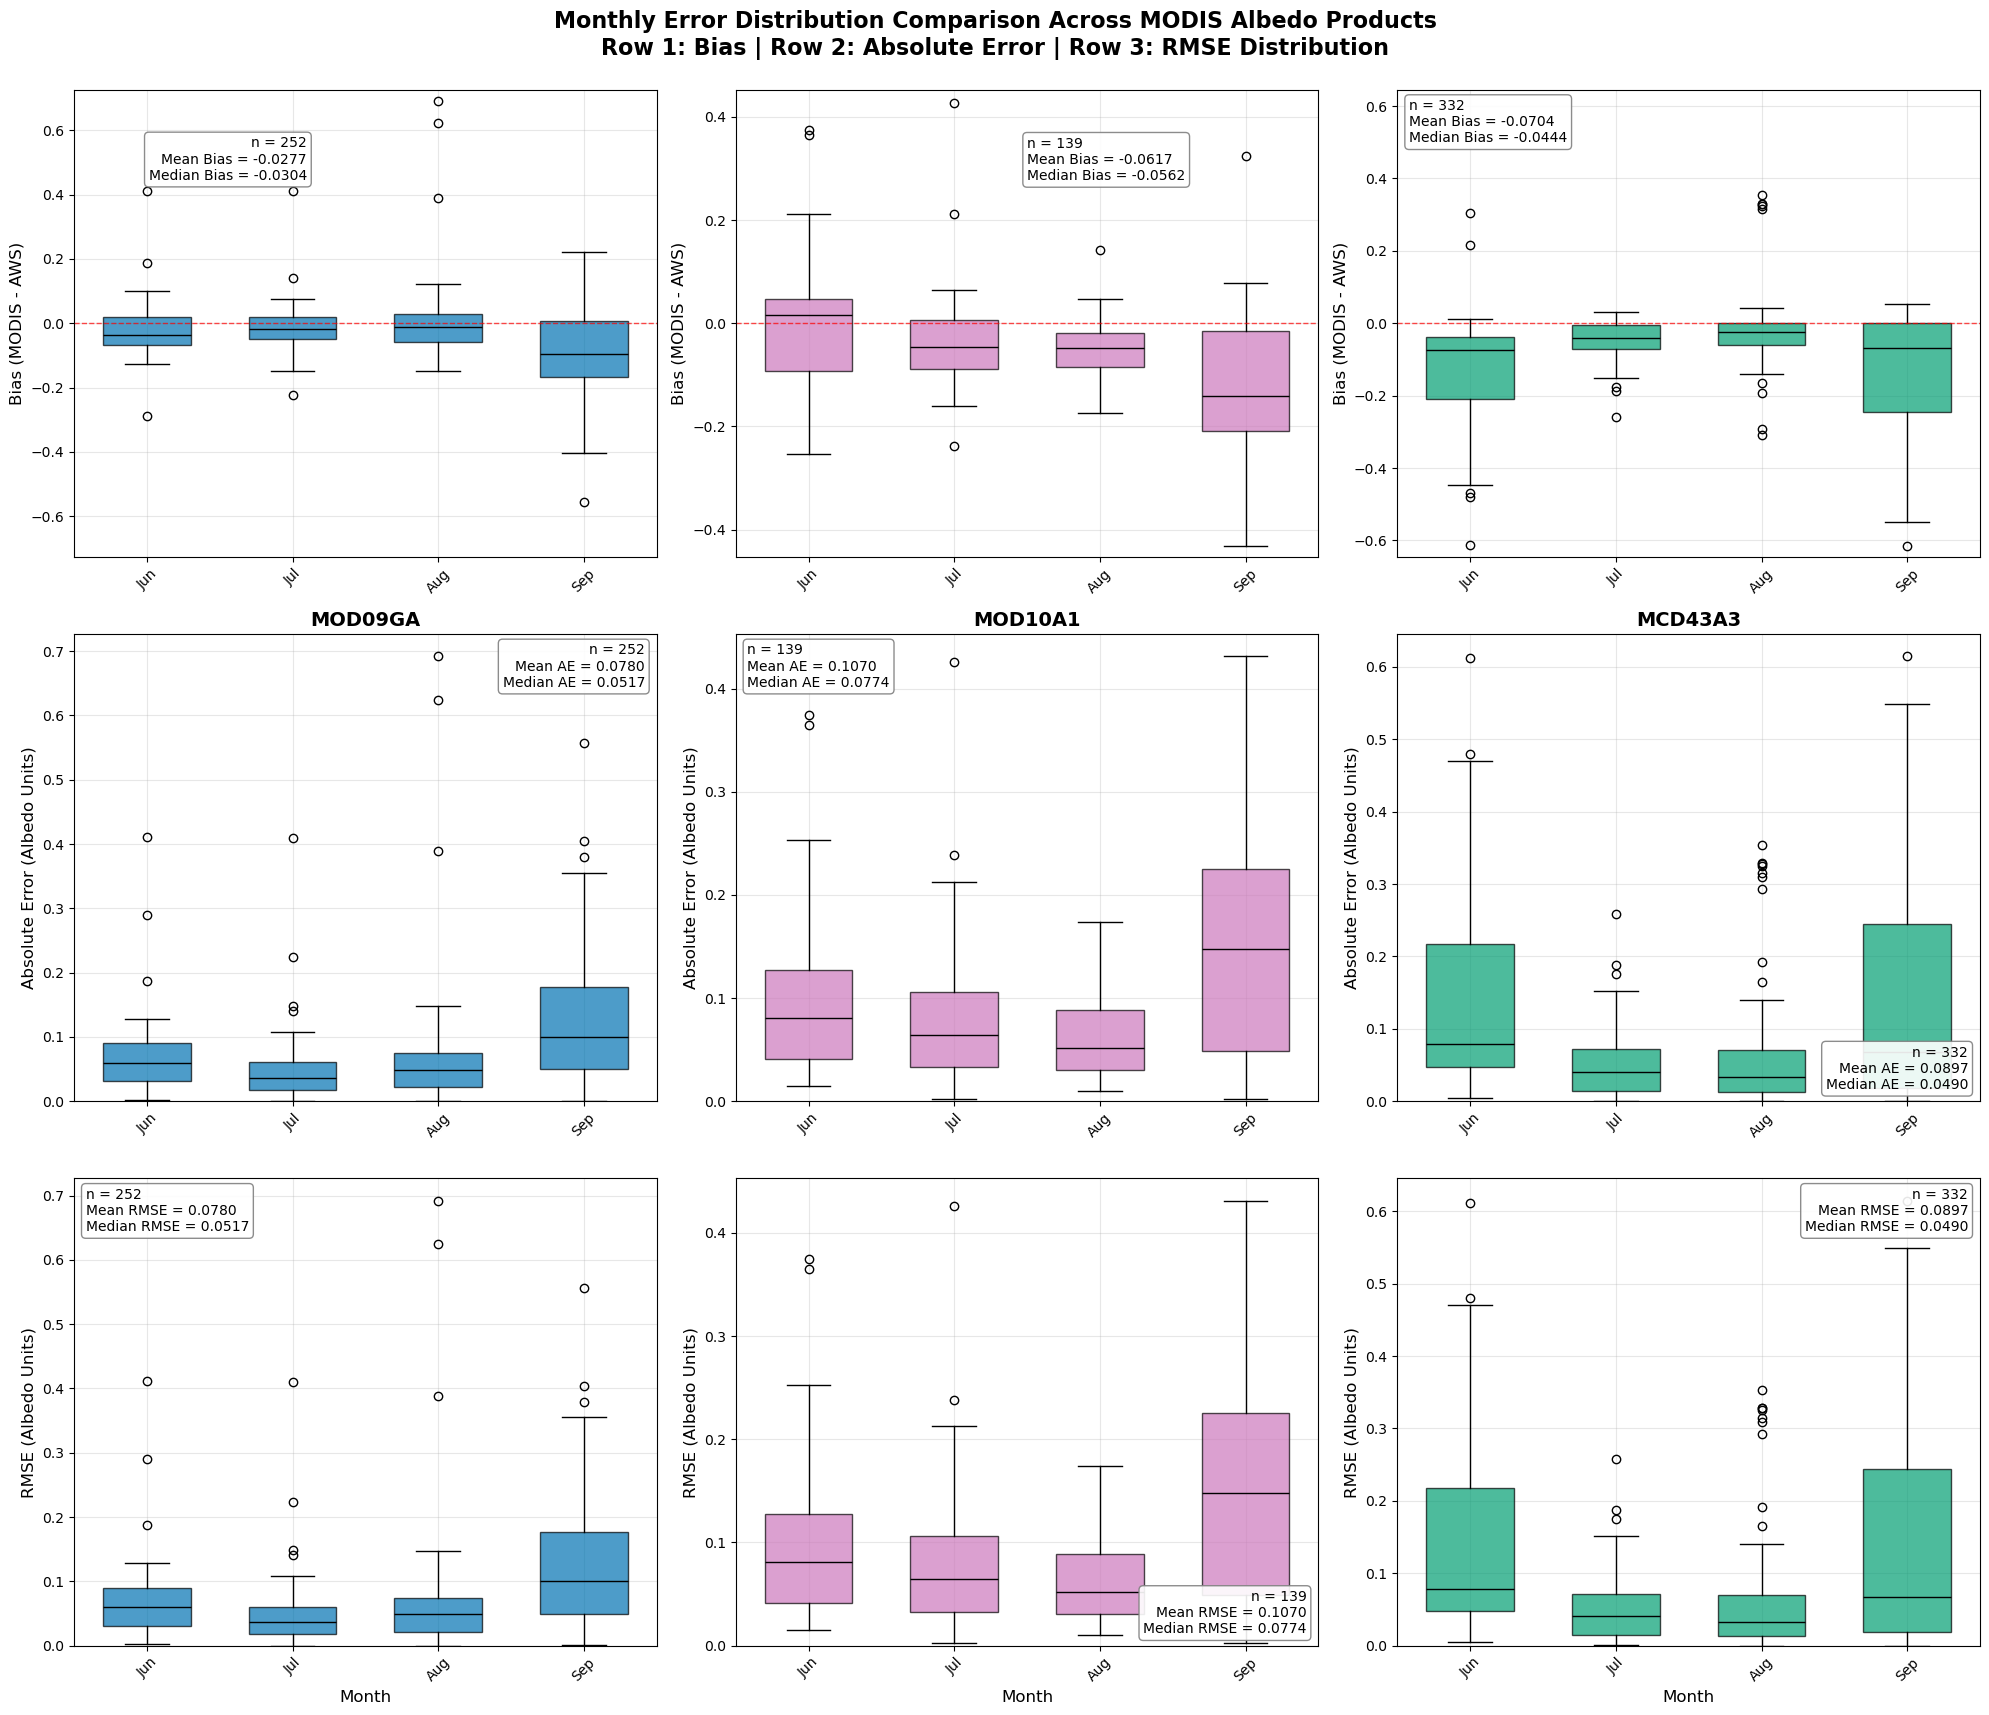


=== COMPARATIVE MONTHLY ERROR SUMMARY ===
Absolute Error Statistics:
Bias Statistics:

Absolute Error Summary:
Method     N      Mean AE   Median AE   Std AE    90th %ile
------------------------------------------------------------
MOD09GA    252    0.0780    0.0517      0.0958    0.1659   
MOD10A1    139    0.1070    0.0774      0.0970    0.2531   
MCD43A3    332    0.0897    0.0490      0.1203    0.2899   

Bias Summary:
Method     N      Mean Bias   Median Bias   Std Bias   10th-90th %ile 
----------------------------------------------------------------------
MOD09GA    252    -0.0277     -0.0304       0.1203     -0.1281 to 0.0623
MOD10A1    139    -0.0617     -0.0562       0.1305     -0.2253 to 0.0472
MCD43A3    332    -0.0704     -0.0444       0.1326     -0.2134 to 0.0152

✓ Comparative analysis complete - exported to: athabasca_comparative_monthly_error_distributions.png


In [67]:
# Unified Monthly Error Distribution Comparison (Absolute Error + Bias)
print("=== COMPARATIVE MONTHLY ERROR DISTRIBUTION ANALYSIS ===")
print("Creating unified boxplot comparison: Absolute Error + Bias across all three MODIS products")
print()

# MANUAL POSITIONING CONFIGURATION
# Adjust these coordinates to position statistics boxes where you want them
# Coordinates are in axes units: (0,0) = bottom-left, (1,1) = top-right
# Format: (x_position, y_position, horizontal_alignment, vertical_alignment)

stats_positions = {
    'MOD09GA': {
        'bias': (0.40, 0.90, 'right', 'top'),          # Top-right
        'abs_error': (0.98, 0.98, 'right', 'top'),    # Top-right
        'rmse': (0.02, 0.98, 'left', 'top')           # Top-left
    },
    'MOD10A1': {
        'bias': (0.50, 0.80, 'left', 'bottom'),       # Bottom-left  
        'abs_error': (0.02, 0.98, 'left', 'top'),     # Top-left
        'rmse': (0.98, 0.02, 'right', 'bottom')       # Bottom-right
    },
    'MCD43A3': {
        'bias': (0.02, 0.98, 'left', 'top'),          # Top-left
        'abs_error': (0.98, 0.02, 'right', 'bottom'), # Bottom-right
        'rmse': (0.98, 0.98, 'right', 'top')          # Top-right
    }
}

print("Manual positioning enabled - you can adjust stats_positions dictionary above to customize legend placement")
print()

# Prepare data for all three methods
methods = ['MOD09GA', 'MOD10A1', 'MCD43A3']

# Scientific colorblind-friendly palette (Paul Tol's scheme)
method_colors = {
    'MOD09GA': '#0173B2',    # Blue - Terra/reflectance data
    'MOD10A1': '#CC78BC',    # Rose/Purple - Snow/ice product  
    'MCD43A3': '#029E73'     # Green - Combined/BRDF product
}

# Create figure with 3 rows x 3 columns
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
fig.suptitle('Monthly Error Distribution Comparison Across MODIS Albedo Products\nRow 1: Bias | Row 2: Absolute Error | Row 3: RMSE Distribution', 
             fontsize=16, fontweight='bold', y=0.95)

month_names = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
               7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

# Process each method for bias, absolute error, and RMSE
for i, method in enumerate(methods):
    # Row 1: Bias
    ax_bias = axes[0, i]
    # Row 2: Absolute Error
    ax_abs = axes[1, i]
    # Row 3: RMSE
    ax_rmse = axes[2, i]
    
    # Get valid data for this method
    valid_data = merged[[method, 'AWS', 'month']].dropna()
    
    if len(valid_data) == 0:
        # Handle no data case for all three plots
        for ax, metric in [(ax_bias, "Bias"), (ax_abs, "Absolute Error"), (ax_rmse, "RMSE")]:
            ax.text(0.5, 0.5, f'No valid data\nfor {method}', 
                    ha='center', va='center', transform=ax.transAxes,
                    fontsize=12, color='red')
            ax.set_title(f'{method}\n(No Data)', fontweight='bold')
        continue
    
    # Calculate errors
    bias_errors = valid_data[method] - valid_data['AWS']
    abs_errors = np.abs(bias_errors)
    rmse_errors = bias_errors ** 2  # Squared errors for RMSE calculation
    valid_data = valid_data.copy()
    valid_data['abs_error'] = abs_errors
    valid_data['bias'] = bias_errors
    valid_data['rmse_error'] = rmse_errors
    
    # Get unique months and sort them
    available_months = sorted(valid_data['month'].unique())
    
    # Prepare data for all three boxplots
    monthly_abs_errors = []
    monthly_bias_errors = []
    monthly_rmse_errors = []
    month_labels = []
    
    for month in available_months:
        month_mask = valid_data['month'] == month
        abs_month_data = valid_data[month_mask]['abs_error']
        bias_month_data = valid_data[month_mask]['bias']
        rmse_month_data = np.sqrt(valid_data[month_mask]['rmse_error'])  # Take sqrt for RMSE
        
        if len(abs_month_data) > 0:
            monthly_abs_errors.append(abs_month_data.values)
            monthly_bias_errors.append(bias_month_data.values)
            monthly_rmse_errors.append(rmse_month_data.values)
            month_labels.append(month_names[month])
    
    if monthly_abs_errors and monthly_bias_errors and monthly_rmse_errors:
        # Create bias boxplot (row 1)
        bp_bias = ax_bias.boxplot(monthly_bias_errors, patch_artist=True, 
                                 tick_labels=month_labels, widths=0.6)
        
        # Create absolute error boxplot (row 2)
        bp_abs = ax_abs.boxplot(monthly_abs_errors, patch_artist=True, 
                               tick_labels=month_labels, widths=0.6)
        
        # Create RMSE boxplot (row 3)
        bp_rmse = ax_rmse.boxplot(monthly_rmse_errors, patch_artist=True, 
                                 tick_labels=month_labels, widths=0.6)
        
        # Customize boxplot appearance for all three
        for bp, ax in [(bp_bias, ax_bias), (bp_abs, ax_abs), (bp_rmse, ax_rmse)]:
            for patch in bp['boxes']:
                patch.set_facecolor(method_colors[method])
                patch.set_alpha(0.7)
                patch.set_edgecolor('black')
                patch.set_linewidth(1)
            
            for element in ['whiskers', 'fliers', 'medians', 'caps']:
                plt.setp(bp[element], color='black', linewidth=1)
        
        # Calculate and display statistics
        all_abs_errors = np.concatenate(monthly_abs_errors)
        all_bias_errors = np.concatenate(monthly_bias_errors)
        all_rmse_errors = np.concatenate(monthly_rmse_errors)
        
        # Get positioning for this method
        bias_pos = stats_positions[method]['bias']
        abs_pos = stats_positions[method]['abs_error']
        rmse_pos = stats_positions[method]['rmse']
        
        # Bias stats - use manual positioning
        bias_stats_text = f'n = {len(valid_data):,}\n'
        bias_stats_text += f'Mean Bias = {np.mean(all_bias_errors):.4f}\n'
        bias_stats_text += f'Median Bias = {np.median(all_bias_errors):.4f}'
        
        ax_bias.text(bias_pos[0], bias_pos[1], bias_stats_text, 
                    transform=ax_bias.transAxes,
                    horizontalalignment=bias_pos[2], verticalalignment=bias_pos[3], 
                    fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))
        
        # Absolute error stats - use manual positioning
        abs_stats_text = f'n = {len(valid_data):,}\n'
        abs_stats_text += f'Mean AE = {np.mean(all_abs_errors):.4f}\n'
        abs_stats_text += f'Median AE = {np.median(all_abs_errors):.4f}'
        
        ax_abs.text(abs_pos[0], abs_pos[1], abs_stats_text, 
                   transform=ax_abs.transAxes,
                   horizontalalignment=abs_pos[2], verticalalignment=abs_pos[3], 
                   fontsize=10,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))
        
        # RMSE stats - use manual positioning
        rmse_stats_text = f'n = {len(valid_data):,}\n'
        rmse_stats_text += f'Mean RMSE = {np.mean(all_rmse_errors):.4f}\n'
        rmse_stats_text += f'Median RMSE = {np.median(all_rmse_errors):.4f}'
        
        ax_rmse.text(rmse_pos[0], rmse_pos[1], rmse_stats_text, 
                    transform=ax_rmse.transAxes,
                    horizontalalignment=rmse_pos[2], verticalalignment=rmse_pos[3], 
                    fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))
    
    # Formatting for bias plot (row 1)
    ax_bias.set_title(f'{method}', fontweight='bold', fontsize=14)
    ax_bias.set_ylabel('Bias (MODIS - AWS)', fontsize=12)
    ax_bias.grid(True, alpha=0.3)
    ax_bias.tick_params(axis='x', rotation=45)
    
    # Adaptive scaling for bias - symmetric around zero, include all data
    if len(all_bias_errors) > 0:
        # Use actual min/max with padding to ensure all boxplot elements are visible
        bias_min = np.min(all_bias_errors) * 1.05 if np.min(all_bias_errors) < 0 else np.min(all_bias_errors) * 0.95
        bias_max = np.max(all_bias_errors) * 1.05 if np.max(all_bias_errors) > 0 else np.max(all_bias_errors) * 0.95
        
        # Make symmetric around zero for better bias interpretation
        bias_abs_max = max(abs(bias_min), abs(bias_max))
        bias_abs_max = max(bias_abs_max, 0.02)  # Minimum scale for visibility
        ax_bias.set_ylim(-bias_abs_max, bias_abs_max)
    else:
        ax_bias.set_ylim(-0.1, 0.1)  # Fallback scale
    
    # Add horizontal line at y=0 for bias plots
    ax_bias.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=1)
    
    # Formatting for absolute error plot (row 2)
    ax_abs.set_title('')  # No title to avoid clutter
    ax_abs.set_ylabel('Absolute Error (Albedo Units)', fontsize=12)
    ax_abs.grid(True, alpha=0.3)
    ax_abs.tick_params(axis='x', rotation=45)
    
    # Adaptive scaling for absolute error - include whiskers and outliers
    if len(all_abs_errors) > 0:
        # Use max value with padding to ensure all boxplot elements are visible
        abs_max = np.max(all_abs_errors) * 1.05  # 5% padding above maximum
        abs_max = max(abs_max, 0.05)  # Minimum scale of 0.05 for visibility
        ax_abs.set_ylim(0, abs_max)
    else:
        ax_abs.set_ylim(0, 0.1)  # Fallback scale
    
    # Formatting for RMSE plot (row 3)
    ax_rmse.set_title('')  # No title to avoid clutter
    ax_rmse.set_ylabel('RMSE (Albedo Units)', fontsize=12)
    ax_rmse.set_xlabel('Month', fontsize=12)
    ax_rmse.grid(True, alpha=0.3)
    ax_rmse.tick_params(axis='x', rotation=45)
    
    # Adaptive scaling for RMSE - include whiskers and outliers
    if len(all_rmse_errors) > 0:
        # Use max value with padding to ensure all boxplot elements are visible
        rmse_max = np.max(all_rmse_errors) * 1.05  # 5% padding above maximum
        rmse_max = max(rmse_max, 0.05)  # Minimum scale of 0.05 for visibility
        ax_rmse.set_ylim(0, rmse_max)
    else:
        ax_rmse.set_ylim(0, 0.1)  # Fallback scale

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Export the plot
export_path = EXPORT_DIR / f'{GLACIER}_comparative_monthly_error_distributions.png'
plt.savefig(export_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Comparative monthly error distributions plot saved: {export_path}")

plt.show()

# Enhanced summary statistics table
print("\n=== COMPARATIVE MONTHLY ERROR SUMMARY ===")
print("Absolute Error Statistics:")
abs_summary_data = []
print("Bias Statistics:")
bias_summary_data = []

for method in methods:
    valid_data = merged[[method, 'AWS', 'month']].dropna()
    
    if len(valid_data) == 0:
        abs_summary_data.append([method, 0, 'N/A', 'N/A', 'N/A', 'N/A'])
        bias_summary_data.append([method, 0, 'N/A', 'N/A', 'N/A', 'N/A'])
        continue
    
    bias_errors = valid_data[method] - valid_data['AWS']
    abs_errors = np.abs(bias_errors)
    
    abs_summary_data.append([
        method,
        len(valid_data),
        f"{np.mean(abs_errors):.4f}",
        f"{np.median(abs_errors):.4f}",
        f"{np.std(abs_errors):.4f}",
        f"{np.percentile(abs_errors, 90):.4f}"
    ])
    
    bias_summary_data.append([
        method,
        len(valid_data),
        f"{np.mean(bias_errors):.4f}",
        f"{np.median(bias_errors):.4f}",
        f"{np.std(bias_errors):.4f}",
        f"{np.percentile(bias_errors, [10, 90])[0]:.4f} to {np.percentile(bias_errors, [10, 90])[1]:.4f}"
    ])

# Print absolute error summary
print("\nAbsolute Error Summary:")
print(f"{'Method':<10} {'N':<6} {'Mean AE':<9} {'Median AE':<11} {'Std AE':<9} {'90th %ile':<9}")
print("-" * 60)
for row in abs_summary_data:
    print(f"{row[0]:<10} {row[1]:<6} {row[2]:<9} {row[3]:<11} {row[4]:<9} {row[5]:<9}")

# Print bias summary  
print("\nBias Summary:")
print(f"{'Method':<10} {'N':<6} {'Mean Bias':<11} {'Median Bias':<13} {'Std Bias':<10} {'10th-90th %ile':<15}")
print("-" * 70)
for row in bias_summary_data:
    print(f"{row[0]:<10} {row[1]:<6} {row[2]:<11} {row[3]:<13} {row[4]:<10} {row[5]:<15}")

print(f"\n✓ Comparative analysis complete - exported to: {export_path.name}")

## 📊 3-Row Comparative Histogram Analysis

**Distribution Shapes Analysis**: While boxplots show quartiles, histograms reveal the **actual distribution shapes** of errors - skewness, multi-modal patterns, and tail behavior across all three MODIS methods.

✅ Exported histogram analysis: exports\athabasca_comparative_histogram_distributions.png


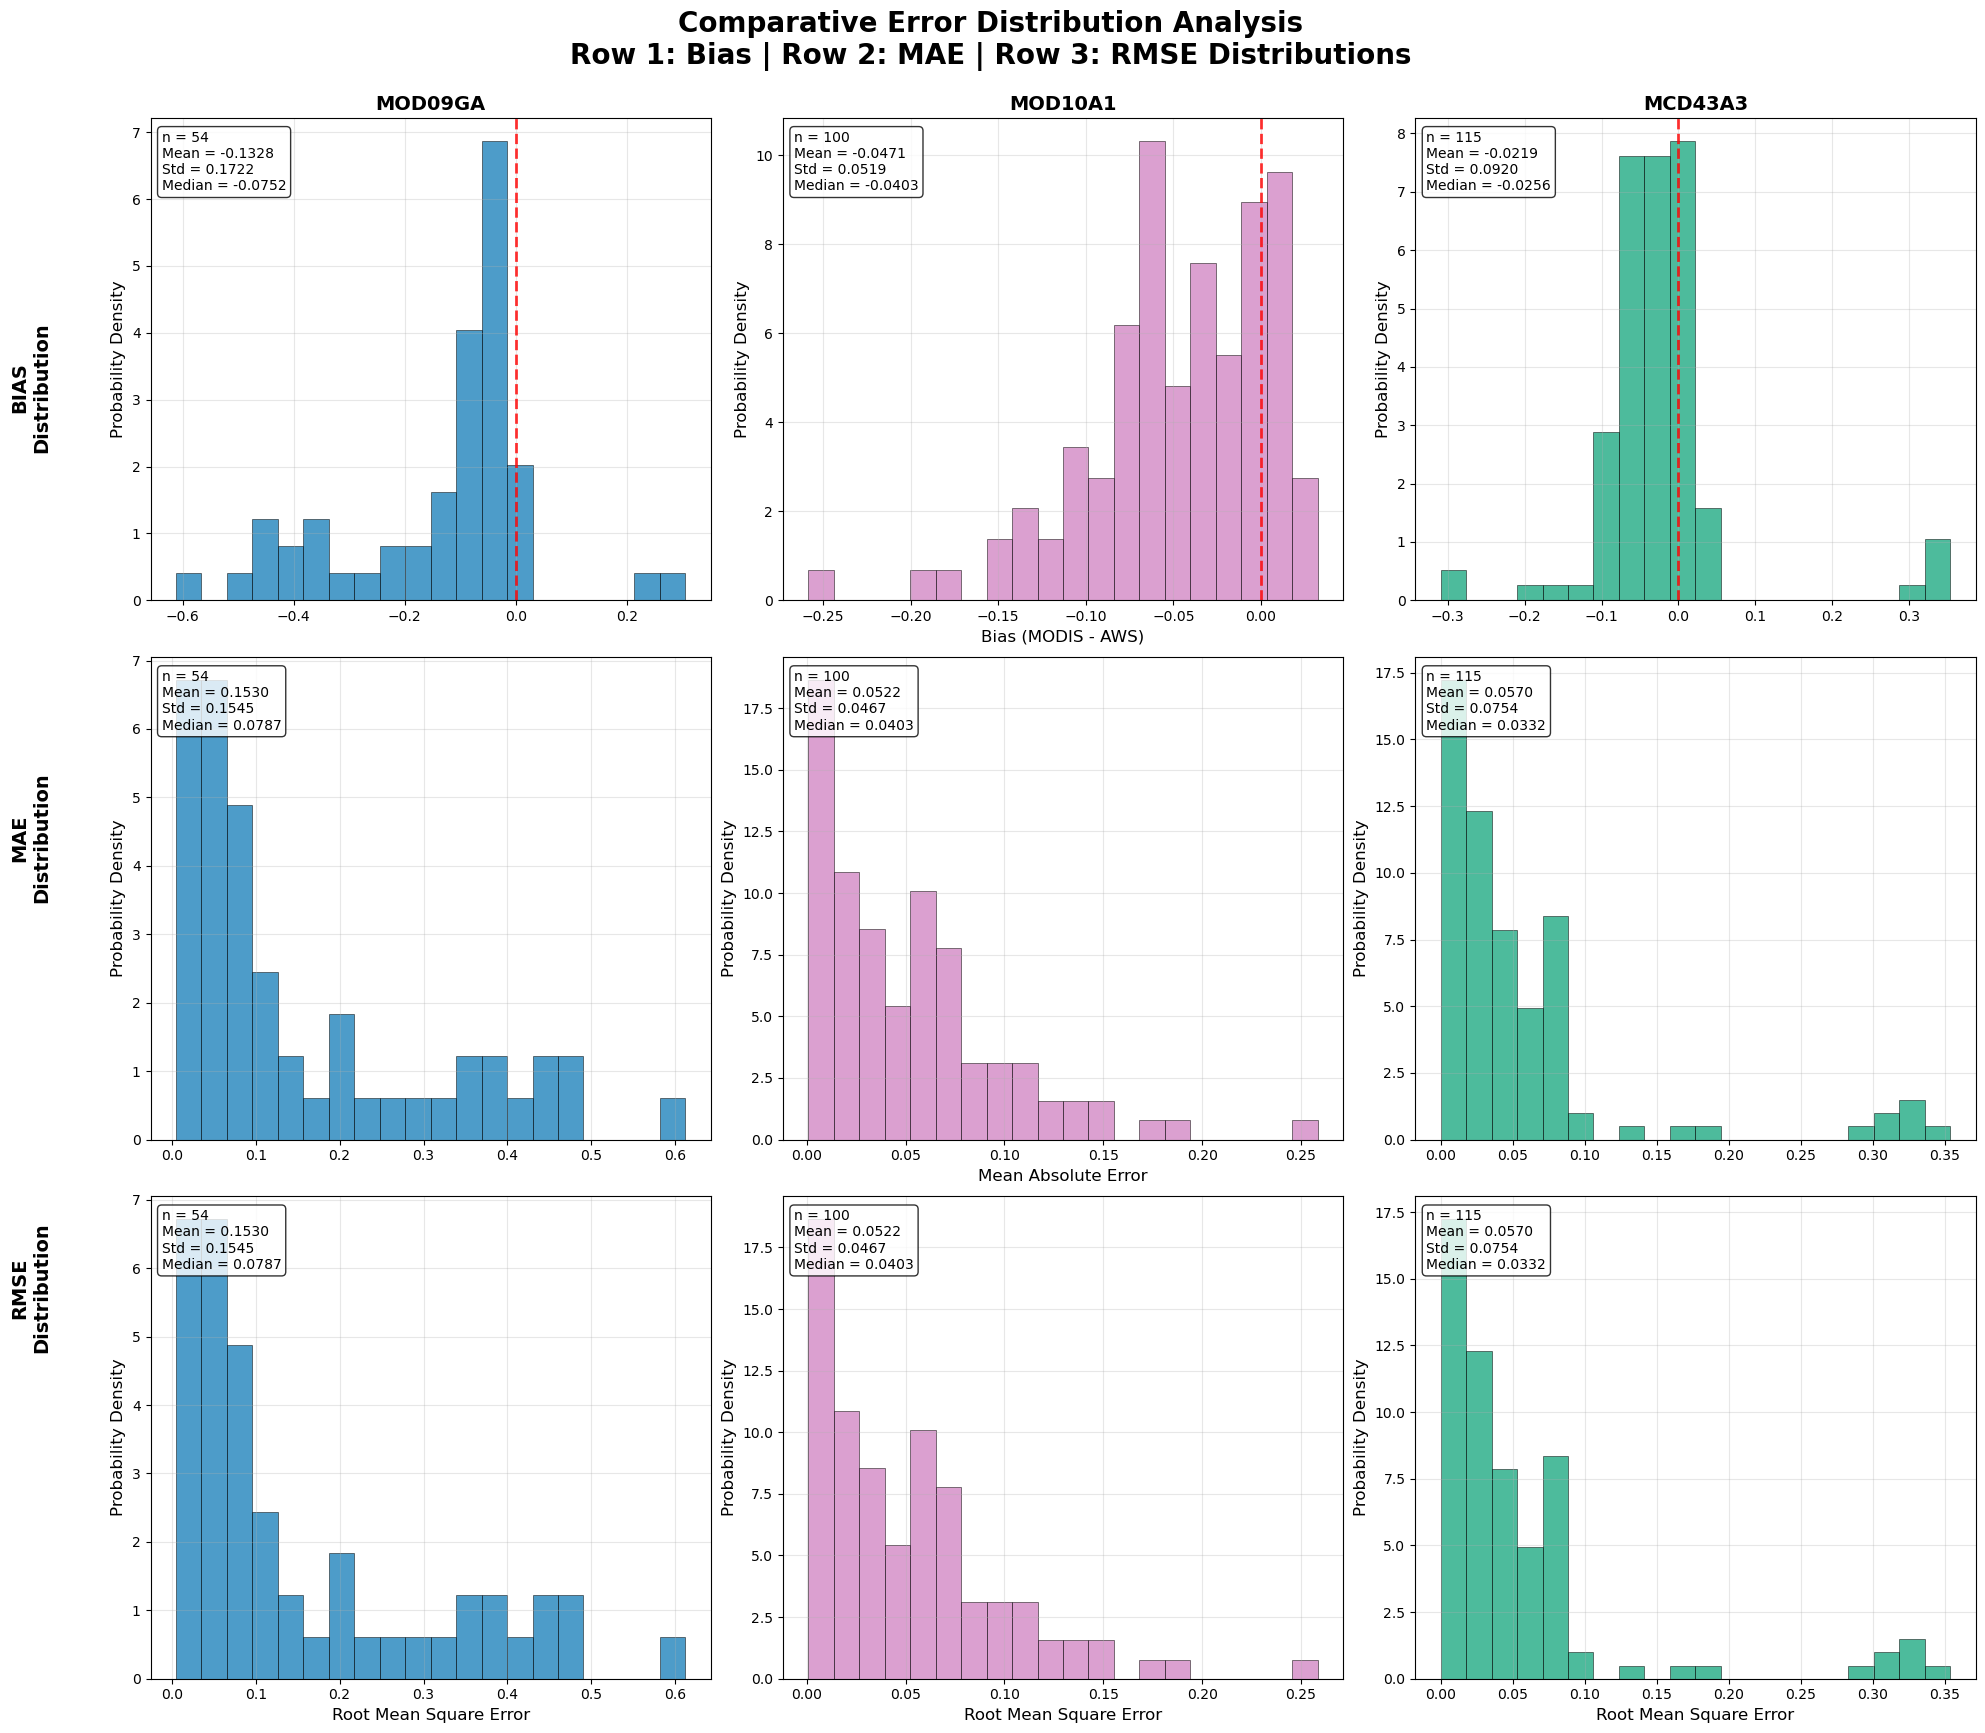


🔍 DISTRIBUTION ANALYSIS INSIGHTS


In [76]:
# =============================================================================
# 3-ROW COMPARATIVE HISTOGRAM ANALYSIS: Distribution Shapes
# Row 1: Bias Distribution | Row 2: MAE Distribution | Row 3: RMSE Distribution
# =============================================================================

# Paul Tol colorblind-friendly palette
method_colors = {
    'MOD09GA': '#0173B2',  # Blue
    'MOD10A1': '#CC78BC',  # Pink  
    'MCD43A3': '#029E73'   # Green
}

methods = ['MOD09GA', 'MOD10A1', 'MCD43A3']

# Create figure with 3 rows (Bias, MAE, RMSE) x 3 columns (methods)
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
fig.suptitle('Comparative Error Distribution Analysis\nRow 1: Bias | Row 2: MAE | Row 3: RMSE Distributions', 
             fontsize=20, fontweight='bold', y=0.96)

# Use existing monthly error data (same as boxplot analysis)
# monthly_bias_errors, monthly_abs_errors, monthly_rmse_errors are already computed

# Statistics positioning for each metric and method
hist_stats_positions = {
    'bias': {
        'MOD09GA': (0.02, 0.85),
        'MOD10A1': (0.02, 0.85), 
        'MCD43A3': (0.02, 0.85)
    },
    'mae': {
        'MOD09GA': (0.02, 0.85),
        'MOD10A1': (0.02, 0.85),
        'MCD43A3': (0.02, 0.85)
    },
    'rmse': {
        'MOD09GA': (0.02, 0.85),
        'MOD10A1': (0.02, 0.85),
        'MCD43A3': (0.02, 0.85)
    }
}

# Plot histograms for each method and metric
for i, method in enumerate(methods):
    
    # Get all observations for this method - these are already flattened arrays!
    bias_data = monthly_bias_errors[i]  # Already a 1D array of all bias observations
    mae_data = monthly_abs_errors[i]    # Already a 1D array of all MAE observations  
    rmse_data = monthly_rmse_errors[i]  # Already a 1D array of all RMSE observations
    
    color = method_colors[method]
    
    # Row 1: Bias Distribution
    ax_bias = axes[0, i]
    if len(bias_data) > 0:
        n_bins = min(50, max(20, int(np.sqrt(len(bias_data)))))
        ax_bias.hist(bias_data, bins=n_bins, alpha=0.7, color=color, 
                    edgecolor='black', linewidth=0.5, density=True)
        
        # Add vertical line at zero for bias
        ax_bias.axvline(x=0, color='red', linestyle='--', alpha=0.8, linewidth=2)
        
        # Calculate and display statistics
        bias_mean = np.mean(bias_data)
        bias_std = np.std(bias_data)
        bias_median = np.median(bias_data)
        
        stats_text = f'n = {len(bias_data):,}\nMean = {bias_mean:.4f}\nStd = {bias_std:.4f}\nMedian = {bias_median:.4f}'
        ax_bias.text(hist_stats_positions['bias'][method][0], hist_stats_positions['bias'][method][1], 
                    stats_text, transform=ax_bias.transAxes, fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Row 2: MAE Distribution  
    ax_mae = axes[1, i]
    if len(mae_data) > 0:
        n_bins = min(50, max(20, int(np.sqrt(len(mae_data)))))
        ax_mae.hist(mae_data, bins=n_bins, alpha=0.7, color=color,
                   edgecolor='black', linewidth=0.5, density=True)
        
        # Calculate and display statistics
        mae_mean = np.mean(mae_data)
        mae_std = np.std(mae_data)
        mae_median = np.median(mae_data)
        
        stats_text = f'n = {len(mae_data):,}\nMean = {mae_mean:.4f}\nStd = {mae_std:.4f}\nMedian = {mae_median:.4f}'
        ax_mae.text(hist_stats_positions['mae'][method][0], hist_stats_positions['mae'][method][1], 
                   stats_text, transform=ax_mae.transAxes, fontsize=10,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Row 3: RMSE Distribution
    ax_rmse = axes[2, i]
    if len(rmse_data) > 0:
        n_bins = min(50, max(20, int(np.sqrt(len(rmse_data)))))
        ax_rmse.hist(rmse_data, bins=n_bins, alpha=0.7, color=color,
                    edgecolor='black', linewidth=0.5, density=True)
        
        # Calculate and display statistics
        rmse_mean = np.mean(rmse_data)
        rmse_std = np.std(rmse_data)
        rmse_median = np.median(rmse_data)
        
        stats_text = f'n = {len(rmse_data):,}\nMean = {rmse_mean:.4f}\nStd = {rmse_std:.4f}\nMedian = {rmse_median:.4f}'
        ax_rmse.text(hist_stats_positions['rmse'][method][0], hist_stats_positions['rmse'][method][1], 
                    stats_text, transform=ax_rmse.transAxes, fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

    # Formatting for bias plot (row 1)
    ax_bias.set_title(f'{method}', fontweight='bold', fontsize=14)
    ax_bias.set_ylabel('Probability Density', fontsize=12)
    if i == 1:  # Middle column
        ax_bias.set_xlabel('Bias (MODIS - AWS)', fontsize=12)
    ax_bias.grid(True, alpha=0.3)
    
    # Formatting for MAE plot (row 2)
    ax_mae.set_ylabel('Probability Density', fontsize=12)
    if i == 1:  # Middle column
        ax_mae.set_xlabel('Mean Absolute Error', fontsize=12)
    ax_mae.grid(True, alpha=0.3)
    
    # Formatting for RMSE plot (row 3)
    ax_rmse.set_ylabel('Probability Density', fontsize=12)
    ax_rmse.set_xlabel('Root Mean Square Error', fontsize=12)
    ax_rmse.grid(True, alpha=0.3)

# Add row labels on the left
fig.text(0.02, 0.75, 'BIAS\nDistribution', fontsize=14, fontweight='bold', 
         ha='center', va='center', rotation=90)
fig.text(0.02, 0.50, 'MAE\nDistribution', fontsize=14, fontweight='bold', 
         ha='center', va='center', rotation=90)
fig.text(0.02, 0.25, 'RMSE\nDistribution', fontsize=14, fontweight='bold', 
         ha='center', va='center', rotation=90)

plt.tight_layout()
plt.subplots_adjust(left=0.08, top=0.90)

# Export the figure
export_path = EXPORT_DIR / f'{GLACIER}_comparative_histogram_distributions.png'
plt.savefig(export_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✅ Exported histogram analysis: {export_path}")

plt.show()

# Print distribution insights
print("\n" + "="*80)
print("🔍 DISTRIBUTION ANALYSIS INSIGHTS")
print("="*80)

for method in methods:
    bias_data = np.array(monthly_bias_data[method])
    mae_data = np.array(monthly_mae_data[method])
    
    if len(bias_data) > 0:
        # Analyze bias distribution shape
        bias_skew = scipy.stats.skew(bias_data)
        bias_kurt = scipy.stats.kurtosis(bias_data)
        
        # Analyze MAE distribution shape  
        mae_skew = scipy.stats.skew(mae_data)
        mae_kurt = scipy.stats.kurtosis(mae_data)
        
        print(f"\n📊 {method}:")
        print(f"   Bias Skewness: {bias_skew:.3f} {'(right-skewed)' if bias_skew > 0.5 else '(left-skewed)' if bias_skew < -0.5 else '(symmetric)'}")
        print(f"   Bias Kurtosis: {bias_kurt:.3f} {'(heavy tails)' if bias_kurt > 1 else '(light tails)' if bias_kurt < -1 else '(normal tails)'}")
        print(f"   MAE Skewness:  {mae_skew:.3f} {'(right-skewed)' if mae_skew > 0.5 else '(symmetric)'}")
        print(f"   MAE Kurtosis:  {mae_kurt:.3f} {'(heavy tails)' if mae_kurt > 1 else '(light tails)' if mae_kurt < -1 else '(normal tails)'}")

In [74]:
# =============================================================================
# DIAGNOSTIC: Understand the actual data structure
# =============================================================================

print("🔍 DEBUGGING DATA STRUCTURE")
print("="*60)

print(f"monthly_bias_errors type: {type(monthly_bias_errors)}")
print(f"monthly_bias_errors length: {len(monthly_bias_errors)}")

for i in range(min(3, len(monthly_bias_errors))):
    print(f"\nMethod {i} ({methods[i] if i < len(methods) else 'Unknown'}):")
    print(f"  Type: {type(monthly_bias_errors[i])}")
    print(f"  Length: {len(monthly_bias_errors[i])}")
    
    # Check first few elements
    for j in range(min(3, len(monthly_bias_errors[i]))):
        elem = monthly_bias_errors[i][j]
        print(f"    Month {j}: type={type(elem)}, shape={getattr(elem, 'shape', 'no shape')}")
        if hasattr(elem, '__len__') and len(elem) > 0:
            print(f"             first few values: {elem[:3] if len(elem) >= 3 else elem}")

print("\n" + "="*60)

🔍 DEBUGGING DATA STRUCTURE
monthly_bias_errors type: <class 'list'>
monthly_bias_errors length: 4

Method 0 (MOD09GA):
  Type: <class 'numpy.ndarray'>
  Length: 54
    Month 0: type=<class 'numpy.float64'>, shape=()
    Month 1: type=<class 'numpy.float64'>, shape=()
    Month 2: type=<class 'numpy.float64'>, shape=()

Method 1 (MOD10A1):
  Type: <class 'numpy.ndarray'>
  Length: 100
    Month 0: type=<class 'numpy.float64'>, shape=()
    Month 1: type=<class 'numpy.float64'>, shape=()
    Month 2: type=<class 'numpy.float64'>, shape=()

Method 2 (MCD43A3):
  Type: <class 'numpy.ndarray'>
  Length: 115
    Month 0: type=<class 'numpy.float64'>, shape=()
    Month 1: type=<class 'numpy.float64'>, shape=()
    Month 2: type=<class 'numpy.float64'>, shape=()

